# About run_sequence_clustering_analysis

This notebook clusters action sequences and analyzes the resulting clusters

In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
%aimport utils_read_parsing
%aimport generalized_seq_miner
from utils_timeline_viz import *
from utils_read_parsing import *
from generalized_seq_miner import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 12,4
from matplotlib.backends.backend_pdf import PdfPages
import os
import numpy as np
import pandas as pd
import getpass
import datetime
import json
import matplotlib
import matplotlib.pyplot as plt
from itertools import groupby
from tabulate import tabulate
pd.set_option('display.max_columns', None);pd.set_option('display.max_rows', None);pd.set_option('precision', 2)
# FOLDER =  'C:\\Users\\'+getpass.getuser()+'\\Documents\\Personal Content\\Lab_skills_study\\parsed log data'

# Loading data

We grab the student learning data

In [2]:
df_all = get_df_all_factors(all_vars=True)
variables = list(set(df_all['variable']))
ids = list(set(df_all['sid']))
N = len(ids)
print 'We have',N,'students.'
print 'Running the analaysis on the following variables:',', '.join(variables)

We have 147 students.
Running the analaysis on the following variables: Battery voltage, Area, Width, Separation, Wavelength, Concentration


We grab the sequences

In [3]:
import pickle
from utils_sequence_parsing import Sequence
pickle_in_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_sim_by_student_parsed_seqs.txt'),"r")
all_seqs = pickle.load(pickle_in_seqs)
pickle_in_seqs.close()

## Tranform sequences

We transform the sequences by blocking certain actions, removing others, merging some and generalizing
We store all seqs as a list of Sequence() items

In [4]:
transformed_seqs = []
for sim,seqs_by_student in all_seqs.iteritems():
    for sid,seq in seqs_by_student.iteritems():
        seq.remove_actions('ignore')
        seq.merge_actions(['P','P_notes'])
        seq.block_actions(['P','V_area', 'V_battery', 'V_lightbulb', 'V_separation','V_other','V_width','V_concentration','V_wavelength','V_detector','V_laser','V_ruler'])
        seq.translate_variable_actions()
        seq.check_lengths_seq_timecoords()
        transformed_seqs.append(seq)

In [5]:
print len(transformed_seqs)

294


# Distance matrix

In [47]:
def lcs(X, Y): 
    # find the length of the strings 
    m = len(X) 
    n = len(Y) 
  
    # declaring the array for storing the dp values 
    L = [[None]*(n + 1) for i in xrange(m + 1)] 
  
    """Following steps build L[m + 1][n + 1] in bottom up fashion 
    Note: L[i][j] contains length of LCS of X[0..i-1] 
    and Y[0..j-1]"""
    for i in range(m + 1): 
        for j in range(n + 1): 
            if i == 0 or j == 0 : 
                L[i][j] = 0
            elif X[i-1] == Y[j-1]: 
                L[i][j] = L[i-1][j-1]+1
            else: 
                L[i][j] = max(L[i-1][j], L[i][j-1]) 
  
    # L[m][n] contains the length of LCS of X[0..n-1] & Y[0..m-1] 
    return L[m][n] 
# end of function lcs 

We define a matrix that will store all our sequences distances

In [7]:
M = len(transformed_seqs)
distances = np.zeros((M,M))
normalized = np.zeros((M,M))

In [23]:
for i,s1 in enumerate(transformed_seqs):
    for j,s2 in enumerate(transformed_seqs):
        score = lcs(s1.seq,s2.seq)
        distances[i][j] = score
        normalized[i][j] = len(s1.seq)+ len(s2.seq) - 2*score # the greater distance, the greater the score

KeyboardInterrupt: 

In [24]:
np.mean(distances),max(distances.flatten()),min(distances.flatten())

(40.89468508491832, 272.0, 3.0)

Text(0.5,1,'Distribution of length of Longuest comon subsequence of all sequences')

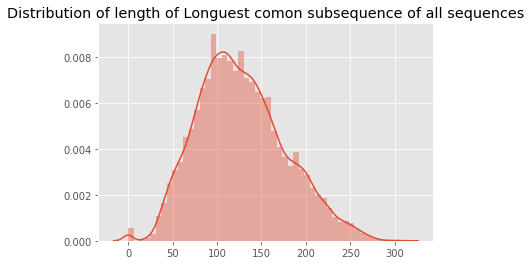

In [25]:
sns.distplot(normalized.flatten())
plt.title('Distribution of length of Longuest comon subsequence of all sequences')

In [56]:
def lcs_matrix(X, Y): 
    # find the length of the strings 
    m = len(X) 
    n = len(Y) 
  
    # declaring the array for storing the dp values 
    L = [[None]*(n + 1) for i in xrange(m + 1)] 
  
    """Following steps build L[m + 1][n + 1] in bottom up fashion 
    Note: L[i][j] contains length of LCS of X[0..i-1] 
    and Y[0..j-1]"""
    for i in range(m + 1): 
        for j in range(n + 1): 
            if i == 0 or j == 0 : 
                L[i][j] = 0
            elif X[i-1] == Y[j-1]:
                print 'match',i,j,X[i-1],Y[j-1]
                L[i][j] = L[i-1][j-1]+1
            else: 
                print 'MISmatch',i,j,X[i-1],Y[j-1]
                L[i][j] = max(L[i-1][j], L[i][j-1]) 
  
    # L[m][n] contains the length of LCS of X[0..n-1] & Y[0..m-1] 
    return L 
# end of function lcs 

In [62]:
X = 'defghijke'
Y = 'tdefghijkve'
lcs_matrix(Y,X)

MISmatch 1 1 t d
MISmatch 1 2 t e
MISmatch 1 3 t f
MISmatch 1 4 t g
MISmatch 1 5 t h
MISmatch 1 6 t i
MISmatch 1 7 t j
MISmatch 1 8 t k
MISmatch 1 9 t e
match 2 1 d d
MISmatch 2 2 d e
MISmatch 2 3 d f
MISmatch 2 4 d g
MISmatch 2 5 d h
MISmatch 2 6 d i
MISmatch 2 7 d j
MISmatch 2 8 d k
MISmatch 2 9 d e
MISmatch 3 1 e d
match 3 2 e e
MISmatch 3 3 e f
MISmatch 3 4 e g
MISmatch 3 5 e h
MISmatch 3 6 e i
MISmatch 3 7 e j
MISmatch 3 8 e k
match 3 9 e e
MISmatch 4 1 f d
MISmatch 4 2 f e
match 4 3 f f
MISmatch 4 4 f g
MISmatch 4 5 f h
MISmatch 4 6 f i
MISmatch 4 7 f j
MISmatch 4 8 f k
MISmatch 4 9 f e
MISmatch 5 1 g d
MISmatch 5 2 g e
MISmatch 5 3 g f
match 5 4 g g
MISmatch 5 5 g h
MISmatch 5 6 g i
MISmatch 5 7 g j
MISmatch 5 8 g k
MISmatch 5 9 g e
MISmatch 6 1 h d
MISmatch 6 2 h e
MISmatch 6 3 h f
MISmatch 6 4 h g
match 6 5 h h
MISmatch 6 6 h i
MISmatch 6 7 h j
MISmatch 6 8 h k
MISmatch 6 9 h e
MISmatch 7 1 i d
MISmatch 7 2 i e
MISmatch 7 3 i f
MISmatch 7 4 i g
MISmatch 7 5 i h
match 7 6 i i
M

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 2, 2, 2, 2, 2, 2, 2, 2],
 [0, 1, 2, 3, 3, 3, 3, 3, 3, 3],
 [0, 1, 2, 3, 4, 4, 4, 4, 4, 4],
 [0, 1, 2, 3, 4, 5, 5, 5, 5, 5],
 [0, 1, 2, 3, 4, 5, 6, 6, 6, 6],
 [0, 1, 2, 3, 4, 5, 6, 7, 7, 7],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

In [54]:
x,y = np.unravel_index(np.argmax(normalized, axis=None), normalized.shape)
seqx = transformed_seqs[x]
seqy = transformed_seqs[y]
print seqx.parameters()
print seqy.parameters()
matrix = lcs_matrix(seqx.seq,seqy.seq)

Length:180 actions, sid:19989152, sim:beers, blocked actions:set(['V_separation', 'V_wavelength', 'V_detector', 'V_other', 'V_lightbulb', 'V_ruler', 'P', 'V_width', 'V_area', 'V_concentration', 'V_laser', 'V_battery']),actions removed: set(['ignore']), merged_actions: set([('P', 'P_notes')]), has timecoords: True
None
Length:272 actions, sid:19196162, sim:beers, blocked actions:set(['V_separation', 'V_wavelength', 'V_detector', 'V_other', 'V_lightbulb', 'V_ruler', 'P', 'V_width', 'V_area', 'V_concentration', 'V_laser', 'V_battery']),actions removed: set(['ignore']), merged_actions: set([('P', 'P_notes')]), has timecoords: True
None
match 1 1 V_laser V_laser
MISmatch 1 2 V_laser V_laser
MISmatch 1 3 V_laser V_laser
MISmatch 1 4 V_laser V_laser
MISmatch 1 5 V_laser V_laser
MISmatch 1 6 V_laser V_laser
MISmatch 1 7 V_laser V_laser
MISmatch 1 8 V_laser V_laser
MISmatch 1 9 V_laser V_laser
MISmatch 1 10 V_laser V_laser
MISmatch 1 11 V_laser V_laser
MISmatch 1 12 V_laser V_laser
MISmatch 1 1

MISmatch 2 24 V_other V_detector
MISmatch 2 25 V_other V_detector
MISmatch 2 26 V_other V_detector
MISmatch 2 27 V_other V_detector
MISmatch 2 28 V_other V_detector
MISmatch 2 29 V_other V_detector
MISmatch 2 30 V_other V_detector
MISmatch 2 31 V_other V_detector
MISmatch 2 32 V_other V_detector
MISmatch 2 33 V_other V_detector
MISmatch 2 34 V_other V_detector
MISmatch 2 35 V_other V_detector
MISmatch 2 36 V_other V_detector
MISmatch 2 37 V_other V_detector
MISmatch 2 38 V_other V_detector
MISmatch 2 39 V_other V_detector
MISmatch 2 40 V_other V_detector
MISmatch 2 41 V_other V_detector
MISmatch 2 42 V_other V_detector
MISmatch 2 43 V_other V_detector
MISmatch 2 44 V_other V_detector
MISmatch 2 45 V_other V_detector
MISmatch 2 46 V_other V_detector
MISmatch 2 47 V_other V_detector
MISmatch 2 48 V_other V_detector
MISmatch 2 49 V_other V_detector
MISmatch 2 50 V_other V_detector
MISmatch 2 51 V_other V_detector
MISmatch 2 52 V_other V_detector
MISmatch 2 53 V_other V_detector
MISmatch 2

MISmatch 3 68 V_laser V_quant
MISmatch 3 69 V_laser V_quant
MISmatch 3 70 V_laser V_quant
MISmatch 3 71 V_laser V_quant
MISmatch 3 72 V_laser V_quant
MISmatch 3 73 V_laser V_quant
MISmatch 3 74 V_laser V_quant
MISmatch 3 75 V_laser V_quant
MISmatch 3 76 V_laser V_quant
MISmatch 3 77 V_laser V_quant
MISmatch 3 78 V_laser V_quant
MISmatch 3 79 V_laser V_quant
MISmatch 3 80 V_laser V_quant
MISmatch 3 81 V_laser V_quant
MISmatch 3 82 V_laser V_quant
MISmatch 3 83 V_laser V_quant
MISmatch 3 84 V_laser V_quant
MISmatch 3 85 V_laser V_quant
MISmatch 3 86 V_laser V_quant
MISmatch 3 87 V_laser V_quant
MISmatch 3 88 V_laser V_quant
MISmatch 3 89 V_laser V_quant
MISmatch 3 90 V_laser V_quant
MISmatch 3 91 V_laser V_quant
MISmatch 3 92 V_laser V_quant
MISmatch 3 93 V_laser V_quant
MISmatch 3 94 V_laser V_quant
MISmatch 3 95 V_laser V_quant
MISmatch 3 96 V_laser V_quant
MISmatch 3 97 V_laser V_quant
MISmatch 3 98 V_laser V_quant
MISmatch 3 99 V_laser V_quant
MISmatch 3 100 V_laser V_quant
MISmatch 

MISmatch 4 68 V_other V_qual
MISmatch 4 69 V_other V_qual
MISmatch 4 70 V_other V_qual
MISmatch 4 71 V_other V_qual
MISmatch 4 72 V_other V_qual
MISmatch 4 73 V_other V_qual
MISmatch 4 74 V_other V_qual
MISmatch 4 75 V_other V_qual
MISmatch 4 76 V_other V_qual
MISmatch 4 77 V_other V_qual
MISmatch 4 78 V_other V_qual
MISmatch 4 79 V_other V_qual
MISmatch 4 80 V_other V_qual
MISmatch 4 81 V_other V_qual
MISmatch 4 82 V_other V_qual
MISmatch 4 83 V_other V_qual
MISmatch 4 84 V_other V_qual
MISmatch 4 85 V_other V_qual
MISmatch 4 86 V_other V_qual
MISmatch 4 87 V_other V_qual
MISmatch 4 88 V_other V_qual
MISmatch 4 89 V_other V_qual
MISmatch 4 90 V_other V_qual
MISmatch 4 91 V_other V_qual
MISmatch 4 92 V_other V_qual
MISmatch 4 93 V_other V_qual
MISmatch 4 94 V_other V_qual
MISmatch 4 95 V_other V_qual
MISmatch 4 96 V_other V_qual
MISmatch 4 97 V_other V_qual
MISmatch 4 98 V_other V_qual
MISmatch 4 99 V_other V_qual
MISmatch 4 100 V_other V_qual
MISmatch 4 101 V_other V_qual
MISmatch 4 1

MISmatch 5 75 V_laser V_detector
MISmatch 5 76 V_laser V_detector
MISmatch 5 77 V_laser V_detector
MISmatch 5 78 V_laser V_detector
MISmatch 5 79 V_laser V_detector
MISmatch 5 80 V_laser V_detector
MISmatch 5 81 V_laser V_detector
MISmatch 5 82 V_laser V_detector
MISmatch 5 83 V_laser V_detector
MISmatch 5 84 V_laser V_detector
MISmatch 5 85 V_laser V_detector
MISmatch 5 86 V_laser V_detector
MISmatch 5 87 V_laser V_detector
MISmatch 5 88 V_laser V_detector
MISmatch 5 89 V_laser V_detector
MISmatch 5 90 V_laser V_detector
MISmatch 5 91 V_laser V_detector
MISmatch 5 92 V_laser V_detector
MISmatch 5 93 V_laser V_detector
MISmatch 5 94 V_laser V_detector
MISmatch 5 95 V_laser V_detector
MISmatch 5 96 V_laser V_detector
MISmatch 5 97 V_laser V_detector
MISmatch 5 98 V_laser V_detector
MISmatch 5 99 V_laser V_detector
MISmatch 5 100 V_laser V_detector
MISmatch 5 101 V_laser V_detector
MISmatch 5 102 V_laser V_detector
MISmatch 5 103 V_laser V_detector
MISmatch 5 104 V_laser V_detector
MISma

MISmatch 6 52 V_other Switch_quant
MISmatch 6 53 V_other Switch_quant
MISmatch 6 54 V_other Switch_quant
MISmatch 6 55 V_other Switch_quant
MISmatch 6 56 V_other Switch_quant
MISmatch 6 57 V_other Switch_quant
MISmatch 6 58 V_other Switch_quant
MISmatch 6 59 V_other Switch_quant
MISmatch 6 60 V_other Switch_quant
MISmatch 6 61 V_other Switch_quant
MISmatch 6 62 V_other Switch_quant
MISmatch 6 63 V_other Switch_quant
MISmatch 6 64 V_other Switch_quant
MISmatch 6 65 V_other Switch_quant
MISmatch 6 66 V_other Switch_quant
MISmatch 6 67 V_other Switch_quant
MISmatch 6 68 V_other Switch_quant
MISmatch 6 69 V_other Switch_quant
MISmatch 6 70 V_other Switch_quant
MISmatch 6 71 V_other Switch_quant
MISmatch 6 72 V_other Switch_quant
MISmatch 6 73 V_other Switch_quant
MISmatch 6 74 V_other Switch_quant
MISmatch 6 75 V_other Switch_quant
MISmatch 6 76 V_other Switch_quant
MISmatch 6 77 V_other Switch_quant
MISmatch 6 78 V_other Switch_quant
MISmatch 6 79 V_other Switch_quant
MISmatch 6 80 V_othe

MISmatch 7 28 V_laser V_quant
MISmatch 7 29 V_laser V_quant
MISmatch 7 30 V_laser V_quant
MISmatch 7 31 V_laser V_quant
MISmatch 7 32 V_laser V_quant
MISmatch 7 33 V_laser V_quant
MISmatch 7 34 V_laser V_quant
MISmatch 7 35 V_laser V_quant
MISmatch 7 36 V_laser V_quant
MISmatch 7 37 V_laser V_quant
MISmatch 7 38 V_laser V_quant
MISmatch 7 39 V_laser V_quant
MISmatch 7 40 V_laser V_quant
MISmatch 7 41 V_laser V_quant
MISmatch 7 42 V_laser V_quant
MISmatch 7 43 V_laser V_quant
MISmatch 7 44 V_laser V_quant
MISmatch 7 45 V_laser V_quant
MISmatch 7 46 V_laser V_quant
MISmatch 7 47 V_laser V_quant
MISmatch 7 48 V_laser V_quant
MISmatch 7 49 V_laser V_quant
MISmatch 7 50 V_laser V_quant
MISmatch 7 51 V_laser V_quant
MISmatch 7 52 V_laser V_quant
MISmatch 7 53 V_laser V_quant
MISmatch 7 54 V_laser V_quant
MISmatch 7 55 V_laser V_quant
MISmatch 7 56 V_laser V_quant
MISmatch 7 57 V_laser V_quant
MISmatch 7 58 V_laser V_quant
MISmatch 7 59 V_laser V_quant
MISmatch 7 60 V_laser V_quant
MISmatch 7

MISmatch 8 120 V_other V_qual
MISmatch 8 121 V_other V_qual
MISmatch 8 122 V_other V_qual
MISmatch 8 123 V_other V_qual
MISmatch 8 124 V_other V_qual
MISmatch 8 125 V_other V_qual
MISmatch 8 126 V_other V_qual
MISmatch 8 127 V_other V_qual
MISmatch 8 128 V_other V_qual
MISmatch 8 129 V_other V_qual
MISmatch 8 130 V_other V_qual
MISmatch 8 131 V_other V_qual
MISmatch 8 132 V_other V_qual
MISmatch 8 133 V_other V_qual
MISmatch 8 134 V_other V_qual
MISmatch 8 135 V_other V_qual
MISmatch 8 136 V_other V_qual
MISmatch 8 137 V_other V_qual
MISmatch 8 138 V_other V_qual
MISmatch 8 139 V_other V_qual
MISmatch 8 140 V_other V_qual
MISmatch 8 141 V_other V_qual
MISmatch 8 142 V_other V_qual
MISmatch 8 143 V_other V_qual
MISmatch 8 144 V_other V_qual
MISmatch 8 145 V_other V_qual
MISmatch 8 146 V_other V_qual
MISmatch 8 147 V_other V_qual
MISmatch 8 148 V_other V_qual
MISmatch 8 149 V_other V_qual
MISmatch 8 150 V_other V_qual
MISmatch 8 151 V_other V_qual
MISmatch 8 152 V_other V_qual
MISmatch 8

MISmatch 9 207 V_laser V_quant
MISmatch 9 208 V_laser V_quant
MISmatch 9 209 V_laser V_quant
MISmatch 9 210 V_laser V_quant
MISmatch 9 211 V_laser V_quant
MISmatch 9 212 V_laser V_quant
MISmatch 9 213 V_laser V_quant
MISmatch 9 214 V_laser V_quant
MISmatch 9 215 V_laser V_quant
MISmatch 9 216 V_laser V_quant
MISmatch 9 217 V_laser V_quant
MISmatch 9 218 V_laser V_quant
MISmatch 9 219 V_laser V_quant
MISmatch 9 220 V_laser V_quant
MISmatch 9 221 V_laser V_quant
MISmatch 9 222 V_laser V_quant
MISmatch 9 223 V_laser V_quant
MISmatch 9 224 V_laser V_quant
MISmatch 9 225 V_laser V_quant
MISmatch 9 226 V_laser V_quant
MISmatch 9 227 V_laser V_quant
MISmatch 9 228 V_laser V_quant
MISmatch 9 229 V_laser V_quant
MISmatch 9 230 V_laser V_quant
MISmatch 9 231 V_laser V_quant
MISmatch 9 232 V_laser V_quant
MISmatch 9 233 V_laser V_quant
MISmatch 9 234 V_laser V_quant
MISmatch 9 235 V_laser V_quant
MISmatch 9 236 V_laser V_quant
MISmatch 9 237 V_laser V_quant
MISmatch 9 238 V_laser V_quant
MISmatch

MISmatch 10 201 V_other V_detector
MISmatch 10 202 V_other V_detector
MISmatch 10 203 V_other V_detector
MISmatch 10 204 V_other V_detector
MISmatch 10 205 V_other V_detector
MISmatch 10 206 V_other V_detector
MISmatch 10 207 V_other V_detector
MISmatch 10 208 V_other V_detector
MISmatch 10 209 V_other V_detector
MISmatch 10 210 V_other V_detector
MISmatch 10 211 V_other V_detector
MISmatch 10 212 V_other V_detector
MISmatch 10 213 V_other V_detector
MISmatch 10 214 V_other V_detector
MISmatch 10 215 V_other V_detector
MISmatch 10 216 V_other V_detector
MISmatch 10 217 V_other V_detector
MISmatch 10 218 V_other V_detector
MISmatch 10 219 V_other V_detector
MISmatch 10 220 V_other V_detector
MISmatch 10 221 V_other V_detector
MISmatch 10 222 V_other V_detector
MISmatch 10 223 V_other V_detector
MISmatch 10 224 V_other V_detector
MISmatch 10 225 V_other V_detector
MISmatch 10 226 V_other V_detector
MISmatch 10 227 V_other V_detector
MISmatch 10 228 V_other V_detector
MISmatch 10 229 V_ot

MISmatch 12 2 V_other V_ruler
MISmatch 12 3 V_other V_ruler
MISmatch 12 4 V_other V_ruler
MISmatch 12 5 V_other V_ruler
MISmatch 12 6 V_other V_ruler
MISmatch 12 7 V_other V_ruler
MISmatch 12 8 V_other V_ruler
MISmatch 12 9 V_other V_ruler
MISmatch 12 10 V_other V_ruler
MISmatch 12 11 V_other V_ruler
MISmatch 12 12 V_other V_ruler
MISmatch 12 13 V_other V_ruler
MISmatch 12 14 V_other V_ruler
MISmatch 12 15 V_other V_ruler
MISmatch 12 16 V_other V_ruler
MISmatch 12 17 V_other V_ruler
MISmatch 12 18 V_other V_ruler
MISmatch 12 19 V_other V_ruler
MISmatch 12 20 V_other V_ruler
MISmatch 12 21 V_other V_ruler
MISmatch 12 22 V_other V_ruler
MISmatch 12 23 V_other V_ruler
MISmatch 12 24 V_other V_ruler
MISmatch 12 25 V_other V_ruler
MISmatch 12 26 V_other V_ruler
MISmatch 12 27 V_other V_ruler
MISmatch 12 28 V_other V_ruler
MISmatch 12 29 V_other V_ruler
MISmatch 12 30 V_other V_ruler
MISmatch 12 31 V_other V_ruler
MISmatch 12 32 V_other V_ruler
MISmatch 12 33 V_other V_ruler
MISmatch 12 34 V

MISmatch 13 108 V_laser Switch_quant
MISmatch 13 109 V_laser Switch_quant
MISmatch 13 110 V_laser Switch_quant
MISmatch 13 111 V_laser Switch_quant
MISmatch 13 112 V_laser Switch_quant
MISmatch 13 113 V_laser Switch_quant
MISmatch 13 114 V_laser Switch_quant
MISmatch 13 115 V_laser Switch_quant
MISmatch 13 116 V_laser Switch_quant
MISmatch 13 117 V_laser Switch_quant
MISmatch 13 118 V_laser Switch_quant
MISmatch 13 119 V_laser Switch_quant
MISmatch 13 120 V_laser Switch_quant
MISmatch 13 121 V_laser Switch_quant
MISmatch 13 122 V_laser Switch_quant
MISmatch 13 123 V_laser Switch_quant
MISmatch 13 124 V_laser Switch_quant
MISmatch 13 125 V_laser Switch_quant
MISmatch 13 126 V_laser Switch_quant
MISmatch 13 127 V_laser Switch_quant
MISmatch 13 128 V_laser Switch_quant
MISmatch 13 129 V_laser Switch_quant
MISmatch 13 130 V_laser Switch_quant
MISmatch 13 131 V_laser Switch_quant
MISmatch 13 132 V_laser Switch_quant
MISmatch 13 133 V_laser Switch_quant
MISmatch 13 134 V_laser Switch_quant
M

MISmatch 14 120 V_other V_quant
MISmatch 14 121 V_other V_quant
MISmatch 14 122 V_other V_quant
MISmatch 14 123 V_other V_quant
MISmatch 14 124 V_other V_quant
MISmatch 14 125 V_other V_quant
MISmatch 14 126 V_other V_quant
MISmatch 14 127 V_other V_quant
MISmatch 14 128 V_other V_quant
MISmatch 14 129 V_other V_quant
MISmatch 14 130 V_other V_quant
MISmatch 14 131 V_other V_quant
MISmatch 14 132 V_other V_quant
MISmatch 14 133 V_other V_quant
MISmatch 14 134 V_other V_quant
MISmatch 14 135 V_other V_quant
MISmatch 14 136 V_other V_quant
MISmatch 14 137 V_other V_quant
MISmatch 14 138 V_other V_quant
MISmatch 14 139 V_other V_quant
MISmatch 14 140 V_other V_quant
MISmatch 14 141 V_other V_quant
MISmatch 14 142 V_other V_quant
MISmatch 14 143 V_other V_quant
MISmatch 14 144 V_other V_quant
MISmatch 14 145 V_other V_quant
MISmatch 14 146 V_other V_quant
MISmatch 14 147 V_other V_quant
MISmatch 14 148 V_other V_quant
MISmatch 14 149 V_other V_quant
MISmatch 14 150 V_other V_quant
MISmatch

MISmatch 15 233 V_laser V_laser
MISmatch 15 234 V_laser V_laser
MISmatch 15 235 V_laser V_laser
MISmatch 15 236 V_laser V_laser
MISmatch 15 237 V_laser V_laser
MISmatch 15 238 V_laser V_laser
MISmatch 15 239 V_laser V_laser
MISmatch 15 240 V_laser V_laser
MISmatch 15 241 V_laser V_laser
MISmatch 15 242 V_laser V_laser
MISmatch 15 243 V_laser V_laser
MISmatch 15 244 V_laser V_laser
MISmatch 15 245 V_laser V_laser
MISmatch 15 246 V_laser V_laser
MISmatch 15 247 V_laser V_laser
MISmatch 15 248 V_laser V_laser
MISmatch 15 249 V_laser V_laser
MISmatch 15 250 V_laser V_laser
MISmatch 15 251 V_laser V_laser
MISmatch 15 252 V_laser V_laser
MISmatch 15 253 V_laser V_laser
MISmatch 15 254 V_laser V_laser
MISmatch 15 255 V_laser V_laser
MISmatch 15 256 V_laser V_laser
MISmatch 15 257 V_laser V_laser
MISmatch 15 258 V_laser V_laser
MISmatch 15 259 V_laser V_laser
MISmatch 15 260 V_laser V_laser
MISmatch 15 261 V_laser V_laser
MISmatch 15 262 V_laser V_laser
MISmatch 15 263 V_laser V_laser
MISmatch

MISmatch 16 233 V_other V_qual
MISmatch 16 234 V_other V_qual
MISmatch 16 235 V_other V_qual
MISmatch 16 236 V_other V_qual
MISmatch 16 237 V_other V_qual
MISmatch 16 238 V_other V_qual
MISmatch 16 239 V_other V_qual
MISmatch 16 240 V_other V_qual
MISmatch 16 241 V_other V_qual
MISmatch 16 242 V_other V_qual
MISmatch 16 243 V_other V_qual
MISmatch 16 244 V_other V_qual
MISmatch 16 245 V_other V_qual
MISmatch 16 246 V_other V_qual
MISmatch 16 247 V_other V_qual
MISmatch 16 248 V_other V_qual
MISmatch 16 249 V_other V_qual
MISmatch 16 250 V_other V_qual
MISmatch 16 251 V_other V_qual
MISmatch 16 252 V_other V_qual
MISmatch 16 253 V_other V_qual
MISmatch 16 254 V_other V_qual
MISmatch 16 255 V_other V_qual
MISmatch 16 256 V_other V_qual
MISmatch 16 257 V_other V_qual
MISmatch 16 258 V_other V_qual
MISmatch 16 259 V_other V_qual
MISmatch 16 260 V_other V_qual
MISmatch 16 261 V_other V_qual
MISmatch 16 262 V_other V_qual
MISmatch 16 263 V_other V_qual
MISmatch 16 264 V_other V_qual
MISmatch

MISmatch 18 83 V_other Switch_quant
MISmatch 18 84 V_other Switch_quant
MISmatch 18 85 V_other Switch_quant
MISmatch 18 86 V_other Switch_quant
MISmatch 18 87 V_other Switch_quant
MISmatch 18 88 V_other Switch_quant
MISmatch 18 89 V_other Switch_quant
MISmatch 18 90 V_other Switch_quant
MISmatch 18 91 V_other Switch_quant
MISmatch 18 92 V_other Switch_quant
MISmatch 18 93 V_other Switch_quant
MISmatch 18 94 V_other Switch_quant
MISmatch 18 95 V_other Switch_quant
MISmatch 18 96 V_other Switch_quant
MISmatch 18 97 V_other Switch_quant
MISmatch 18 98 V_other Switch_quant
MISmatch 18 99 V_other Switch_quant
MISmatch 18 100 V_other Switch_quant
MISmatch 18 101 V_other Switch_quant
MISmatch 18 102 V_other Switch_quant
MISmatch 18 103 V_other Switch_quant
MISmatch 18 104 V_other Switch_quant
MISmatch 18 105 V_other Switch_quant
MISmatch 18 106 V_other Switch_quant
MISmatch 18 107 V_other Switch_quant
MISmatch 18 108 V_other Switch_quant
MISmatch 18 109 V_other Switch_quant
MISmatch 18 110 V_

MISmatch 19 77 V_laser V_quant
MISmatch 19 78 V_laser V_quant
MISmatch 19 79 V_laser V_quant
MISmatch 19 80 V_laser V_quant
MISmatch 19 81 V_laser V_quant
MISmatch 19 82 V_laser V_quant
MISmatch 19 83 V_laser V_quant
MISmatch 19 84 V_laser V_quant
MISmatch 19 85 V_laser V_quant
MISmatch 19 86 V_laser V_quant
MISmatch 19 87 V_laser V_quant
MISmatch 19 88 V_laser V_quant
MISmatch 19 89 V_laser V_quant
MISmatch 19 90 V_laser V_quant
MISmatch 19 91 V_laser V_quant
MISmatch 19 92 V_laser V_quant
MISmatch 19 93 V_laser V_quant
MISmatch 19 94 V_laser V_quant
MISmatch 19 95 V_laser V_quant
MISmatch 19 96 V_laser V_quant
MISmatch 19 97 V_laser V_quant
MISmatch 19 98 V_laser V_quant
MISmatch 19 99 V_laser V_quant
MISmatch 19 100 V_laser V_quant
MISmatch 19 101 V_laser V_quant
MISmatch 19 102 V_laser V_quant
MISmatch 19 103 V_laser V_quant
MISmatch 19 104 V_laser V_quant
MISmatch 19 105 V_laser V_quant
MISmatch 19 106 V_laser V_quant
MISmatch 19 107 V_laser V_quant
MISmatch 19 108 V_laser V_quant

MISmatch 20 78 V_other Switch_quant
MISmatch 20 79 V_other Switch_quant
MISmatch 20 80 V_other Switch_quant
MISmatch 20 81 V_other Switch_quant
MISmatch 20 82 V_other Switch_quant
MISmatch 20 83 V_other Switch_quant
MISmatch 20 84 V_other Switch_quant
MISmatch 20 85 V_other Switch_quant
MISmatch 20 86 V_other Switch_quant
MISmatch 20 87 V_other Switch_quant
MISmatch 20 88 V_other Switch_quant
MISmatch 20 89 V_other Switch_quant
MISmatch 20 90 V_other Switch_quant
MISmatch 20 91 V_other Switch_quant
MISmatch 20 92 V_other Switch_quant
MISmatch 20 93 V_other Switch_quant
MISmatch 20 94 V_other Switch_quant
MISmatch 20 95 V_other Switch_quant
MISmatch 20 96 V_other Switch_quant
MISmatch 20 97 V_other Switch_quant
MISmatch 20 98 V_other Switch_quant
MISmatch 20 99 V_other Switch_quant
MISmatch 20 100 V_other Switch_quant
MISmatch 20 101 V_other Switch_quant
MISmatch 20 102 V_other Switch_quant
MISmatch 20 103 V_other Switch_quant
MISmatch 20 104 V_other Switch_quant
MISmatch 20 105 V_other

MISmatch 21 64 V_laser V_quant
MISmatch 21 65 V_laser V_quant
MISmatch 21 66 V_laser V_quant
MISmatch 21 67 V_laser V_quant
MISmatch 21 68 V_laser V_quant
MISmatch 21 69 V_laser V_quant
MISmatch 21 70 V_laser V_quant
MISmatch 21 71 V_laser V_quant
MISmatch 21 72 V_laser V_quant
MISmatch 21 73 V_laser V_quant
MISmatch 21 74 V_laser V_quant
MISmatch 21 75 V_laser V_quant
MISmatch 21 76 V_laser V_quant
MISmatch 21 77 V_laser V_quant
MISmatch 21 78 V_laser V_quant
MISmatch 21 79 V_laser V_quant
MISmatch 21 80 V_laser V_quant
MISmatch 21 81 V_laser V_quant
MISmatch 21 82 V_laser V_quant
MISmatch 21 83 V_laser V_quant
MISmatch 21 84 V_laser V_quant
MISmatch 21 85 V_laser V_quant
MISmatch 21 86 V_laser V_quant
MISmatch 21 87 V_laser V_quant
MISmatch 21 88 V_laser V_quant
MISmatch 21 89 V_laser V_quant
MISmatch 21 90 V_laser V_quant
MISmatch 21 91 V_laser V_quant
MISmatch 21 92 V_laser V_quant
MISmatch 21 93 V_laser V_quant
MISmatch 21 94 V_laser V_quant
MISmatch 21 95 V_laser V_quant
MISmatch

MISmatch 22 53 V_other V_qual
MISmatch 22 54 V_other V_qual
MISmatch 22 55 V_other V_qual
MISmatch 22 56 V_other V_qual
MISmatch 22 57 V_other V_qual
MISmatch 22 58 V_other V_qual
MISmatch 22 59 V_other V_qual
MISmatch 22 60 V_other V_qual
MISmatch 22 61 V_other V_qual
MISmatch 22 62 V_other V_qual
MISmatch 22 63 V_other V_qual
MISmatch 22 64 V_other V_qual
MISmatch 22 65 V_other V_qual
MISmatch 22 66 V_other V_qual
MISmatch 22 67 V_other V_qual
MISmatch 22 68 V_other V_qual
MISmatch 22 69 V_other V_qual
MISmatch 22 70 V_other V_qual
MISmatch 22 71 V_other V_qual
MISmatch 22 72 V_other V_qual
MISmatch 22 73 V_other V_qual
MISmatch 22 74 V_other V_qual
MISmatch 22 75 V_other V_qual
MISmatch 22 76 V_other V_qual
MISmatch 22 77 V_other V_qual
MISmatch 22 78 V_other V_qual
MISmatch 22 79 V_other V_qual
MISmatch 22 80 V_other V_qual
MISmatch 22 81 V_other V_qual
MISmatch 22 82 V_other V_qual
MISmatch 22 83 V_other V_qual
MISmatch 22 84 V_other V_qual
MISmatch 22 85 V_other V_qual
MISmatch 2

MISmatch 23 169 V_laser P
MISmatch 23 170 V_laser P
MISmatch 23 171 V_laser P
MISmatch 23 172 V_laser P
MISmatch 23 173 V_laser P
MISmatch 23 174 V_laser P
MISmatch 23 175 V_laser P
MISmatch 23 176 V_laser P
MISmatch 23 177 V_laser P
MISmatch 23 178 V_laser P
MISmatch 23 179 V_laser P
MISmatch 23 180 V_laser P
MISmatch 23 181 V_laser P
MISmatch 23 182 V_laser P
MISmatch 23 183 V_laser P
MISmatch 23 184 V_laser P
MISmatch 23 185 V_laser P
MISmatch 23 186 V_laser P
MISmatch 23 187 V_laser P
MISmatch 23 188 V_laser P
MISmatch 23 189 V_laser P
MISmatch 23 190 V_laser P
MISmatch 23 191 V_laser P
MISmatch 23 192 V_laser P
MISmatch 23 193 V_laser P
MISmatch 23 194 V_laser P
MISmatch 23 195 V_laser P
MISmatch 23 196 V_laser P
MISmatch 23 197 V_laser P
MISmatch 23 198 V_laser P
MISmatch 23 199 V_laser P
MISmatch 23 200 V_laser P
MISmatch 23 201 V_laser P
MISmatch 23 202 V_laser P
MISmatch 23 203 V_laser P
MISmatch 23 204 V_laser P
MISmatch 23 205 V_laser P
MISmatch 23 206 V_laser P
MISmatch 23 

MISmatch 24 254 V_other V_quant
MISmatch 24 255 V_other V_quant
MISmatch 24 256 V_other V_quant
MISmatch 24 257 V_other V_quant
MISmatch 24 258 V_other V_quant
MISmatch 24 259 V_other V_quant
MISmatch 24 260 V_other V_quant
MISmatch 24 261 V_other V_quant
MISmatch 24 262 V_other V_quant
MISmatch 24 263 V_other V_quant
MISmatch 24 264 V_other V_quant
MISmatch 24 265 V_other V_quant
MISmatch 24 266 V_other V_quant
MISmatch 24 267 V_other V_quant
MISmatch 24 268 V_other V_quant
MISmatch 24 269 V_other V_quant
MISmatch 24 270 V_other V_quant
MISmatch 24 271 V_other V_quant
MISmatch 24 272 V_other V_quant
match 25 1 V_laser T_add
MISmatch 25 2 V_laser T_add
MISmatch 25 3 V_laser T_add
MISmatch 25 4 V_laser T_add
MISmatch 25 5 V_laser T_add
MISmatch 25 6 V_laser T_add
MISmatch 25 7 V_laser T_add
MISmatch 25 8 V_laser T_add
MISmatch 25 9 V_laser T_add
MISmatch 25 10 V_laser T_add
MISmatch 25 11 V_laser T_add
MISmatch 25 12 V_laser T_add
MISmatch 25 13 V_laser T_add
MISmatch 25 14 V_laser T_ad

MISmatch 26 68 V_other V_quant
MISmatch 26 69 V_other V_quant
MISmatch 26 70 V_other V_quant
MISmatch 26 71 V_other V_quant
MISmatch 26 72 V_other V_quant
MISmatch 26 73 V_other V_quant
MISmatch 26 74 V_other V_quant
MISmatch 26 75 V_other V_quant
MISmatch 26 76 V_other V_quant
MISmatch 26 77 V_other V_quant
MISmatch 26 78 V_other V_quant
MISmatch 26 79 V_other V_quant
MISmatch 26 80 V_other V_quant
MISmatch 26 81 V_other V_quant
MISmatch 26 82 V_other V_quant
MISmatch 26 83 V_other V_quant
MISmatch 26 84 V_other V_quant
MISmatch 26 85 V_other V_quant
MISmatch 26 86 V_other V_quant
MISmatch 26 87 V_other V_quant
MISmatch 26 88 V_other V_quant
MISmatch 26 89 V_other V_quant
MISmatch 26 90 V_other V_quant
MISmatch 26 91 V_other V_quant
MISmatch 26 92 V_other V_quant
MISmatch 26 93 V_other V_quant
MISmatch 26 94 V_other V_quant
MISmatch 26 95 V_other V_quant
MISmatch 26 96 V_other V_quant
MISmatch 26 97 V_other V_quant
MISmatch 26 98 V_other V_quant
MISmatch 26 99 V_other V_quant
MISmatch

MISmatch 27 84 V_laser T_add
MISmatch 27 85 V_laser T_add
MISmatch 27 86 V_laser T_add
MISmatch 27 87 V_laser T_add
MISmatch 27 88 V_laser T_add
MISmatch 27 89 V_laser T_add
MISmatch 27 90 V_laser T_add
MISmatch 27 91 V_laser T_add
MISmatch 27 92 V_laser T_add
MISmatch 27 93 V_laser T_add
MISmatch 27 94 V_laser T_add
MISmatch 27 95 V_laser T_add
MISmatch 27 96 V_laser T_add
MISmatch 27 97 V_laser T_add
MISmatch 27 98 V_laser T_add
MISmatch 27 99 V_laser T_add
MISmatch 27 100 V_laser T_add
MISmatch 27 101 V_laser T_add
MISmatch 27 102 V_laser T_add
MISmatch 27 103 V_laser T_add
MISmatch 27 104 V_laser T_add
MISmatch 27 105 V_laser T_add
MISmatch 27 106 V_laser T_add
MISmatch 27 107 V_laser T_add
MISmatch 27 108 V_laser T_add
MISmatch 27 109 V_laser T_add
MISmatch 27 110 V_laser T_add
MISmatch 27 111 V_laser T_add
MISmatch 27 112 V_laser T_add
MISmatch 27 113 V_laser T_add
MISmatch 27 114 V_laser T_add
MISmatch 27 115 V_laser T_add
MISmatch 27 116 V_laser T_add
MISmatch 27 117 V_laser T_

MISmatch 28 105 V_other V_quant
MISmatch 28 106 V_other V_quant
MISmatch 28 107 V_other V_quant
MISmatch 28 108 V_other V_quant
MISmatch 28 109 V_other V_quant
MISmatch 28 110 V_other V_quant
MISmatch 28 111 V_other V_quant
MISmatch 28 112 V_other V_quant
MISmatch 28 113 V_other V_quant
MISmatch 28 114 V_other V_quant
MISmatch 28 115 V_other V_quant
MISmatch 28 116 V_other V_quant
MISmatch 28 117 V_other V_quant
MISmatch 28 118 V_other V_quant
MISmatch 28 119 V_other V_quant
MISmatch 28 120 V_other V_quant
MISmatch 28 121 V_other V_quant
MISmatch 28 122 V_other V_quant
MISmatch 28 123 V_other V_quant
MISmatch 28 124 V_other V_quant
MISmatch 28 125 V_other V_quant
MISmatch 28 126 V_other V_quant
MISmatch 28 127 V_other V_quant
MISmatch 28 128 V_other V_quant
MISmatch 28 129 V_other V_quant
MISmatch 28 130 V_other V_quant
MISmatch 28 131 V_other V_quant
MISmatch 28 132 V_other V_quant
MISmatch 28 133 V_other V_quant
MISmatch 28 134 V_other V_quant
MISmatch 28 135 V_other V_quant
MISmatch

MISmatch 29 119 V_laser T_add
MISmatch 29 120 V_laser T_add
MISmatch 29 121 V_laser T_add
MISmatch 29 122 V_laser T_add
MISmatch 29 123 V_laser T_add
MISmatch 29 124 V_laser T_add
MISmatch 29 125 V_laser T_add
MISmatch 29 126 V_laser T_add
MISmatch 29 127 V_laser T_add
MISmatch 29 128 V_laser T_add
MISmatch 29 129 V_laser T_add
MISmatch 29 130 V_laser T_add
MISmatch 29 131 V_laser T_add
MISmatch 29 132 V_laser T_add
MISmatch 29 133 V_laser T_add
MISmatch 29 134 V_laser T_add
MISmatch 29 135 V_laser T_add
MISmatch 29 136 V_laser T_add
MISmatch 29 137 V_laser T_add
MISmatch 29 138 V_laser T_add
MISmatch 29 139 V_laser T_add
MISmatch 29 140 V_laser T_add
MISmatch 29 141 V_laser T_add
MISmatch 29 142 V_laser T_add
MISmatch 29 143 V_laser T_add
MISmatch 29 144 V_laser T_add
MISmatch 29 145 V_laser T_add
MISmatch 29 146 V_laser T_add
MISmatch 29 147 V_laser T_add
MISmatch 29 148 V_laser T_add
MISmatch 29 149 V_laser T_add
MISmatch 29 150 V_laser T_add
MISmatch 29 151 V_laser T_add
MISmatch 2

MISmatch 30 131 V_other V_quant
MISmatch 30 132 V_other V_quant
MISmatch 30 133 V_other V_quant
MISmatch 30 134 V_other V_quant
MISmatch 30 135 V_other V_quant
MISmatch 30 136 V_other V_quant
MISmatch 30 137 V_other V_quant
MISmatch 30 138 V_other V_quant
MISmatch 30 139 V_other V_quant
MISmatch 30 140 V_other V_quant
MISmatch 30 141 V_other V_quant
MISmatch 30 142 V_other V_quant
MISmatch 30 143 V_other V_quant
MISmatch 30 144 V_other V_quant
MISmatch 30 145 V_other V_quant
MISmatch 30 146 V_other V_quant
MISmatch 30 147 V_other V_quant
MISmatch 30 148 V_other V_quant
MISmatch 30 149 V_other V_quant
MISmatch 30 150 V_other V_quant
MISmatch 30 151 V_other V_quant
MISmatch 30 152 V_other V_quant
MISmatch 30 153 V_other V_quant
MISmatch 30 154 V_other V_quant
MISmatch 30 155 V_other V_quant
MISmatch 30 156 V_other V_quant
MISmatch 30 157 V_other V_quant
MISmatch 30 158 V_other V_quant
MISmatch 30 159 V_other V_quant
MISmatch 30 160 V_other V_quant
MISmatch 30 161 V_other V_quant
MISmatch

MISmatch 31 144 V_laser T_add
MISmatch 31 145 V_laser T_add
MISmatch 31 146 V_laser T_add
MISmatch 31 147 V_laser T_add
MISmatch 31 148 V_laser T_add
MISmatch 31 149 V_laser T_add
MISmatch 31 150 V_laser T_add
MISmatch 31 151 V_laser T_add
MISmatch 31 152 V_laser T_add
MISmatch 31 153 V_laser T_add
MISmatch 31 154 V_laser T_add
MISmatch 31 155 V_laser T_add
MISmatch 31 156 V_laser T_add
MISmatch 31 157 V_laser T_add
MISmatch 31 158 V_laser T_add
MISmatch 31 159 V_laser T_add
MISmatch 31 160 V_laser T_add
MISmatch 31 161 V_laser T_add
MISmatch 31 162 V_laser T_add
MISmatch 31 163 V_laser T_add
MISmatch 31 164 V_laser T_add
MISmatch 31 165 V_laser T_add
MISmatch 31 166 V_laser T_add
MISmatch 31 167 V_laser T_add
MISmatch 31 168 V_laser T_add
MISmatch 31 169 V_laser T_add
MISmatch 31 170 V_laser T_add
MISmatch 31 171 V_laser T_add
MISmatch 31 172 V_laser T_add
MISmatch 31 173 V_laser T_add
MISmatch 31 174 V_laser T_add
MISmatch 31 175 V_laser T_add
MISmatch 31 176 V_laser T_add
MISmatch 3

MISmatch 33 12 V_laser V_quant
MISmatch 33 13 V_laser V_quant
MISmatch 33 14 V_laser V_quant
match 33 15 V_laser V_quant
MISmatch 33 16 V_laser V_quant
MISmatch 33 17 V_laser V_quant
MISmatch 33 18 V_laser V_quant
MISmatch 33 19 V_laser V_quant
MISmatch 33 20 V_laser V_quant
MISmatch 33 21 V_laser V_quant
MISmatch 33 22 V_laser V_quant
MISmatch 33 23 V_laser V_quant
MISmatch 33 24 V_laser V_quant
MISmatch 33 25 V_laser V_quant
MISmatch 33 26 V_laser V_quant
MISmatch 33 27 V_laser V_quant
MISmatch 33 28 V_laser V_quant
MISmatch 33 29 V_laser V_quant
MISmatch 33 30 V_laser V_quant
MISmatch 33 31 V_laser V_quant
MISmatch 33 32 V_laser V_quant
MISmatch 33 33 V_laser V_quant
MISmatch 33 34 V_laser V_quant
MISmatch 33 35 V_laser V_quant
MISmatch 33 36 V_laser V_quant
MISmatch 33 37 V_laser V_quant
MISmatch 33 38 V_laser V_quant
MISmatch 33 39 V_laser V_quant
MISmatch 33 40 V_laser V_quant
MISmatch 33 41 V_laser V_quant
MISmatch 33 42 V_laser V_quant
MISmatch 33 43 V_laser V_quant
MISmatch 33

MISmatch 34 105 V_other T_add
MISmatch 34 106 V_other T_add
MISmatch 34 107 V_other T_add
MISmatch 34 108 V_other T_add
MISmatch 34 109 V_other T_add
MISmatch 34 110 V_other T_add
MISmatch 34 111 V_other T_add
MISmatch 34 112 V_other T_add
MISmatch 34 113 V_other T_add
MISmatch 34 114 V_other T_add
MISmatch 34 115 V_other T_add
MISmatch 34 116 V_other T_add
MISmatch 34 117 V_other T_add
MISmatch 34 118 V_other T_add
MISmatch 34 119 V_other T_add
MISmatch 34 120 V_other T_add
MISmatch 34 121 V_other T_add
MISmatch 34 122 V_other T_add
MISmatch 34 123 V_other T_add
MISmatch 34 124 V_other T_add
MISmatch 34 125 V_other T_add
MISmatch 34 126 V_other T_add
MISmatch 34 127 V_other T_add
MISmatch 34 128 V_other T_add
MISmatch 34 129 V_other T_add
MISmatch 34 130 V_other T_add
MISmatch 34 131 V_other T_add
MISmatch 34 132 V_other T_add
MISmatch 34 133 V_other T_add
MISmatch 34 134 V_other T_add
MISmatch 34 135 V_other T_add
MISmatch 34 136 V_other T_add
MISmatch 34 137 V_other T_add
MISmatch 3

MISmatch 35 231 V_laser V_quant
MISmatch 35 232 V_laser V_quant
MISmatch 35 233 V_laser V_quant
MISmatch 35 234 V_laser V_quant
MISmatch 35 235 V_laser V_quant
MISmatch 35 236 V_laser V_quant
MISmatch 35 237 V_laser V_quant
MISmatch 35 238 V_laser V_quant
MISmatch 35 239 V_laser V_quant
MISmatch 35 240 V_laser V_quant
MISmatch 35 241 V_laser V_quant
MISmatch 35 242 V_laser V_quant
MISmatch 35 243 V_laser V_quant
MISmatch 35 244 V_laser V_quant
MISmatch 35 245 V_laser V_quant
MISmatch 35 246 V_laser V_quant
MISmatch 35 247 V_laser V_quant
MISmatch 35 248 V_laser V_quant
MISmatch 35 249 V_laser V_quant
MISmatch 35 250 V_laser V_quant
MISmatch 35 251 V_laser V_quant
MISmatch 35 252 V_laser V_quant
MISmatch 35 253 V_laser V_quant
MISmatch 35 254 V_laser V_quant
MISmatch 35 255 V_laser V_quant
MISmatch 35 256 V_laser V_quant
MISmatch 35 257 V_laser V_quant
MISmatch 35 258 V_laser V_quant
MISmatch 35 259 V_laser V_quant
MISmatch 35 260 V_laser V_quant
MISmatch 35 261 V_laser V_quant
MISmatch

MISmatch 36 237 V_other T_add
MISmatch 36 238 V_other T_add
MISmatch 36 239 V_other T_add
MISmatch 36 240 V_other T_add
MISmatch 36 241 V_other T_add
MISmatch 36 242 V_other T_add
MISmatch 36 243 V_other T_add
MISmatch 36 244 V_other T_add
MISmatch 36 245 V_other T_add
MISmatch 36 246 V_other T_add
MISmatch 36 247 V_other T_add
MISmatch 36 248 V_other T_add
MISmatch 36 249 V_other T_add
MISmatch 36 250 V_other T_add
MISmatch 36 251 V_other T_add
MISmatch 36 252 V_other T_add
MISmatch 36 253 V_other T_add
MISmatch 36 254 V_other T_add
MISmatch 36 255 V_other T_add
MISmatch 36 256 V_other T_add
MISmatch 36 257 V_other T_add
MISmatch 36 258 V_other T_add
MISmatch 36 259 V_other T_add
MISmatch 36 260 V_other T_add
MISmatch 36 261 V_other T_add
MISmatch 36 262 V_other T_add
MISmatch 36 263 V_other T_add
MISmatch 36 264 V_other T_add
MISmatch 36 265 V_other T_add
MISmatch 36 266 V_other T_add
MISmatch 36 267 V_other T_add
MISmatch 36 268 V_other T_add
MISmatch 36 269 V_other T_add
MISmatch 3

MISmatch 37 245 V_laser V_quant
MISmatch 37 246 V_laser V_quant
MISmatch 37 247 V_laser V_quant
MISmatch 37 248 V_laser V_quant
MISmatch 37 249 V_laser V_quant
MISmatch 37 250 V_laser V_quant
MISmatch 37 251 V_laser V_quant
MISmatch 37 252 V_laser V_quant
MISmatch 37 253 V_laser V_quant
MISmatch 37 254 V_laser V_quant
MISmatch 37 255 V_laser V_quant
MISmatch 37 256 V_laser V_quant
MISmatch 37 257 V_laser V_quant
MISmatch 37 258 V_laser V_quant
MISmatch 37 259 V_laser V_quant
MISmatch 37 260 V_laser V_quant
MISmatch 37 261 V_laser V_quant
MISmatch 37 262 V_laser V_quant
MISmatch 37 263 V_laser V_quant
MISmatch 37 264 V_laser V_quant
MISmatch 37 265 V_laser V_quant
MISmatch 37 266 V_laser V_quant
MISmatch 37 267 V_laser V_quant
MISmatch 37 268 V_laser V_quant
MISmatch 37 269 V_laser V_quant
MISmatch 37 270 V_laser V_quant
MISmatch 37 271 V_laser V_quant
MISmatch 37 272 V_laser V_quant
MISmatch 38 1 V_other T_add
MISmatch 38 2 V_other T_add
MISmatch 38 3 V_other T_add
MISmatch 38 4 V_othe

MISmatch 39 118 V_laser T_add
MISmatch 39 119 V_laser T_add
MISmatch 39 120 V_laser T_add
MISmatch 39 121 V_laser T_add
MISmatch 39 122 V_laser T_add
MISmatch 39 123 V_laser T_add
MISmatch 39 124 V_laser T_add
MISmatch 39 125 V_laser T_add
MISmatch 39 126 V_laser T_add
MISmatch 39 127 V_laser T_add
MISmatch 39 128 V_laser T_add
MISmatch 39 129 V_laser T_add
MISmatch 39 130 V_laser T_add
MISmatch 39 131 V_laser T_add
MISmatch 39 132 V_laser T_add
MISmatch 39 133 V_laser T_add
MISmatch 39 134 V_laser T_add
MISmatch 39 135 V_laser T_add
MISmatch 39 136 V_laser T_add
MISmatch 39 137 V_laser T_add
MISmatch 39 138 V_laser T_add
MISmatch 39 139 V_laser T_add
MISmatch 39 140 V_laser T_add
MISmatch 39 141 V_laser T_add
MISmatch 39 142 V_laser T_add
MISmatch 39 143 V_laser T_add
MISmatch 39 144 V_laser T_add
MISmatch 39 145 V_laser T_add
MISmatch 39 146 V_laser T_add
MISmatch 39 147 V_laser T_add
MISmatch 39 148 V_laser T_add
MISmatch 39 149 V_laser T_add
MISmatch 39 150 V_laser T_add
MISmatch 3

MISmatch 40 251 V_other V_quant
MISmatch 40 252 V_other V_quant
MISmatch 40 253 V_other V_quant
MISmatch 40 254 V_other V_quant
MISmatch 40 255 V_other V_quant
MISmatch 40 256 V_other V_quant
MISmatch 40 257 V_other V_quant
MISmatch 40 258 V_other V_quant
MISmatch 40 259 V_other V_quant
MISmatch 40 260 V_other V_quant
MISmatch 40 261 V_other V_quant
MISmatch 40 262 V_other V_quant
MISmatch 40 263 V_other V_quant
MISmatch 40 264 V_other V_quant
MISmatch 40 265 V_other V_quant
MISmatch 40 266 V_other V_quant
MISmatch 40 267 V_other V_quant
MISmatch 40 268 V_other V_quant
MISmatch 40 269 V_other V_quant
MISmatch 40 270 V_other V_quant
MISmatch 40 271 V_other V_quant
MISmatch 40 272 V_other V_quant
match 41 1 V_laser T_add
MISmatch 41 2 V_laser T_add
MISmatch 41 3 V_laser T_add
MISmatch 41 4 V_laser T_add
MISmatch 41 5 V_laser T_add
MISmatch 41 6 V_laser T_add
MISmatch 41 7 V_laser T_add
MISmatch 41 8 V_laser T_add
MISmatch 41 9 V_laser T_add
MISmatch 41 10 V_laser T_add
MISmatch 41 11 V_l

MISmatch 42 110 V_other V_quant
MISmatch 42 111 V_other V_quant
MISmatch 42 112 V_other V_quant
MISmatch 42 113 V_other V_quant
MISmatch 42 114 V_other V_quant
MISmatch 42 115 V_other V_quant
MISmatch 42 116 V_other V_quant
MISmatch 42 117 V_other V_quant
MISmatch 42 118 V_other V_quant
MISmatch 42 119 V_other V_quant
MISmatch 42 120 V_other V_quant
MISmatch 42 121 V_other V_quant
MISmatch 42 122 V_other V_quant
MISmatch 42 123 V_other V_quant
MISmatch 42 124 V_other V_quant
MISmatch 42 125 V_other V_quant
MISmatch 42 126 V_other V_quant
MISmatch 42 127 V_other V_quant
MISmatch 42 128 V_other V_quant
MISmatch 42 129 V_other V_quant
MISmatch 42 130 V_other V_quant
MISmatch 42 131 V_other V_quant
MISmatch 42 132 V_other V_quant
MISmatch 42 133 V_other V_quant
MISmatch 42 134 V_other V_quant
MISmatch 42 135 V_other V_quant
MISmatch 42 136 V_other V_quant
MISmatch 42 137 V_other V_quant
MISmatch 42 138 V_other V_quant
MISmatch 42 139 V_other V_quant
MISmatch 42 140 V_other V_quant
MISmatch

MISmatch 43 124 V_laser T_add
MISmatch 43 125 V_laser T_add
MISmatch 43 126 V_laser T_add
MISmatch 43 127 V_laser T_add
MISmatch 43 128 V_laser T_add
MISmatch 43 129 V_laser T_add
MISmatch 43 130 V_laser T_add
MISmatch 43 131 V_laser T_add
MISmatch 43 132 V_laser T_add
MISmatch 43 133 V_laser T_add
MISmatch 43 134 V_laser T_add
MISmatch 43 135 V_laser T_add
MISmatch 43 136 V_laser T_add
MISmatch 43 137 V_laser T_add
MISmatch 43 138 V_laser T_add
MISmatch 43 139 V_laser T_add
MISmatch 43 140 V_laser T_add
MISmatch 43 141 V_laser T_add
MISmatch 43 142 V_laser T_add
MISmatch 43 143 V_laser T_add
MISmatch 43 144 V_laser T_add
MISmatch 43 145 V_laser T_add
MISmatch 43 146 V_laser T_add
MISmatch 43 147 V_laser T_add
MISmatch 43 148 V_laser T_add
MISmatch 43 149 V_laser T_add
MISmatch 43 150 V_laser T_add
MISmatch 43 151 V_laser T_add
MISmatch 43 152 V_laser T_add
MISmatch 43 153 V_laser T_add
MISmatch 43 154 V_laser T_add
MISmatch 43 155 V_laser T_add
MISmatch 43 156 V_laser T_add
MISmatch 4

MISmatch 44 128 V_detector V_quant
MISmatch 44 129 V_detector V_quant
MISmatch 44 130 V_detector V_quant
MISmatch 44 131 V_detector V_quant
MISmatch 44 132 V_detector V_quant
MISmatch 44 133 V_detector V_quant
MISmatch 44 134 V_detector V_quant
MISmatch 44 135 V_detector V_quant
MISmatch 44 136 V_detector V_quant
MISmatch 44 137 V_detector V_quant
MISmatch 44 138 V_detector V_quant
MISmatch 44 139 V_detector V_quant
MISmatch 44 140 V_detector V_quant
MISmatch 44 141 V_detector V_quant
MISmatch 44 142 V_detector V_quant
MISmatch 44 143 V_detector V_quant
MISmatch 44 144 V_detector V_quant
MISmatch 44 145 V_detector V_quant
MISmatch 44 146 V_detector V_quant
MISmatch 44 147 V_detector V_quant
MISmatch 44 148 V_detector V_quant
MISmatch 44 149 V_detector V_quant
MISmatch 44 150 V_detector V_quant
MISmatch 44 151 V_detector V_quant
MISmatch 44 152 V_detector V_quant
MISmatch 44 153 V_detector V_quant
MISmatch 44 154 V_detector V_quant
MISmatch 44 155 V_detector V_quant
MISmatch 44 156 V_de

MISmatch 45 119 V_quant T_add
MISmatch 45 120 V_quant T_add
MISmatch 45 121 V_quant T_add
MISmatch 45 122 V_quant T_add
MISmatch 45 123 V_quant T_add
MISmatch 45 124 V_quant T_add
MISmatch 45 125 V_quant T_add
MISmatch 45 126 V_quant T_add
MISmatch 45 127 V_quant T_add
MISmatch 45 128 V_quant T_add
MISmatch 45 129 V_quant T_add
MISmatch 45 130 V_quant T_add
MISmatch 45 131 V_quant T_add
MISmatch 45 132 V_quant T_add
MISmatch 45 133 V_quant T_add
MISmatch 45 134 V_quant T_add
MISmatch 45 135 V_quant T_add
MISmatch 45 136 V_quant T_add
MISmatch 45 137 V_quant T_add
MISmatch 45 138 V_quant T_add
MISmatch 45 139 V_quant T_add
MISmatch 45 140 V_quant T_add
MISmatch 45 141 V_quant T_add
MISmatch 45 142 V_quant T_add
MISmatch 45 143 V_quant T_add
MISmatch 45 144 V_quant T_add
MISmatch 45 145 V_quant T_add
MISmatch 45 146 V_quant T_add
MISmatch 45 147 V_quant T_add
MISmatch 45 148 V_quant T_add
MISmatch 45 149 V_quant T_add
MISmatch 45 150 V_quant T_add
MISmatch 45 151 V_quant T_add
MISmatch 4

MISmatch 46 232 T_add T_add
match 46 233 T_add T_add
MISmatch 46 234 T_add T_add
MISmatch 46 235 T_add T_add
MISmatch 46 236 T_add T_add
MISmatch 46 237 T_add T_add
MISmatch 46 238 T_add T_add
MISmatch 46 239 T_add T_add
MISmatch 46 240 T_add T_add
MISmatch 46 241 T_add T_add
MISmatch 46 242 T_add T_add
MISmatch 46 243 T_add T_add
MISmatch 46 244 T_add T_add
MISmatch 46 245 T_add T_add
MISmatch 46 246 T_add T_add
MISmatch 46 247 T_add T_add
MISmatch 46 248 T_add T_add
MISmatch 46 249 T_add T_add
MISmatch 46 250 T_add T_add
MISmatch 46 251 T_add T_add
MISmatch 46 252 T_add T_add
match 46 253 T_add T_add
MISmatch 46 254 T_add T_add
match 46 255 T_add T_add
MISmatch 46 256 T_add T_add
match 46 257 T_add T_add
MISmatch 46 258 T_add T_add
match 46 259 T_add T_add
MISmatch 46 260 T_add T_add
match 46 261 T_add T_add
MISmatch 46 262 T_add T_add
MISmatch 46 263 T_add T_add
match 46 264 T_add T_add
MISmatch 46 265 T_add T_add
match 46 266 T_add T_add
MISmatch 46 267 T_add T_add
MISmatch 46 268 

MISmatch 47 251 V_detector V_quant
MISmatch 47 252 V_detector V_quant
MISmatch 47 253 V_detector V_quant
MISmatch 47 254 V_detector V_quant
MISmatch 47 255 V_detector V_quant
MISmatch 47 256 V_detector V_quant
MISmatch 47 257 V_detector V_quant
MISmatch 47 258 V_detector V_quant
MISmatch 47 259 V_detector V_quant
MISmatch 47 260 V_detector V_quant
MISmatch 47 261 V_detector V_quant
MISmatch 47 262 V_detector V_quant
MISmatch 47 263 V_detector V_quant
MISmatch 47 264 V_detector V_quant
MISmatch 47 265 V_detector V_quant
MISmatch 47 266 V_detector V_quant
MISmatch 47 267 V_detector V_quant
MISmatch 47 268 V_detector V_quant
MISmatch 47 269 V_detector V_quant
MISmatch 47 270 V_detector V_quant
MISmatch 47 271 V_detector V_quant
MISmatch 47 272 V_detector V_quant
MISmatch 48 1 V_quant T_add
MISmatch 48 2 V_quant T_add
match 48 3 V_quant T_add
MISmatch 48 4 V_quant T_add
MISmatch 48 5 V_quant T_add
MISmatch 48 6 V_quant T_add
match 48 7 V_quant T_add
MISmatch 48 8 V_quant T_add
match 48 9 V

MISmatch 48 266 V_quant T_add
MISmatch 48 267 V_quant T_add
MISmatch 48 268 V_quant T_add
MISmatch 48 269 V_quant T_add
MISmatch 48 270 V_quant T_add
MISmatch 48 271 V_quant T_add
MISmatch 48 272 V_quant T_add
MISmatch 49 1 T_add V_quant
MISmatch 49 2 T_add V_quant
MISmatch 49 3 T_add V_quant
MISmatch 49 4 T_add V_quant
MISmatch 49 5 T_add V_quant
MISmatch 49 6 T_add V_quant
MISmatch 49 7 T_add V_quant
MISmatch 49 8 T_add V_quant
MISmatch 49 9 T_add V_quant
MISmatch 49 10 T_add V_quant
MISmatch 49 11 T_add V_quant
MISmatch 49 12 T_add V_quant
MISmatch 49 13 T_add V_quant
MISmatch 49 14 T_add V_quant
MISmatch 49 15 T_add V_quant
MISmatch 49 16 T_add V_quant
MISmatch 49 17 T_add V_quant
MISmatch 49 18 T_add V_quant
MISmatch 49 19 T_add V_quant
MISmatch 49 20 T_add V_quant
MISmatch 49 21 T_add V_quant
MISmatch 49 22 T_add V_quant
MISmatch 49 23 T_add V_quant
MISmatch 49 24 T_add V_quant
match 49 25 T_add V_quant
MISmatch 49 26 T_add V_quant
match 49 27 T_add V_quant
MISmatch 49 28 T_add V

MISmatch 50 123 V_quant T_add
MISmatch 50 124 V_quant T_add
MISmatch 50 125 V_quant T_add
MISmatch 50 126 V_quant T_add
MISmatch 50 127 V_quant T_add
MISmatch 50 128 V_quant T_add
MISmatch 50 129 V_quant T_add
MISmatch 50 130 V_quant T_add
MISmatch 50 131 V_quant T_add
MISmatch 50 132 V_quant T_add
MISmatch 50 133 V_quant T_add
MISmatch 50 134 V_quant T_add
MISmatch 50 135 V_quant T_add
MISmatch 50 136 V_quant T_add
MISmatch 50 137 V_quant T_add
MISmatch 50 138 V_quant T_add
MISmatch 50 139 V_quant T_add
MISmatch 50 140 V_quant T_add
MISmatch 50 141 V_quant T_add
MISmatch 50 142 V_quant T_add
MISmatch 50 143 V_quant T_add
MISmatch 50 144 V_quant T_add
MISmatch 50 145 V_quant T_add
MISmatch 50 146 V_quant T_add
MISmatch 50 147 V_quant T_add
MISmatch 50 148 V_quant T_add
MISmatch 50 149 V_quant T_add
MISmatch 50 150 V_quant T_add
MISmatch 50 151 V_quant T_add
MISmatch 50 152 V_quant T_add
MISmatch 50 153 V_quant T_add
MISmatch 50 154 V_quant T_add
MISmatch 50 155 V_quant T_add
MISmatch 5

MISmatch 51 265 T_add V_quant
match 51 266 T_add V_quant
MISmatch 51 267 T_add V_quant
MISmatch 51 268 T_add V_quant
MISmatch 51 269 T_add V_quant
MISmatch 51 270 T_add V_quant
MISmatch 51 271 T_add V_quant
MISmatch 51 272 T_add V_quant
MISmatch 52 1 P T_add
MISmatch 52 2 P T_add
MISmatch 52 3 P T_add
MISmatch 52 4 P T_add
MISmatch 52 5 P T_add
MISmatch 52 6 P T_add
MISmatch 52 7 P T_add
MISmatch 52 8 P T_add
MISmatch 52 9 P T_add
MISmatch 52 10 P T_add
MISmatch 52 11 P T_add
MISmatch 52 12 P T_add
MISmatch 52 13 P T_add
MISmatch 52 14 P T_add
MISmatch 52 15 P T_add
MISmatch 52 16 P T_add
MISmatch 52 17 P T_add
MISmatch 52 18 P T_add
MISmatch 52 19 P T_add
MISmatch 52 20 P T_add
MISmatch 52 21 P T_add
MISmatch 52 22 P T_add
match 52 23 P T_add
MISmatch 52 24 P T_add
MISmatch 52 25 P T_add
MISmatch 52 26 P T_add
MISmatch 52 27 P T_add
MISmatch 52 28 P T_add
MISmatch 52 29 P T_add
MISmatch 52 30 P T_add
MISmatch 52 31 P T_add
MISmatch 52 32 P T_add
MISmatch 52 33 P T_add
MISmatch 52 34 P

MISmatch 53 179 Switch_quant G_axis_trialnumber
MISmatch 53 180 Switch_quant G_axis_trialnumber
MISmatch 53 181 Switch_quant G_axis_trialnumber
MISmatch 53 182 Switch_quant G_axis_trialnumber
MISmatch 53 183 Switch_quant G_axis_trialnumber
MISmatch 53 184 Switch_quant G_axis_trialnumber
MISmatch 53 185 Switch_quant G_axis_trialnumber
MISmatch 53 186 Switch_quant G_axis_trialnumber
MISmatch 53 187 Switch_quant G_axis_trialnumber
MISmatch 53 188 Switch_quant G_axis_trialnumber
MISmatch 53 189 Switch_quant G_axis_trialnumber
MISmatch 53 190 Switch_quant G_axis_trialnumber
MISmatch 53 191 Switch_quant G_axis_trialnumber
MISmatch 53 192 Switch_quant G_axis_trialnumber
MISmatch 53 193 Switch_quant G_axis_trialnumber
MISmatch 53 194 Switch_quant G_axis_trialnumber
MISmatch 53 195 Switch_quant G_axis_trialnumber
MISmatch 53 196 Switch_quant G_axis_trialnumber
MISmatch 53 197 Switch_quant G_axis_trialnumber
MISmatch 53 198 Switch_quant G_axis_trialnumber
MISmatch 53 199 Switch_quant G_axis_tria

MISmatch 54 169 G_axis_quant G_axis_outcome
MISmatch 54 170 G_axis_quant G_axis_outcome
MISmatch 54 171 G_axis_quant G_axis_outcome
MISmatch 54 172 G_axis_quant G_axis_outcome
MISmatch 54 173 G_axis_quant G_axis_outcome
MISmatch 54 174 G_axis_quant G_axis_outcome
MISmatch 54 175 G_axis_quant G_axis_outcome
MISmatch 54 176 G_axis_quant G_axis_outcome
MISmatch 54 177 G_axis_quant G_axis_outcome
MISmatch 54 178 G_axis_quant G_axis_outcome
MISmatch 54 179 G_axis_quant G_axis_outcome
MISmatch 54 180 G_axis_quant G_axis_outcome
MISmatch 54 181 G_axis_quant G_axis_outcome
MISmatch 54 182 G_axis_quant G_axis_outcome
MISmatch 54 183 G_axis_quant G_axis_outcome
MISmatch 54 184 G_axis_quant G_axis_outcome
MISmatch 54 185 G_axis_quant G_axis_outcome
MISmatch 54 186 G_axis_quant G_axis_outcome
MISmatch 54 187 G_axis_quant G_axis_outcome
MISmatch 54 188 G_axis_quant G_axis_outcome
MISmatch 54 189 G_axis_quant G_axis_outcome
MISmatch 54 190 G_axis_quant G_axis_outcome
MISmatch 54 191 G_axis_quant G_a

MISmatch 55 182 G_axis_trialnumber G_add
MISmatch 55 183 G_axis_trialnumber G_add
MISmatch 55 184 G_axis_trialnumber G_add
MISmatch 55 185 G_axis_trialnumber G_add
MISmatch 55 186 G_axis_trialnumber G_add
MISmatch 55 187 G_axis_trialnumber G_add
MISmatch 55 188 G_axis_trialnumber G_add
MISmatch 55 189 G_axis_trialnumber G_add
MISmatch 55 190 G_axis_trialnumber G_add
MISmatch 55 191 G_axis_trialnumber G_add
MISmatch 55 192 G_axis_trialnumber G_add
MISmatch 55 193 G_axis_trialnumber G_add
MISmatch 55 194 G_axis_trialnumber G_add
MISmatch 55 195 G_axis_trialnumber G_add
MISmatch 55 196 G_axis_trialnumber G_add
MISmatch 55 197 G_axis_trialnumber G_add
MISmatch 55 198 G_axis_trialnumber G_add
MISmatch 55 199 G_axis_trialnumber G_add
MISmatch 55 200 G_axis_trialnumber G_add
MISmatch 55 201 G_axis_trialnumber G_add
MISmatch 55 202 G_axis_trialnumber G_add
MISmatch 55 203 G_axis_trialnumber G_add
MISmatch 55 204 G_axis_trialnumber G_add
MISmatch 55 205 G_axis_trialnumber G_add
MISmatch 55 206 

MISmatch 56 199 Switch_quant G_add
MISmatch 56 200 Switch_quant G_add
MISmatch 56 201 Switch_quant G_add
MISmatch 56 202 Switch_quant G_add
MISmatch 56 203 Switch_quant G_add
MISmatch 56 204 Switch_quant G_add
MISmatch 56 205 Switch_quant G_add
MISmatch 56 206 Switch_quant G_add
MISmatch 56 207 Switch_quant G_add
MISmatch 56 208 Switch_quant G_add
MISmatch 56 209 Switch_quant G_add
MISmatch 56 210 Switch_quant G_add
MISmatch 56 211 Switch_quant G_add
MISmatch 56 212 Switch_quant G_add
MISmatch 56 213 Switch_quant G_add
MISmatch 56 214 Switch_quant G_add
MISmatch 56 215 Switch_quant G_add
MISmatch 56 216 Switch_quant G_add
MISmatch 56 217 Switch_quant G_add
MISmatch 56 218 Switch_quant G_add
MISmatch 56 219 Switch_quant G_add
MISmatch 56 220 Switch_quant G_add
MISmatch 56 221 Switch_quant G_add
MISmatch 56 222 Switch_quant G_add
MISmatch 56 223 Switch_quant G_add
MISmatch 56 224 Switch_quant G_add
MISmatch 56 225 Switch_quant G_add
MISmatch 56 226 Switch_quant G_add
MISmatch 56 227 Swit

MISmatch 57 239 G_axis_quant G_add
MISmatch 57 240 G_axis_quant G_add
MISmatch 57 241 G_axis_quant G_add
MISmatch 57 242 G_axis_quant G_add
MISmatch 57 243 G_axis_quant G_add
MISmatch 57 244 G_axis_quant G_add
MISmatch 57 245 G_axis_quant G_add
MISmatch 57 246 G_axis_quant G_add
MISmatch 57 247 G_axis_quant G_add
MISmatch 57 248 G_axis_quant G_add
MISmatch 57 249 G_axis_quant G_add
MISmatch 57 250 G_axis_quant G_add
MISmatch 57 251 G_axis_quant G_add
MISmatch 57 252 G_axis_quant G_add
MISmatch 57 253 G_axis_quant G_add
MISmatch 57 254 G_axis_quant G_add
MISmatch 57 255 G_axis_quant G_add
MISmatch 57 256 G_axis_quant G_add
MISmatch 57 257 G_axis_quant G_add
MISmatch 57 258 G_axis_quant G_add
MISmatch 57 259 G_axis_quant G_add
MISmatch 57 260 G_axis_quant G_add
MISmatch 57 261 G_axis_quant G_add
MISmatch 57 262 G_axis_quant G_add
MISmatch 57 263 G_axis_quant G_add
MISmatch 57 264 G_axis_quant G_add
MISmatch 57 265 G_axis_quant G_add
MISmatch 57 266 G_axis_quant G_add
MISmatch 57 267 G_ax

MISmatch 58 269 G_axis_trialnumber G_add
MISmatch 58 270 G_axis_trialnumber G_add
MISmatch 58 271 G_axis_trialnumber G_add
MISmatch 58 272 G_axis_trialnumber G_add
MISmatch 59 1 G_scale_inverse G_add
MISmatch 59 2 G_scale_inverse G_add
MISmatch 59 3 G_scale_inverse G_add
MISmatch 59 4 G_scale_inverse G_add
MISmatch 59 5 G_scale_inverse G_add
MISmatch 59 6 G_scale_inverse G_add
MISmatch 59 7 G_scale_inverse G_add
MISmatch 59 8 G_scale_inverse G_add
MISmatch 59 9 G_scale_inverse G_add
MISmatch 59 10 G_scale_inverse G_add
MISmatch 59 11 G_scale_inverse G_add
MISmatch 59 12 G_scale_inverse G_add
MISmatch 59 13 G_scale_inverse G_add
MISmatch 59 14 G_scale_inverse G_add
MISmatch 59 15 G_scale_inverse G_add
MISmatch 59 16 G_scale_inverse G_add
MISmatch 59 17 G_scale_inverse G_add
MISmatch 59 18 G_scale_inverse G_add
MISmatch 59 19 G_scale_inverse G_add
MISmatch 59 20 G_scale_inverse G_add
MISmatch 59 21 G_scale_inverse G_add
MISmatch 59 22 G_scale_inverse G_add
MISmatch 59 23 G_scale_inverse 

MISmatch 60 19 G_scale_log G_remove
MISmatch 60 20 G_scale_log G_remove
MISmatch 60 21 G_scale_log G_remove
MISmatch 60 22 G_scale_log G_remove
MISmatch 60 23 G_scale_log G_remove
MISmatch 60 24 G_scale_log G_remove
MISmatch 60 25 G_scale_log G_remove
MISmatch 60 26 G_scale_log G_remove
MISmatch 60 27 G_scale_log G_remove
MISmatch 60 28 G_scale_log G_remove
MISmatch 60 29 G_scale_log G_remove
MISmatch 60 30 G_scale_log G_remove
MISmatch 60 31 G_scale_log G_remove
MISmatch 60 32 G_scale_log G_remove
MISmatch 60 33 G_scale_log G_remove
MISmatch 60 34 G_scale_log G_remove
MISmatch 60 35 G_scale_log G_remove
MISmatch 60 36 G_scale_log G_remove
MISmatch 60 37 G_scale_log G_remove
MISmatch 60 38 G_scale_log G_remove
MISmatch 60 39 G_scale_log G_remove
MISmatch 60 40 G_scale_log G_remove
MISmatch 60 41 G_scale_log G_remove
MISmatch 60 42 G_scale_log G_remove
MISmatch 60 43 G_scale_log G_remove
MISmatch 60 44 G_scale_log G_remove
MISmatch 60 45 G_scale_log G_remove
MISmatch 60 46 G_scale_log G

MISmatch 61 51 G_scale_inverse G_add
MISmatch 61 52 G_scale_inverse G_add
MISmatch 61 53 G_scale_inverse G_add
MISmatch 61 54 G_scale_inverse G_add
MISmatch 61 55 G_scale_inverse G_add
MISmatch 61 56 G_scale_inverse G_add
MISmatch 61 57 G_scale_inverse G_add
MISmatch 61 58 G_scale_inverse G_add
MISmatch 61 59 G_scale_inverse G_add
MISmatch 61 60 G_scale_inverse G_add
MISmatch 61 61 G_scale_inverse G_add
MISmatch 61 62 G_scale_inverse G_add
MISmatch 61 63 G_scale_inverse G_add
MISmatch 61 64 G_scale_inverse G_add
MISmatch 61 65 G_scale_inverse G_add
MISmatch 61 66 G_scale_inverse G_add
MISmatch 61 67 G_scale_inverse G_add
MISmatch 61 68 G_scale_inverse G_add
MISmatch 61 69 G_scale_inverse G_add
MISmatch 61 70 G_scale_inverse G_add
MISmatch 61 71 G_scale_inverse G_add
MISmatch 61 72 G_scale_inverse G_add
MISmatch 61 73 G_scale_inverse G_add
MISmatch 61 74 G_scale_inverse G_add
MISmatch 61 75 G_scale_inverse G_add
MISmatch 61 76 G_scale_inverse G_add
MISmatch 61 77 G_scale_inverse G_add
M

MISmatch 62 85 G_scale_log G_add
MISmatch 62 86 G_scale_log G_add
MISmatch 62 87 G_scale_log G_add
MISmatch 62 88 G_scale_log G_add
MISmatch 62 89 G_scale_log G_add
MISmatch 62 90 G_scale_log G_add
MISmatch 62 91 G_scale_log G_add
MISmatch 62 92 G_scale_log G_add
MISmatch 62 93 G_scale_log G_add
MISmatch 62 94 G_scale_log G_add
MISmatch 62 95 G_scale_log G_add
MISmatch 62 96 G_scale_log G_add
MISmatch 62 97 G_scale_log G_add
MISmatch 62 98 G_scale_log G_add
MISmatch 62 99 G_scale_log G_add
MISmatch 62 100 G_scale_log G_add
MISmatch 62 101 G_scale_log G_add
MISmatch 62 102 G_scale_log G_add
MISmatch 62 103 G_scale_log G_add
MISmatch 62 104 G_scale_log G_add
MISmatch 62 105 G_scale_log G_add
MISmatch 62 106 G_scale_log G_add
MISmatch 62 107 G_scale_log G_add
MISmatch 62 108 G_scale_log G_add
MISmatch 62 109 G_scale_log G_add
MISmatch 62 110 G_scale_log G_add
MISmatch 62 111 G_scale_log G_add
MISmatch 62 112 G_scale_log G_add
MISmatch 62 113 G_scale_log G_add
MISmatch 62 114 G_scale_log G

MISmatch 63 115 P G_add
MISmatch 63 116 P G_add
MISmatch 63 117 P G_add
MISmatch 63 118 P G_add
MISmatch 63 119 P G_add
MISmatch 63 120 P G_add
MISmatch 63 121 P G_add
MISmatch 63 122 P G_add
MISmatch 63 123 P G_add
MISmatch 63 124 P G_add
MISmatch 63 125 P G_add
MISmatch 63 126 P G_add
MISmatch 63 127 P G_add
MISmatch 63 128 P G_add
MISmatch 63 129 P G_add
MISmatch 63 130 P G_add
match 63 131 P G_add
MISmatch 63 132 P G_add
MISmatch 63 133 P G_add
MISmatch 63 134 P G_add
MISmatch 63 135 P G_add
MISmatch 63 136 P G_add
MISmatch 63 137 P G_add
MISmatch 63 138 P G_add
match 63 139 P G_add
MISmatch 63 140 P G_add
MISmatch 63 141 P G_add
MISmatch 63 142 P G_add
MISmatch 63 143 P G_add
MISmatch 63 144 P G_add
MISmatch 63 145 P G_add
MISmatch 63 146 P G_add
MISmatch 63 147 P G_add
MISmatch 63 148 P G_add
match 63 149 P G_add
MISmatch 63 150 P G_add
MISmatch 63 151 P G_add
MISmatch 63 152 P G_add
MISmatch 63 153 P G_add
MISmatch 63 154 P G_add
MISmatch 63 155 P G_add
MISmatch 63 156 P G_add
M

MISmatch 65 14 Switch_quant G_add
MISmatch 65 15 Switch_quant G_add
MISmatch 65 16 Switch_quant G_add
MISmatch 65 17 Switch_quant G_add
match 65 18 Switch_quant G_add
MISmatch 65 19 Switch_quant G_add
match 65 20 Switch_quant G_add
MISmatch 65 21 Switch_quant G_add
MISmatch 65 22 Switch_quant G_add
MISmatch 65 23 Switch_quant G_add
MISmatch 65 24 Switch_quant G_add
MISmatch 65 25 Switch_quant G_add
MISmatch 65 26 Switch_quant G_add
MISmatch 65 27 Switch_quant G_add
MISmatch 65 28 Switch_quant G_add
MISmatch 65 29 Switch_quant G_add
MISmatch 65 30 Switch_quant G_add
MISmatch 65 31 Switch_quant G_add
MISmatch 65 32 Switch_quant G_add
MISmatch 65 33 Switch_quant G_add
MISmatch 65 34 Switch_quant G_add
MISmatch 65 35 Switch_quant G_add
MISmatch 65 36 Switch_quant G_add
MISmatch 65 37 Switch_quant G_add
MISmatch 65 38 Switch_quant G_add
MISmatch 65 39 Switch_quant G_add
MISmatch 65 40 Switch_quant G_add
MISmatch 65 41 Switch_quant G_add
MISmatch 65 42 Switch_quant G_add
MISmatch 65 43 Switc

MISmatch 66 54 V_quant G_add
MISmatch 66 55 V_quant G_add
MISmatch 66 56 V_quant G_add
MISmatch 66 57 V_quant G_add
MISmatch 66 58 V_quant G_add
MISmatch 66 59 V_quant G_add
MISmatch 66 60 V_quant G_add
MISmatch 66 61 V_quant G_add
MISmatch 66 62 V_quant G_add
MISmatch 66 63 V_quant G_add
MISmatch 66 64 V_quant G_add
MISmatch 66 65 V_quant G_add
MISmatch 66 66 V_quant G_add
MISmatch 66 67 V_quant G_add
MISmatch 66 68 V_quant G_add
MISmatch 66 69 V_quant G_add
MISmatch 66 70 V_quant G_add
MISmatch 66 71 V_quant G_add
MISmatch 66 72 V_quant G_add
MISmatch 66 73 V_quant G_add
MISmatch 66 74 V_quant G_add
match 66 75 V_quant G_add
MISmatch 66 76 V_quant G_add
MISmatch 66 77 V_quant G_add
MISmatch 66 78 V_quant G_add
MISmatch 66 79 V_quant G_add
MISmatch 66 80 V_quant G_add
MISmatch 66 81 V_quant G_add
MISmatch 66 82 V_quant G_add
MISmatch 66 83 V_quant G_add
MISmatch 66 84 V_quant G_add
MISmatch 66 85 V_quant G_add
MISmatch 66 86 V_quant G_add
MISmatch 66 87 V_quant G_add
MISmatch 66 88 V_

MISmatch 67 103 V_detector G_add
MISmatch 67 104 V_detector G_add
MISmatch 67 105 V_detector G_add
MISmatch 67 106 V_detector G_add
MISmatch 67 107 V_detector G_add
MISmatch 67 108 V_detector G_add
MISmatch 67 109 V_detector G_add
MISmatch 67 110 V_detector G_add
MISmatch 67 111 V_detector G_add
MISmatch 67 112 V_detector G_add
MISmatch 67 113 V_detector G_add
MISmatch 67 114 V_detector G_add
MISmatch 67 115 V_detector G_add
MISmatch 67 116 V_detector G_add
MISmatch 67 117 V_detector G_add
MISmatch 67 118 V_detector G_add
MISmatch 67 119 V_detector G_add
MISmatch 67 120 V_detector G_add
MISmatch 67 121 V_detector G_add
MISmatch 67 122 V_detector G_add
MISmatch 67 123 V_detector G_add
MISmatch 67 124 V_detector G_add
MISmatch 67 125 V_detector G_add
MISmatch 67 126 V_detector G_add
MISmatch 67 127 V_detector G_add
MISmatch 67 128 V_detector G_add
MISmatch 67 129 V_detector G_add
MISmatch 67 130 V_detector G_add
MISmatch 67 131 V_detector G_add
MISmatch 67 132 V_detector G_add
MISmatch 6

MISmatch 68 139 T_add G_add
MISmatch 68 140 T_add G_add
MISmatch 68 141 T_add G_add
MISmatch 68 142 T_add G_add
MISmatch 68 143 T_add G_add
MISmatch 68 144 T_add G_add
MISmatch 68 145 T_add G_add
MISmatch 68 146 T_add G_add
MISmatch 68 147 T_add G_add
MISmatch 68 148 T_add G_add
MISmatch 68 149 T_add G_add
MISmatch 68 150 T_add G_add
MISmatch 68 151 T_add G_add
MISmatch 68 152 T_add G_add
MISmatch 68 153 T_add G_add
MISmatch 68 154 T_add G_add
MISmatch 68 155 T_add G_add
MISmatch 68 156 T_add G_add
MISmatch 68 157 T_add G_add
MISmatch 68 158 T_add G_add
MISmatch 68 159 T_add G_add
MISmatch 68 160 T_add G_add
MISmatch 68 161 T_add G_add
MISmatch 68 162 T_add G_add
MISmatch 68 163 T_add G_add
MISmatch 68 164 T_add G_add
MISmatch 68 165 T_add G_add
MISmatch 68 166 T_add G_add
MISmatch 68 167 T_add G_add
match 68 168 T_add G_add
MISmatch 68 169 T_add G_add
match 68 170 T_add G_add
MISmatch 68 171 T_add G_add
match 68 172 T_add G_add
MISmatch 68 173 T_add G_add
match 68 174 T_add G_add
MISm

MISmatch 69 149 V_detector G_add
MISmatch 69 150 V_detector G_add
MISmatch 69 151 V_detector G_add
MISmatch 69 152 V_detector G_add
MISmatch 69 153 V_detector G_add
MISmatch 69 154 V_detector G_add
MISmatch 69 155 V_detector G_add
MISmatch 69 156 V_detector G_add
MISmatch 69 157 V_detector G_add
MISmatch 69 158 V_detector G_add
MISmatch 69 159 V_detector G_add
MISmatch 69 160 V_detector G_add
MISmatch 69 161 V_detector G_add
MISmatch 69 162 V_detector G_add
MISmatch 69 163 V_detector G_add
MISmatch 69 164 V_detector G_add
MISmatch 69 165 V_detector G_add
MISmatch 69 166 V_detector G_add
MISmatch 69 167 V_detector G_add
MISmatch 69 168 V_detector G_add
MISmatch 69 169 V_detector G_add
MISmatch 69 170 V_detector G_add
MISmatch 69 171 V_detector G_add
MISmatch 69 172 V_detector G_add
MISmatch 69 173 V_detector G_add
MISmatch 69 174 V_detector G_add
MISmatch 69 175 V_detector G_add
MISmatch 69 176 V_detector G_add
MISmatch 69 177 V_detector G_add
MISmatch 69 178 V_detector G_add
MISmatch 6

MISmatch 70 162 T_add G_add
MISmatch 70 163 T_add G_add
MISmatch 70 164 T_add G_add
MISmatch 70 165 T_add G_add
MISmatch 70 166 T_add G_add
MISmatch 70 167 T_add G_add
match 70 168 T_add G_add
MISmatch 70 169 T_add G_add
match 70 170 T_add G_add
MISmatch 70 171 T_add G_add
match 70 172 T_add G_add
MISmatch 70 173 T_add G_add
match 70 174 T_add G_add
MISmatch 70 175 T_add G_add
match 70 176 T_add G_add
MISmatch 70 177 T_add G_add
match 70 178 T_add G_add
MISmatch 70 179 T_add G_add
match 70 180 T_add G_add
MISmatch 70 181 T_add G_add
match 70 182 T_add G_add
MISmatch 70 183 T_add G_add
match 70 184 T_add G_add
MISmatch 70 185 T_add G_add
MISmatch 70 186 T_add G_add
MISmatch 70 187 T_add G_add
MISmatch 70 188 T_add G_add
MISmatch 70 189 T_add G_add
MISmatch 70 190 T_add G_add
MISmatch 70 191 T_add G_add
MISmatch 70 192 T_add G_add
MISmatch 70 193 T_add G_add
MISmatch 70 194 T_add G_add
MISmatch 70 195 T_add G_add
MISmatch 70 196 T_add G_add
MISmatch 70 197 T_add G_add
MISmatch 70 198 T_a

MISmatch 71 190 G_scale_inverse G_add
MISmatch 71 191 G_scale_inverse G_add
MISmatch 71 192 G_scale_inverse G_add
MISmatch 71 193 G_scale_inverse G_add
MISmatch 71 194 G_scale_inverse G_add
MISmatch 71 195 G_scale_inverse G_add
MISmatch 71 196 G_scale_inverse G_add
MISmatch 71 197 G_scale_inverse G_add
MISmatch 71 198 G_scale_inverse G_add
MISmatch 71 199 G_scale_inverse G_add
MISmatch 71 200 G_scale_inverse G_add
MISmatch 71 201 G_scale_inverse G_add
MISmatch 71 202 G_scale_inverse G_add
MISmatch 71 203 G_scale_inverse G_add
MISmatch 71 204 G_scale_inverse G_add
MISmatch 71 205 G_scale_inverse G_add
MISmatch 71 206 G_scale_inverse G_add
MISmatch 71 207 G_scale_inverse G_add
MISmatch 71 208 G_scale_inverse G_add
MISmatch 71 209 G_scale_inverse G_add
MISmatch 71 210 G_scale_inverse G_add
MISmatch 71 211 G_scale_inverse G_add
MISmatch 71 212 G_scale_inverse G_add
MISmatch 71 213 G_scale_inverse G_add
MISmatch 71 214 G_scale_inverse G_add
MISmatch 71 215 G_scale_inverse G_add
MISmatch 71 

MISmatch 72 206 G_scale_linear G_add
MISmatch 72 207 G_scale_linear G_add
MISmatch 72 208 G_scale_linear G_add
MISmatch 72 209 G_scale_linear G_add
MISmatch 72 210 G_scale_linear G_add
MISmatch 72 211 G_scale_linear G_add
MISmatch 72 212 G_scale_linear G_add
MISmatch 72 213 G_scale_linear G_add
MISmatch 72 214 G_scale_linear G_add
MISmatch 72 215 G_scale_linear G_add
MISmatch 72 216 G_scale_linear G_add
MISmatch 72 217 G_scale_linear G_add
MISmatch 72 218 G_scale_linear G_add
MISmatch 72 219 G_scale_linear G_add
MISmatch 72 220 G_scale_linear G_add
MISmatch 72 221 G_scale_linear G_add
MISmatch 72 222 G_scale_linear G_add
MISmatch 72 223 G_scale_linear G_add
MISmatch 72 224 G_scale_linear G_add
MISmatch 72 225 G_scale_linear G_add
MISmatch 72 226 G_scale_linear G_add
MISmatch 72 227 G_scale_linear G_add
MISmatch 72 228 G_scale_linear G_add
MISmatch 72 229 G_scale_linear G_add
MISmatch 72 230 G_scale_linear G_add
MISmatch 72 231 G_scale_linear G_add
MISmatch 72 232 G_scale_linear G_add
M

MISmatch 73 236 G_scale_log G_add
MISmatch 73 237 G_scale_log G_add
MISmatch 73 238 G_scale_log G_add
MISmatch 73 239 G_scale_log G_add
MISmatch 73 240 G_scale_log G_add
MISmatch 73 241 G_scale_log G_add
MISmatch 73 242 G_scale_log G_add
MISmatch 73 243 G_scale_log G_add
MISmatch 73 244 G_scale_log G_add
MISmatch 73 245 G_scale_log G_add
MISmatch 73 246 G_scale_log G_add
MISmatch 73 247 G_scale_log G_add
MISmatch 73 248 G_scale_log G_add
MISmatch 73 249 G_scale_log G_add
MISmatch 73 250 G_scale_log G_add
MISmatch 73 251 G_scale_log G_add
MISmatch 73 252 G_scale_log G_add
MISmatch 73 253 G_scale_log G_add
MISmatch 73 254 G_scale_log G_add
MISmatch 73 255 G_scale_log G_add
MISmatch 73 256 G_scale_log G_add
MISmatch 73 257 G_scale_log G_add
MISmatch 73 258 G_scale_log G_add
MISmatch 73 259 G_scale_log G_add
MISmatch 73 260 G_scale_log G_add
MISmatch 73 261 G_scale_log G_add
MISmatch 73 262 G_scale_log G_add
MISmatch 73 263 G_scale_log G_add
MISmatch 73 264 G_scale_log G_add
MISmatch 73 26

MISmatch 74 252 G_axis_outcome P
MISmatch 74 253 G_axis_outcome P
MISmatch 74 254 G_axis_outcome P
MISmatch 74 255 G_axis_outcome P
MISmatch 74 256 G_axis_outcome P
MISmatch 74 257 G_axis_outcome P
MISmatch 74 258 G_axis_outcome P
MISmatch 74 259 G_axis_outcome P
MISmatch 74 260 G_axis_outcome P
MISmatch 74 261 G_axis_outcome P
MISmatch 74 262 G_axis_outcome P
MISmatch 74 263 G_axis_outcome P
MISmatch 74 264 G_axis_outcome P
MISmatch 74 265 G_axis_outcome P
MISmatch 74 266 G_axis_outcome P
MISmatch 74 267 G_axis_outcome P
MISmatch 74 268 G_axis_outcome P
MISmatch 74 269 G_axis_outcome P
MISmatch 74 270 G_axis_outcome P
MISmatch 74 271 G_axis_outcome P
MISmatch 74 272 G_axis_outcome P
MISmatch 75 1 G_axis_quant V_quant
MISmatch 75 2 G_axis_quant V_quant
MISmatch 75 3 G_axis_quant V_quant
MISmatch 75 4 G_axis_quant V_quant
MISmatch 75 5 G_axis_quant V_quant
MISmatch 75 6 G_axis_quant V_quant
MISmatch 75 7 G_axis_quant V_quant
MISmatch 75 8 G_axis_quant V_quant
MISmatch 75 9 G_axis_quant 

MISmatch 75 253 G_axis_quant V_quant
MISmatch 75 254 G_axis_quant V_quant
MISmatch 75 255 G_axis_quant V_quant
MISmatch 75 256 G_axis_quant V_quant
MISmatch 75 257 G_axis_quant V_quant
MISmatch 75 258 G_axis_quant V_quant
MISmatch 75 259 G_axis_quant V_quant
MISmatch 75 260 G_axis_quant V_quant
MISmatch 75 261 G_axis_quant V_quant
MISmatch 75 262 G_axis_quant V_quant
MISmatch 75 263 G_axis_quant V_quant
MISmatch 75 264 G_axis_quant V_quant
MISmatch 75 265 G_axis_quant V_quant
MISmatch 75 266 G_axis_quant V_quant
MISmatch 75 267 G_axis_quant V_quant
MISmatch 75 268 G_axis_quant V_quant
MISmatch 75 269 G_axis_quant V_quant
MISmatch 75 270 G_axis_quant V_quant
MISmatch 75 271 G_axis_quant V_quant
MISmatch 75 272 G_axis_quant V_quant
MISmatch 76 1 G_add V_detector
MISmatch 76 2 G_add V_detector
MISmatch 76 3 G_add V_detector
MISmatch 76 4 G_add V_detector
MISmatch 76 5 G_add V_detector
MISmatch 76 6 G_add V_detector
MISmatch 76 7 G_add V_detector
MISmatch 76 8 G_add V_detector
MISmatch 76 

MISmatch 77 9 G_add T_add
MISmatch 77 10 G_add T_add
MISmatch 77 11 G_add T_add
MISmatch 77 12 G_add T_add
MISmatch 77 13 G_add T_add
MISmatch 77 14 G_add T_add
MISmatch 77 15 G_add T_add
MISmatch 77 16 G_add T_add
MISmatch 77 17 G_add T_add
MISmatch 77 18 G_add T_add
MISmatch 77 19 G_add T_add
MISmatch 77 20 G_add T_add
MISmatch 77 21 G_add T_add
MISmatch 77 22 G_add T_add
MISmatch 77 23 G_add T_add
MISmatch 77 24 G_add T_add
MISmatch 77 25 G_add T_add
MISmatch 77 26 G_add T_add
MISmatch 77 27 G_add T_add
MISmatch 77 28 G_add T_add
MISmatch 77 29 G_add T_add
MISmatch 77 30 G_add T_add
MISmatch 77 31 G_add T_add
MISmatch 77 32 G_add T_add
MISmatch 77 33 G_add T_add
MISmatch 77 34 G_add T_add
MISmatch 77 35 G_add T_add
MISmatch 77 36 G_add T_add
MISmatch 77 37 G_add T_add
MISmatch 77 38 G_add T_add
MISmatch 77 39 G_add T_add
MISmatch 77 40 G_add T_add
MISmatch 77 41 G_add T_add
MISmatch 77 42 G_add T_add
MISmatch 77 43 G_add T_add
MISmatch 77 44 G_add T_add
MISmatch 77 45 G_add T_add
MI

MISmatch 78 218 G_add T_add
MISmatch 78 219 G_add T_add
MISmatch 78 220 G_add T_add
MISmatch 78 221 G_add T_add
MISmatch 78 222 G_add T_add
MISmatch 78 223 G_add T_add
MISmatch 78 224 G_add T_add
MISmatch 78 225 G_add T_add
MISmatch 78 226 G_add T_add
MISmatch 78 227 G_add T_add
MISmatch 78 228 G_add T_add
MISmatch 78 229 G_add T_add
MISmatch 78 230 G_add T_add
MISmatch 78 231 G_add T_add
MISmatch 78 232 G_add T_add
MISmatch 78 233 G_add T_add
MISmatch 78 234 G_add T_add
MISmatch 78 235 G_add T_add
match 78 236 G_add T_add
match 78 237 G_add T_add
match 78 238 G_add T_add
match 78 239 G_add T_add
match 78 240 G_add T_add
match 78 241 G_add T_add
match 78 242 G_add T_add
match 78 243 G_add T_add
match 78 244 G_add T_add
match 78 245 G_add T_add
match 78 246 G_add T_add
match 78 247 G_add T_add
match 78 248 G_add T_add
match 78 249 G_add T_add
match 78 250 G_add T_add
MISmatch 78 251 G_add T_add
MISmatch 78 252 G_add T_add
MISmatch 78 253 G_add T_add
MISmatch 78 254 G_add T_add
MISmatch 

MISmatch 80 120 G_add G_add
MISmatch 80 121 G_add G_add
MISmatch 80 122 G_add G_add
MISmatch 80 123 G_add G_add
MISmatch 80 124 G_add G_add
MISmatch 80 125 G_add G_add
MISmatch 80 126 G_add G_add
MISmatch 80 127 G_add G_add
MISmatch 80 128 G_add G_add
MISmatch 80 129 G_add G_add
MISmatch 80 130 G_add G_add
MISmatch 80 131 G_add G_add
MISmatch 80 132 G_add G_add
match 80 133 G_add G_add
match 80 134 G_add G_add
match 80 135 G_add G_add
match 80 136 G_add G_add
match 80 137 G_add G_add
match 80 138 G_add G_add
MISmatch 80 139 G_add G_add
match 80 140 G_add G_add
match 80 141 G_add G_add
match 80 142 G_add G_add
match 80 143 G_add G_add
match 80 144 G_add G_add
match 80 145 G_add G_add
match 80 146 G_add G_add
match 80 147 G_add G_add
match 80 148 G_add G_add
MISmatch 80 149 G_add G_add
MISmatch 80 150 G_add G_add
MISmatch 80 151 G_add G_add
MISmatch 80 152 G_add G_add
MISmatch 80 153 G_add G_add
MISmatch 80 154 G_add G_add
MISmatch 80 155 G_add G_add
MISmatch 80 156 G_add G_add
MISmatch 

match 82 9 V_quant V_ruler
MISmatch 82 10 V_quant V_ruler
match 82 11 V_quant V_ruler
MISmatch 82 12 V_quant V_ruler
MISmatch 82 13 V_quant V_ruler
match 82 14 V_quant V_ruler
MISmatch 82 15 V_quant V_ruler
MISmatch 82 16 V_quant V_ruler
match 82 17 V_quant V_ruler
MISmatch 82 18 V_quant V_ruler
match 82 19 V_quant V_ruler
MISmatch 82 20 V_quant V_ruler
match 82 21 V_quant V_ruler
MISmatch 82 22 V_quant V_ruler
MISmatch 82 23 V_quant V_ruler
match 82 24 V_quant V_ruler
MISmatch 82 25 V_quant V_ruler
match 82 26 V_quant V_ruler
MISmatch 82 27 V_quant V_ruler
match 82 28 V_quant V_ruler
MISmatch 82 29 V_quant V_ruler
match 82 30 V_quant V_ruler
MISmatch 82 31 V_quant V_ruler
MISmatch 82 32 V_quant V_ruler
match 82 33 V_quant V_ruler
MISmatch 82 34 V_quant V_ruler
match 82 35 V_quant V_ruler
MISmatch 82 36 V_quant V_ruler
match 82 37 V_quant V_ruler
MISmatch 82 38 V_quant V_ruler
MISmatch 82 39 V_quant V_ruler
match 82 40 V_quant V_ruler
MISmatch 82 41 V_quant V_ruler
match 82 42 V_quant 

MISmatch 83 23 V_detector V_qual
MISmatch 83 24 V_detector V_qual
MISmatch 83 25 V_detector V_qual
MISmatch 83 26 V_detector V_qual
MISmatch 83 27 V_detector V_qual
MISmatch 83 28 V_detector V_qual
MISmatch 83 29 V_detector V_qual
MISmatch 83 30 V_detector V_qual
MISmatch 83 31 V_detector V_qual
MISmatch 83 32 V_detector V_qual
MISmatch 83 33 V_detector V_qual
MISmatch 83 34 V_detector V_qual
MISmatch 83 35 V_detector V_qual
MISmatch 83 36 V_detector V_qual
MISmatch 83 37 V_detector V_qual
MISmatch 83 38 V_detector V_qual
MISmatch 83 39 V_detector V_qual
MISmatch 83 40 V_detector V_qual
MISmatch 83 41 V_detector V_qual
MISmatch 83 42 V_detector V_qual
MISmatch 83 43 V_detector V_qual
MISmatch 83 44 V_detector V_qual
MISmatch 83 45 V_detector V_qual
MISmatch 83 46 V_detector V_qual
MISmatch 83 47 V_detector V_qual
MISmatch 83 48 V_detector V_qual
MISmatch 83 49 V_detector V_qual
MISmatch 83 50 V_detector V_qual
MISmatch 83 51 V_detector V_qual
MISmatch 83 52 V_detector V_qual
MISmatch 8

MISmatch 84 4 T_add T_remove
MISmatch 84 5 T_add T_remove
MISmatch 84 6 T_add T_remove
MISmatch 84 7 T_add T_remove
MISmatch 84 8 T_add T_remove
MISmatch 84 9 T_add T_remove
MISmatch 84 10 T_add T_remove
MISmatch 84 11 T_add T_remove
MISmatch 84 12 T_add T_remove
MISmatch 84 13 T_add T_remove
MISmatch 84 14 T_add T_remove
MISmatch 84 15 T_add T_remove
MISmatch 84 16 T_add T_remove
MISmatch 84 17 T_add T_remove
MISmatch 84 18 T_add T_remove
MISmatch 84 19 T_add T_remove
MISmatch 84 20 T_add T_remove
MISmatch 84 21 T_add T_remove
MISmatch 84 22 T_add T_remove
MISmatch 84 23 T_add T_remove
MISmatch 84 24 T_add T_remove
match 84 25 T_add T_remove
MISmatch 84 26 T_add T_remove
match 84 27 T_add T_remove
MISmatch 84 28 T_add T_remove
match 84 29 T_add T_remove
MISmatch 84 30 T_add T_remove
match 84 31 T_add T_remove
match 84 32 T_add T_remove
MISmatch 84 33 T_add T_remove
match 84 34 T_add T_remove
MISmatch 84 35 T_add T_remove
match 84 36 T_add T_remove
MISmatch 84 37 T_add T_remove
match 8

MISmatch 85 32 V_detector T_remove
MISmatch 85 33 V_detector T_remove
MISmatch 85 34 V_detector T_remove
MISmatch 85 35 V_detector T_remove
MISmatch 85 36 V_detector T_remove
MISmatch 85 37 V_detector T_remove
MISmatch 85 38 V_detector T_remove
MISmatch 85 39 V_detector T_remove
MISmatch 85 40 V_detector T_remove
MISmatch 85 41 V_detector T_remove
MISmatch 85 42 V_detector T_remove
MISmatch 85 43 V_detector T_remove
MISmatch 85 44 V_detector T_remove
MISmatch 85 45 V_detector T_remove
MISmatch 85 46 V_detector T_remove
MISmatch 85 47 V_detector T_remove
MISmatch 85 48 V_detector T_remove
MISmatch 85 49 V_detector T_remove
MISmatch 85 50 V_detector T_remove
MISmatch 85 51 V_detector T_remove
MISmatch 85 52 V_detector T_remove
MISmatch 85 53 V_detector T_remove
MISmatch 85 54 V_detector T_remove
MISmatch 85 55 V_detector T_remove
MISmatch 85 56 V_detector T_remove
MISmatch 85 57 V_detector T_remove
MISmatch 85 58 V_detector T_remove
MISmatch 85 59 V_detector T_remove
MISmatch 85 60 V_det

match 86 36 T_add T_remove
MISmatch 86 37 T_add T_remove
match 86 38 T_add T_remove
match 86 39 T_add T_remove
MISmatch 86 40 T_add T_remove
match 86 41 T_add T_remove
MISmatch 86 42 T_add T_remove
match 86 43 T_add T_remove
MISmatch 86 44 T_add T_remove
match 86 45 T_add T_remove
match 86 46 T_add T_remove
MISmatch 86 47 T_add T_remove
match 86 48 T_add T_remove
MISmatch 86 49 T_add T_remove
match 86 50 T_add T_remove
MISmatch 86 51 T_add T_remove
match 86 52 T_add T_remove
MISmatch 86 53 T_add T_remove
MISmatch 86 54 T_add T_remove
MISmatch 86 55 T_add T_remove
MISmatch 86 56 T_add T_remove
MISmatch 86 57 T_add T_remove
MISmatch 86 58 T_add T_remove
MISmatch 86 59 T_add T_remove
MISmatch 86 60 T_add T_remove
MISmatch 86 61 T_add T_remove
MISmatch 86 62 T_add T_remove
MISmatch 86 63 T_add T_remove
MISmatch 86 64 T_add T_remove
MISmatch 86 65 T_add T_remove
MISmatch 86 66 T_add T_remove
MISmatch 86 67 T_add T_remove
MISmatch 86 68 T_add T_remove
MISmatch 86 69 T_add T_remove
MISmatch 8

MISmatch 87 66 Switch_quant T_remove
MISmatch 87 67 Switch_quant T_remove
MISmatch 87 68 Switch_quant T_remove
MISmatch 87 69 Switch_quant T_remove
MISmatch 87 70 Switch_quant T_remove
MISmatch 87 71 Switch_quant T_remove
MISmatch 87 72 Switch_quant T_remove
MISmatch 87 73 Switch_quant T_remove
MISmatch 87 74 Switch_quant T_remove
MISmatch 87 75 Switch_quant T_remove
MISmatch 87 76 Switch_quant T_remove
MISmatch 87 77 Switch_quant T_remove
MISmatch 87 78 Switch_quant T_remove
MISmatch 87 79 Switch_quant T_remove
MISmatch 87 80 Switch_quant T_remove
MISmatch 87 81 Switch_quant T_remove
MISmatch 87 82 Switch_quant T_remove
MISmatch 87 83 Switch_quant T_remove
MISmatch 87 84 Switch_quant T_remove
MISmatch 87 85 Switch_quant T_remove
MISmatch 87 86 Switch_quant T_remove
MISmatch 87 87 Switch_quant T_remove
MISmatch 87 88 Switch_quant T_remove
MISmatch 87 89 Switch_quant T_remove
MISmatch 87 90 Switch_quant T_remove
MISmatch 87 91 Switch_quant T_remove
MISmatch 87 92 Switch_quant T_remove
M

MISmatch 88 106 V_quant T_remove
MISmatch 88 107 V_quant T_remove
MISmatch 88 108 V_quant T_remove
MISmatch 88 109 V_quant T_remove
MISmatch 88 110 V_quant T_remove
MISmatch 88 111 V_quant T_remove
MISmatch 88 112 V_quant T_remove
MISmatch 88 113 V_quant T_remove
MISmatch 88 114 V_quant T_remove
MISmatch 88 115 V_quant T_remove
MISmatch 88 116 V_quant T_remove
MISmatch 88 117 V_quant T_remove
MISmatch 88 118 V_quant T_remove
MISmatch 88 119 V_quant T_remove
MISmatch 88 120 V_quant T_remove
MISmatch 88 121 V_quant T_remove
MISmatch 88 122 V_quant T_remove
MISmatch 88 123 V_quant T_remove
MISmatch 88 124 V_quant T_remove
MISmatch 88 125 V_quant T_remove
MISmatch 88 126 V_quant T_remove
MISmatch 88 127 V_quant T_remove
MISmatch 88 128 V_quant T_remove
MISmatch 88 129 V_quant T_remove
MISmatch 88 130 V_quant T_remove
MISmatch 88 131 V_quant T_remove
MISmatch 88 132 V_quant T_remove
MISmatch 88 133 V_quant T_remove
MISmatch 88 134 V_quant T_remove
MISmatch 88 135 V_quant T_remove
MISmatch 8

MISmatch 89 143 V_detector T_remove
MISmatch 89 144 V_detector T_remove
MISmatch 89 145 V_detector T_remove
MISmatch 89 146 V_detector T_remove
MISmatch 89 147 V_detector T_remove
MISmatch 89 148 V_detector T_remove
MISmatch 89 149 V_detector T_remove
MISmatch 89 150 V_detector T_remove
MISmatch 89 151 V_detector T_remove
MISmatch 89 152 V_detector T_remove
MISmatch 89 153 V_detector T_remove
MISmatch 89 154 V_detector T_remove
MISmatch 89 155 V_detector T_remove
MISmatch 89 156 V_detector T_remove
MISmatch 89 157 V_detector T_remove
MISmatch 89 158 V_detector T_remove
MISmatch 89 159 V_detector T_remove
MISmatch 89 160 V_detector T_remove
MISmatch 89 161 V_detector T_remove
MISmatch 89 162 V_detector T_remove
MISmatch 89 163 V_detector T_remove
MISmatch 89 164 V_detector T_remove
MISmatch 89 165 V_detector T_remove
MISmatch 89 166 V_detector T_remove
MISmatch 89 167 V_detector T_remove
MISmatch 89 168 V_detector T_remove
MISmatch 89 169 V_detector T_remove
MISmatch 89 170 V_detector T

MISmatch 90 166 T_add T_remove
MISmatch 90 167 T_add T_remove
match 90 168 T_add T_remove
MISmatch 90 169 T_add T_remove
match 90 170 T_add T_remove
MISmatch 90 171 T_add T_remove
match 90 172 T_add T_remove
MISmatch 90 173 T_add T_remove
match 90 174 T_add T_remove
MISmatch 90 175 T_add T_remove
match 90 176 T_add T_remove
MISmatch 90 177 T_add T_remove
match 90 178 T_add T_remove
MISmatch 90 179 T_add T_remove
match 90 180 T_add T_remove
MISmatch 90 181 T_add T_remove
match 90 182 T_add T_remove
MISmatch 90 183 T_add T_remove
match 90 184 T_add T_remove
MISmatch 90 185 T_add T_remove
MISmatch 90 186 T_add T_remove
MISmatch 90 187 T_add T_remove
MISmatch 90 188 T_add T_remove
MISmatch 90 189 T_add T_remove
MISmatch 90 190 T_add T_remove
MISmatch 90 191 T_add T_remove
MISmatch 90 192 T_add T_remove
MISmatch 90 193 T_add T_remove
MISmatch 90 194 T_add T_remove
MISmatch 90 195 T_add T_remove
MISmatch 90 196 T_add T_remove
MISmatch 90 197 T_add T_remove
MISmatch 90 198 T_add T_remove
MISm

MISmatch 91 198 G_add T_remove
MISmatch 91 199 G_add T_remove
MISmatch 91 200 G_add T_remove
MISmatch 91 201 G_add T_remove
MISmatch 91 202 G_add T_remove
MISmatch 91 203 G_add T_remove
MISmatch 91 204 G_add T_remove
MISmatch 91 205 G_add T_remove
MISmatch 91 206 G_add T_remove
MISmatch 91 207 G_add T_remove
MISmatch 91 208 G_add T_remove
MISmatch 91 209 G_add T_remove
MISmatch 91 210 G_add T_remove
MISmatch 91 211 G_add T_remove
MISmatch 91 212 G_add T_remove
MISmatch 91 213 G_add T_remove
MISmatch 91 214 G_add T_remove
MISmatch 91 215 G_add T_remove
MISmatch 91 216 G_add T_remove
MISmatch 91 217 G_add T_remove
MISmatch 91 218 G_add T_remove
MISmatch 91 219 G_add T_remove
MISmatch 91 220 G_add T_remove
MISmatch 91 221 G_add T_remove
MISmatch 91 222 G_add T_remove
MISmatch 91 223 G_add T_remove
MISmatch 91 224 G_add T_remove
MISmatch 91 225 G_add T_remove
MISmatch 91 226 G_add T_remove
MISmatch 91 227 G_add T_remove
MISmatch 91 228 G_add T_remove
MISmatch 91 229 G_add T_remove
MISmatch

MISmatch 92 226 G_add T_remove
MISmatch 92 227 G_add T_remove
MISmatch 92 228 G_add T_remove
MISmatch 92 229 G_add T_remove
MISmatch 92 230 G_add T_remove
MISmatch 92 231 G_add T_remove
MISmatch 92 232 G_add T_remove
MISmatch 92 233 G_add T_remove
MISmatch 92 234 G_add T_remove
MISmatch 92 235 G_add T_remove
match 92 236 G_add T_remove
match 92 237 G_add T_remove
match 92 238 G_add T_remove
match 92 239 G_add T_remove
match 92 240 G_add T_remove
match 92 241 G_add T_remove
match 92 242 G_add T_remove
match 92 243 G_add T_remove
match 92 244 G_add T_remove
match 92 245 G_add T_remove
match 92 246 G_add T_remove
match 92 247 G_add T_remove
match 92 248 G_add T_remove
match 92 249 G_add T_remove
match 92 250 G_add T_remove
MISmatch 92 251 G_add T_remove
MISmatch 92 252 G_add T_remove
MISmatch 92 253 G_add T_remove
MISmatch 92 254 G_add T_remove
MISmatch 92 255 G_add T_remove
MISmatch 92 256 G_add T_remove
MISmatch 92 257 G_add T_remove
MISmatch 92 258 G_add T_remove
MISmatch 92 259 G_add 

match 93 246 G_add T_remove
match 93 247 G_add T_remove
match 93 248 G_add T_remove
match 93 249 G_add T_remove
match 93 250 G_add T_remove
MISmatch 93 251 G_add T_remove
MISmatch 93 252 G_add T_remove
MISmatch 93 253 G_add T_remove
MISmatch 93 254 G_add T_remove
MISmatch 93 255 G_add T_remove
MISmatch 93 256 G_add T_remove
MISmatch 93 257 G_add T_remove
MISmatch 93 258 G_add T_remove
MISmatch 93 259 G_add T_remove
MISmatch 93 260 G_add T_remove
MISmatch 93 261 G_add T_remove
MISmatch 93 262 G_add T_remove
MISmatch 93 263 G_add T_remove
MISmatch 93 264 G_add T_remove
MISmatch 93 265 G_add T_remove
MISmatch 93 266 G_add T_remove
MISmatch 93 267 G_add T_remove
MISmatch 93 268 G_add T_remove
MISmatch 93 269 G_add T_remove
MISmatch 93 270 G_add T_remove
MISmatch 93 271 G_add T_remove
MISmatch 93 272 G_add T_remove
MISmatch 94 1 P T_remove
MISmatch 94 2 P T_remove
MISmatch 94 3 P T_remove
MISmatch 94 4 P T_remove
MISmatch 94 5 P T_remove
MISmatch 94 6 P T_remove
MISmatch 94 7 P T_remove
MIS

MISmatch 95 10 G_axis_trialnumber T_remove
MISmatch 95 11 G_axis_trialnumber T_remove
MISmatch 95 12 G_axis_trialnumber T_remove
MISmatch 95 13 G_axis_trialnumber T_remove
MISmatch 95 14 G_axis_trialnumber T_remove
MISmatch 95 15 G_axis_trialnumber T_remove
MISmatch 95 16 G_axis_trialnumber T_remove
MISmatch 95 17 G_axis_trialnumber T_remove
MISmatch 95 18 G_axis_trialnumber T_remove
MISmatch 95 19 G_axis_trialnumber T_remove
MISmatch 95 20 G_axis_trialnumber T_remove
MISmatch 95 21 G_axis_trialnumber T_remove
MISmatch 95 22 G_axis_trialnumber T_remove
MISmatch 95 23 G_axis_trialnumber T_remove
MISmatch 95 24 G_axis_trialnumber T_remove
MISmatch 95 25 G_axis_trialnumber T_remove
MISmatch 95 26 G_axis_trialnumber T_remove
MISmatch 95 27 G_axis_trialnumber T_remove
MISmatch 95 28 G_axis_trialnumber T_remove
MISmatch 95 29 G_axis_trialnumber T_remove
MISmatch 95 30 G_axis_trialnumber T_remove
MISmatch 95 31 G_axis_trialnumber T_remove
MISmatch 95 32 G_axis_trialnumber T_remove
MISmatch 95

MISmatch 96 38 Switch_quant T_remove
MISmatch 96 39 Switch_quant T_remove
MISmatch 96 40 Switch_quant T_remove
MISmatch 96 41 Switch_quant T_remove
MISmatch 96 42 Switch_quant T_remove
MISmatch 96 43 Switch_quant T_remove
MISmatch 96 44 Switch_quant T_remove
MISmatch 96 45 Switch_quant T_remove
MISmatch 96 46 Switch_quant T_remove
MISmatch 96 47 Switch_quant T_remove
MISmatch 96 48 Switch_quant T_remove
MISmatch 96 49 Switch_quant T_remove
MISmatch 96 50 Switch_quant T_remove
MISmatch 96 51 Switch_quant T_remove
MISmatch 96 52 Switch_quant T_remove
MISmatch 96 53 Switch_quant T_remove
MISmatch 96 54 Switch_quant T_remove
MISmatch 96 55 Switch_quant T_remove
MISmatch 96 56 Switch_quant T_remove
MISmatch 96 57 Switch_quant T_remove
MISmatch 96 58 Switch_quant T_remove
MISmatch 96 59 Switch_quant T_remove
MISmatch 96 60 Switch_quant T_remove
MISmatch 96 61 Switch_quant T_remove
MISmatch 96 62 Switch_quant T_remove
MISmatch 96 63 Switch_quant T_remove
MISmatch 96 64 Switch_quant T_remove
M

MISmatch 97 58 V_quant T_remove
MISmatch 97 59 V_quant T_remove
MISmatch 97 60 V_quant T_remove
MISmatch 97 61 V_quant T_remove
MISmatch 97 62 V_quant T_remove
MISmatch 97 63 V_quant T_remove
MISmatch 97 64 V_quant T_remove
MISmatch 97 65 V_quant T_remove
MISmatch 97 66 V_quant T_remove
MISmatch 97 67 V_quant T_remove
MISmatch 97 68 V_quant T_remove
MISmatch 97 69 V_quant T_remove
MISmatch 97 70 V_quant T_remove
MISmatch 97 71 V_quant T_remove
MISmatch 97 72 V_quant T_remove
MISmatch 97 73 V_quant T_remove
MISmatch 97 74 V_quant T_remove
match 97 75 V_quant T_remove
MISmatch 97 76 V_quant T_remove
MISmatch 97 77 V_quant T_remove
MISmatch 97 78 V_quant T_remove
MISmatch 97 79 V_quant T_remove
MISmatch 97 80 V_quant T_remove
MISmatch 97 81 V_quant T_remove
MISmatch 97 82 V_quant T_remove
MISmatch 97 83 V_quant T_remove
MISmatch 97 84 V_quant T_remove
MISmatch 97 85 V_quant T_remove
MISmatch 97 86 V_quant T_remove
MISmatch 97 87 V_quant T_remove
MISmatch 97 88 V_quant T_remove
MISmatch 97

MISmatch 98 93 T_add T_remove
MISmatch 98 94 T_add T_remove
MISmatch 98 95 T_add T_remove
MISmatch 98 96 T_add T_remove
MISmatch 98 97 T_add T_remove
MISmatch 98 98 T_add T_remove
MISmatch 98 99 T_add T_remove
MISmatch 98 100 T_add T_remove
MISmatch 98 101 T_add T_remove
match 98 102 T_add T_remove
MISmatch 98 103 T_add T_remove
match 98 104 T_add T_remove
MISmatch 98 105 T_add T_remove
match 98 106 T_add T_remove
MISmatch 98 107 T_add T_remove
match 98 108 T_add T_remove
MISmatch 98 109 T_add T_remove
match 98 110 T_add T_remove
MISmatch 98 111 T_add T_remove
match 98 112 T_add T_remove
MISmatch 98 113 T_add T_remove
match 98 114 T_add T_remove
MISmatch 98 115 T_add T_remove
match 98 116 T_add T_remove
MISmatch 98 117 T_add T_remove
match 98 118 T_add T_remove
MISmatch 98 119 T_add T_remove
match 98 120 T_add T_remove
MISmatch 98 121 T_add T_remove
match 98 122 T_add T_remove
MISmatch 98 123 T_add T_remove
match 98 124 T_add T_remove
MISmatch 98 125 T_add T_remove
match 98 126 T_add T

MISmatch 99 121 V_quant T_remove
MISmatch 99 122 V_quant T_remove
MISmatch 99 123 V_quant T_remove
MISmatch 99 124 V_quant T_remove
MISmatch 99 125 V_quant T_remove
MISmatch 99 126 V_quant T_remove
MISmatch 99 127 V_quant T_remove
MISmatch 99 128 V_quant T_remove
MISmatch 99 129 V_quant T_remove
MISmatch 99 130 V_quant T_remove
MISmatch 99 131 V_quant T_remove
MISmatch 99 132 V_quant T_remove
MISmatch 99 133 V_quant T_remove
MISmatch 99 134 V_quant T_remove
MISmatch 99 135 V_quant T_remove
MISmatch 99 136 V_quant T_remove
MISmatch 99 137 V_quant T_remove
MISmatch 99 138 V_quant T_remove
MISmatch 99 139 V_quant T_remove
MISmatch 99 140 V_quant T_remove
MISmatch 99 141 V_quant T_remove
MISmatch 99 142 V_quant T_remove
MISmatch 99 143 V_quant T_remove
MISmatch 99 144 V_quant T_remove
MISmatch 99 145 V_quant T_remove
MISmatch 99 146 V_quant T_remove
MISmatch 99 147 V_quant T_remove
MISmatch 99 148 V_quant T_remove
MISmatch 99 149 V_quant T_remove
MISmatch 99 150 V_quant T_remove
MISmatch 9

MISmatch 100 149 T_add T_remove
MISmatch 100 150 T_add T_remove
MISmatch 100 151 T_add T_remove
MISmatch 100 152 T_add T_remove
MISmatch 100 153 T_add T_remove
MISmatch 100 154 T_add T_remove
MISmatch 100 155 T_add T_remove
MISmatch 100 156 T_add T_remove
MISmatch 100 157 T_add T_remove
MISmatch 100 158 T_add T_remove
MISmatch 100 159 T_add T_remove
MISmatch 100 160 T_add T_remove
MISmatch 100 161 T_add T_remove
MISmatch 100 162 T_add T_remove
MISmatch 100 163 T_add T_remove
MISmatch 100 164 T_add T_remove
MISmatch 100 165 T_add T_remove
MISmatch 100 166 T_add T_remove
MISmatch 100 167 T_add T_remove
match 100 168 T_add T_remove
MISmatch 100 169 T_add T_remove
match 100 170 T_add T_remove
MISmatch 100 171 T_add T_remove
match 100 172 T_add T_remove
MISmatch 100 173 T_add T_remove
match 100 174 T_add T_remove
MISmatch 100 175 T_add T_remove
match 100 176 T_add T_remove
MISmatch 100 177 T_add T_remove
match 100 178 T_add T_remove
MISmatch 100 179 T_add T_remove
match 100 180 T_add T_remo

match 101 175 V_quant T_remove
MISmatch 101 176 V_quant T_remove
match 101 177 V_quant T_remove
MISmatch 101 178 V_quant T_remove
match 101 179 V_quant T_remove
MISmatch 101 180 V_quant T_remove
match 101 181 V_quant T_remove
MISmatch 101 182 V_quant T_remove
match 101 183 V_quant T_remove
MISmatch 101 184 V_quant T_remove
MISmatch 101 185 V_quant T_remove
MISmatch 101 186 V_quant T_remove
MISmatch 101 187 V_quant T_remove
MISmatch 101 188 V_quant T_remove
MISmatch 101 189 V_quant T_remove
MISmatch 101 190 V_quant T_remove
MISmatch 101 191 V_quant T_remove
MISmatch 101 192 V_quant T_remove
MISmatch 101 193 V_quant T_remove
MISmatch 101 194 V_quant T_remove
MISmatch 101 195 V_quant T_remove
MISmatch 101 196 V_quant T_remove
MISmatch 101 197 V_quant T_remove
MISmatch 101 198 V_quant T_remove
MISmatch 101 199 V_quant T_remove
MISmatch 101 200 V_quant T_remove
MISmatch 101 201 V_quant T_remove
MISmatch 101 202 V_quant T_remove
MISmatch 101 203 V_quant T_remove
MISmatch 101 204 V_quant T_re

MISmatch 102 199 T_add T_add
MISmatch 102 200 T_add T_add
MISmatch 102 201 T_add T_add
MISmatch 102 202 T_add T_add
MISmatch 102 203 T_add T_add
MISmatch 102 204 T_add T_add
match 102 205 T_add T_add
MISmatch 102 206 T_add T_add
match 102 207 T_add T_add
MISmatch 102 208 T_add T_add
match 102 209 T_add T_add
MISmatch 102 210 T_add T_add
match 102 211 T_add T_add
MISmatch 102 212 T_add T_add
match 102 213 T_add T_add
MISmatch 102 214 T_add T_add
match 102 215 T_add T_add
MISmatch 102 216 T_add T_add
match 102 217 T_add T_add
MISmatch 102 218 T_add T_add
match 102 219 T_add T_add
MISmatch 102 220 T_add T_add
match 102 221 T_add T_add
MISmatch 102 222 T_add T_add
match 102 223 T_add T_add
MISmatch 102 224 T_add T_add
match 102 225 T_add T_add
MISmatch 102 226 T_add T_add
match 102 227 T_add T_add
MISmatch 102 228 T_add T_add
match 102 229 T_add T_add
MISmatch 102 230 T_add T_add
match 102 231 T_add T_add
MISmatch 102 232 T_add T_add
match 102 233 T_add T_add
MISmatch 102 234 T_add T_add
M

MISmatch 103 246 V_quant V_qual
MISmatch 103 247 V_quant V_qual
MISmatch 103 248 V_quant V_qual
MISmatch 103 249 V_quant V_qual
MISmatch 103 250 V_quant V_qual
MISmatch 103 251 V_quant V_qual
MISmatch 103 252 V_quant V_qual
MISmatch 103 253 V_quant V_qual
MISmatch 103 254 V_quant V_qual
MISmatch 103 255 V_quant V_qual
MISmatch 103 256 V_quant V_qual
MISmatch 103 257 V_quant V_qual
MISmatch 103 258 V_quant V_qual
MISmatch 103 259 V_quant V_qual
MISmatch 103 260 V_quant V_qual
MISmatch 103 261 V_quant V_qual
MISmatch 103 262 V_quant V_qual
MISmatch 103 263 V_quant V_qual
MISmatch 103 264 V_quant V_qual
MISmatch 103 265 V_quant V_qual
MISmatch 103 266 V_quant V_qual
MISmatch 103 267 V_quant V_qual
MISmatch 103 268 V_quant V_qual
MISmatch 103 269 V_quant V_qual
MISmatch 103 270 V_quant V_qual
MISmatch 103 271 V_quant V_qual
MISmatch 103 272 V_quant V_qual
MISmatch 104 1 T_add T_add
MISmatch 104 2 T_add T_add
MISmatch 104 3 T_add T_add
MISmatch 104 4 T_add T_add
MISmatch 104 5 T_add T_add
M

MISmatch 105 154 V_quant V_qual
MISmatch 105 155 V_quant V_qual
MISmatch 105 156 V_quant V_qual
MISmatch 105 157 V_quant V_qual
MISmatch 105 158 V_quant V_qual
MISmatch 105 159 V_quant V_qual
MISmatch 105 160 V_quant V_qual
MISmatch 105 161 V_quant V_qual
MISmatch 105 162 V_quant V_qual
MISmatch 105 163 V_quant V_qual
MISmatch 105 164 V_quant V_qual
MISmatch 105 165 V_quant V_qual
MISmatch 105 166 V_quant V_qual
match 105 167 V_quant V_qual
MISmatch 105 168 V_quant V_qual
match 105 169 V_quant V_qual
MISmatch 105 170 V_quant V_qual
match 105 171 V_quant V_qual
MISmatch 105 172 V_quant V_qual
match 105 173 V_quant V_qual
MISmatch 105 174 V_quant V_qual
match 105 175 V_quant V_qual
MISmatch 105 176 V_quant V_qual
match 105 177 V_quant V_qual
MISmatch 105 178 V_quant V_qual
match 105 179 V_quant V_qual
MISmatch 105 180 V_quant V_qual
match 105 181 V_quant V_qual
MISmatch 105 182 V_quant V_qual
match 105 183 V_quant V_qual
MISmatch 105 184 V_quant V_qual
MISmatch 105 185 V_quant V_qual
MIS

MISmatch 106 163 Switch_quant T_add
MISmatch 106 164 Switch_quant T_add
match 106 165 Switch_quant T_add
MISmatch 106 166 Switch_quant T_add
MISmatch 106 167 Switch_quant T_add
MISmatch 106 168 Switch_quant T_add
MISmatch 106 169 Switch_quant T_add
MISmatch 106 170 Switch_quant T_add
MISmatch 106 171 Switch_quant T_add
MISmatch 106 172 Switch_quant T_add
MISmatch 106 173 Switch_quant T_add
MISmatch 106 174 Switch_quant T_add
MISmatch 106 175 Switch_quant T_add
MISmatch 106 176 Switch_quant T_add
MISmatch 106 177 Switch_quant T_add
MISmatch 106 178 Switch_quant T_add
MISmatch 106 179 Switch_quant T_add
MISmatch 106 180 Switch_quant T_add
MISmatch 106 181 Switch_quant T_add
MISmatch 106 182 Switch_quant T_add
MISmatch 106 183 Switch_quant T_add
MISmatch 106 184 Switch_quant T_add
MISmatch 106 185 Switch_quant T_add
MISmatch 106 186 Switch_quant T_add
MISmatch 106 187 Switch_quant T_add
MISmatch 106 188 Switch_quant T_add
MISmatch 106 189 Switch_quant T_add
MISmatch 106 190 Switch_quant T

MISmatch 107 176 V_quant V_qual
match 107 177 V_quant V_qual
MISmatch 107 178 V_quant V_qual
match 107 179 V_quant V_qual
MISmatch 107 180 V_quant V_qual
match 107 181 V_quant V_qual
MISmatch 107 182 V_quant V_qual
match 107 183 V_quant V_qual
MISmatch 107 184 V_quant V_qual
MISmatch 107 185 V_quant V_qual
MISmatch 107 186 V_quant V_qual
MISmatch 107 187 V_quant V_qual
MISmatch 107 188 V_quant V_qual
MISmatch 107 189 V_quant V_qual
MISmatch 107 190 V_quant V_qual
MISmatch 107 191 V_quant V_qual
MISmatch 107 192 V_quant V_qual
MISmatch 107 193 V_quant V_qual
MISmatch 107 194 V_quant V_qual
MISmatch 107 195 V_quant V_qual
MISmatch 107 196 V_quant V_qual
MISmatch 107 197 V_quant V_qual
MISmatch 107 198 V_quant V_qual
MISmatch 107 199 V_quant V_qual
MISmatch 107 200 V_quant V_qual
MISmatch 107 201 V_quant V_qual
MISmatch 107 202 V_quant V_qual
MISmatch 107 203 V_quant V_qual
MISmatch 107 204 V_quant V_qual
MISmatch 107 205 V_quant V_qual
MISmatch 107 206 V_quant V_qual
MISmatch 107 207 V_q

MISmatch 108 191 T_add T_add
MISmatch 108 192 T_add T_add
MISmatch 108 193 T_add T_add
MISmatch 108 194 T_add T_add
MISmatch 108 195 T_add T_add
MISmatch 108 196 T_add T_add
MISmatch 108 197 T_add T_add
MISmatch 108 198 T_add T_add
MISmatch 108 199 T_add T_add
MISmatch 108 200 T_add T_add
MISmatch 108 201 T_add T_add
MISmatch 108 202 T_add T_add
MISmatch 108 203 T_add T_add
MISmatch 108 204 T_add T_add
match 108 205 T_add T_add
MISmatch 108 206 T_add T_add
match 108 207 T_add T_add
MISmatch 108 208 T_add T_add
match 108 209 T_add T_add
MISmatch 108 210 T_add T_add
match 108 211 T_add T_add
MISmatch 108 212 T_add T_add
match 108 213 T_add T_add
MISmatch 108 214 T_add T_add
match 108 215 T_add T_add
MISmatch 108 216 T_add T_add
match 108 217 T_add T_add
MISmatch 108 218 T_add T_add
match 108 219 T_add T_add
MISmatch 108 220 T_add T_add
match 108 221 T_add T_add
MISmatch 108 222 T_add T_add
match 108 223 T_add T_add
MISmatch 108 224 T_add T_add
match 108 225 T_add T_add
MISmatch 108 226 T

MISmatch 109 263 V_quant V_qual
MISmatch 109 264 V_quant V_qual
MISmatch 109 265 V_quant V_qual
MISmatch 109 266 V_quant V_qual
MISmatch 109 267 V_quant V_qual
MISmatch 109 268 V_quant V_qual
MISmatch 109 269 V_quant V_qual
MISmatch 109 270 V_quant V_qual
MISmatch 109 271 V_quant V_qual
MISmatch 109 272 V_quant V_qual
MISmatch 110 1 T_add T_add
MISmatch 110 2 T_add T_add
MISmatch 110 3 T_add T_add
MISmatch 110 4 T_add T_add
MISmatch 110 5 T_add T_add
MISmatch 110 6 T_add T_add
MISmatch 110 7 T_add T_add
MISmatch 110 8 T_add T_add
MISmatch 110 9 T_add T_add
MISmatch 110 10 T_add T_add
MISmatch 110 11 T_add T_add
MISmatch 110 12 T_add T_add
MISmatch 110 13 T_add T_add
MISmatch 110 14 T_add T_add
MISmatch 110 15 T_add T_add
MISmatch 110 16 T_add T_add
MISmatch 110 17 T_add T_add
MISmatch 110 18 T_add T_add
MISmatch 110 19 T_add T_add
MISmatch 110 20 T_add T_add
MISmatch 110 21 T_add T_add
MISmatch 110 22 T_add T_add
MISmatch 110 23 T_add T_add
MISmatch 110 24 T_add T_add
match 110 25 T_ad

MISmatch 111 153 V_quant V_qual
MISmatch 111 154 V_quant V_qual
MISmatch 111 155 V_quant V_qual
MISmatch 111 156 V_quant V_qual
MISmatch 111 157 V_quant V_qual
MISmatch 111 158 V_quant V_qual
MISmatch 111 159 V_quant V_qual
MISmatch 111 160 V_quant V_qual
MISmatch 111 161 V_quant V_qual
MISmatch 111 162 V_quant V_qual
MISmatch 111 163 V_quant V_qual
MISmatch 111 164 V_quant V_qual
MISmatch 111 165 V_quant V_qual
MISmatch 111 166 V_quant V_qual
match 111 167 V_quant V_qual
MISmatch 111 168 V_quant V_qual
match 111 169 V_quant V_qual
MISmatch 111 170 V_quant V_qual
match 111 171 V_quant V_qual
MISmatch 111 172 V_quant V_qual
match 111 173 V_quant V_qual
MISmatch 111 174 V_quant V_qual
match 111 175 V_quant V_qual
MISmatch 111 176 V_quant V_qual
match 111 177 V_quant V_qual
MISmatch 111 178 V_quant V_qual
match 111 179 V_quant V_qual
MISmatch 111 180 V_quant V_qual
match 111 181 V_quant V_qual
MISmatch 111 182 V_quant V_qual
match 111 183 V_quant V_qual
MISmatch 111 184 V_quant V_qual
MIS

MISmatch 112 183 T_add T_add
match 112 184 T_add T_add
MISmatch 112 185 T_add T_add
MISmatch 112 186 T_add T_add
MISmatch 112 187 T_add T_add
MISmatch 112 188 T_add T_add
MISmatch 112 189 T_add T_add
MISmatch 112 190 T_add T_add
MISmatch 112 191 T_add T_add
MISmatch 112 192 T_add T_add
MISmatch 112 193 T_add T_add
MISmatch 112 194 T_add T_add
MISmatch 112 195 T_add T_add
MISmatch 112 196 T_add T_add
MISmatch 112 197 T_add T_add
MISmatch 112 198 T_add T_add
MISmatch 112 199 T_add T_add
MISmatch 112 200 T_add T_add
MISmatch 112 201 T_add T_add
MISmatch 112 202 T_add T_add
MISmatch 112 203 T_add T_add
MISmatch 112 204 T_add T_add
match 112 205 T_add T_add
MISmatch 112 206 T_add T_add
match 112 207 T_add T_add
MISmatch 112 208 T_add T_add
match 112 209 T_add T_add
MISmatch 112 210 T_add T_add
match 112 211 T_add T_add
MISmatch 112 212 T_add T_add
match 112 213 T_add T_add
MISmatch 112 214 T_add T_add
match 112 215 T_add T_add
MISmatch 112 216 T_add T_add
match 112 217 T_add T_add
MISmatch 

MISmatch 113 209 V_quant V_qual
MISmatch 113 210 V_quant V_qual
MISmatch 113 211 V_quant V_qual
MISmatch 113 212 V_quant V_qual
MISmatch 113 213 V_quant V_qual
MISmatch 113 214 V_quant V_qual
MISmatch 113 215 V_quant V_qual
MISmatch 113 216 V_quant V_qual
MISmatch 113 217 V_quant V_qual
MISmatch 113 218 V_quant V_qual
MISmatch 113 219 V_quant V_qual
MISmatch 113 220 V_quant V_qual
MISmatch 113 221 V_quant V_qual
MISmatch 113 222 V_quant V_qual
MISmatch 113 223 V_quant V_qual
MISmatch 113 224 V_quant V_qual
MISmatch 113 225 V_quant V_qual
MISmatch 113 226 V_quant V_qual
MISmatch 113 227 V_quant V_qual
MISmatch 113 228 V_quant V_qual
MISmatch 113 229 V_quant V_qual
MISmatch 113 230 V_quant V_qual
MISmatch 113 231 V_quant V_qual
MISmatch 113 232 V_quant V_qual
MISmatch 113 233 V_quant V_qual
MISmatch 113 234 V_quant V_qual
MISmatch 113 235 V_quant V_qual
MISmatch 113 236 V_quant V_qual
MISmatch 113 237 V_quant V_qual
MISmatch 113 238 V_quant V_qual
MISmatch 113 239 V_quant V_qual
MISmatch

MISmatch 114 246 T_add T_add
MISmatch 114 247 T_add T_add
MISmatch 114 248 T_add T_add
MISmatch 114 249 T_add T_add
MISmatch 114 250 T_add T_add
MISmatch 114 251 T_add T_add
MISmatch 114 252 T_add T_add
match 114 253 T_add T_add
MISmatch 114 254 T_add T_add
match 114 255 T_add T_add
MISmatch 114 256 T_add T_add
match 114 257 T_add T_add
MISmatch 114 258 T_add T_add
match 114 259 T_add T_add
MISmatch 114 260 T_add T_add
match 114 261 T_add T_add
MISmatch 114 262 T_add T_add
MISmatch 114 263 T_add T_add
match 114 264 T_add T_add
MISmatch 114 265 T_add T_add
match 114 266 T_add T_add
MISmatch 114 267 T_add T_add
MISmatch 114 268 T_add T_add
MISmatch 114 269 T_add T_add
MISmatch 114 270 T_add T_add
MISmatch 114 271 T_add T_add
MISmatch 114 272 T_add T_add
MISmatch 115 1 V_quant V_qual
MISmatch 115 2 V_quant V_qual
match 115 3 V_quant V_qual
MISmatch 115 4 V_quant V_qual
MISmatch 115 5 V_quant V_qual
MISmatch 115 6 V_quant V_qual
match 115 7 V_quant V_qual
MISmatch 115 8 V_quant V_qual
matc

match 116 41 T_add T_add
MISmatch 116 42 T_add T_add
match 116 43 T_add T_add
MISmatch 116 44 T_add T_add
match 116 45 T_add T_add
match 116 46 T_add T_add
MISmatch 116 47 T_add T_add
match 116 48 T_add T_add
MISmatch 116 49 T_add T_add
match 116 50 T_add T_add
MISmatch 116 51 T_add T_add
match 116 52 T_add T_add
MISmatch 116 53 T_add T_add
MISmatch 116 54 T_add T_add
MISmatch 116 55 T_add T_add
MISmatch 116 56 T_add T_add
MISmatch 116 57 T_add T_add
MISmatch 116 58 T_add T_add
MISmatch 116 59 T_add T_add
MISmatch 116 60 T_add T_add
MISmatch 116 61 T_add T_add
MISmatch 116 62 T_add T_add
MISmatch 116 63 T_add T_add
MISmatch 116 64 T_add T_add
MISmatch 116 65 T_add T_add
MISmatch 116 66 T_add T_add
MISmatch 116 67 T_add T_add
MISmatch 116 68 T_add T_add
MISmatch 116 69 T_add T_add
MISmatch 116 70 T_add T_add
MISmatch 116 71 T_add T_add
MISmatch 116 72 T_add T_add
MISmatch 116 73 T_add T_add
MISmatch 116 74 T_add T_add
MISmatch 116 75 T_add T_add
MISmatch 116 76 T_add T_add
match 116 77 

MISmatch 117 82 G_add V_qual
MISmatch 117 83 G_add V_qual
MISmatch 117 84 G_add V_qual
MISmatch 117 85 G_add V_qual
MISmatch 117 86 G_add V_qual
MISmatch 117 87 G_add V_qual
MISmatch 117 88 G_add V_qual
MISmatch 117 89 G_add V_qual
MISmatch 117 90 G_add V_qual
MISmatch 117 91 G_add V_qual
MISmatch 117 92 G_add V_qual
MISmatch 117 93 G_add V_qual
MISmatch 117 94 G_add V_qual
MISmatch 117 95 G_add V_qual
MISmatch 117 96 G_add V_qual
MISmatch 117 97 G_add V_qual
MISmatch 117 98 G_add V_qual
MISmatch 117 99 G_add V_qual
MISmatch 117 100 G_add V_qual
MISmatch 117 101 G_add V_qual
MISmatch 117 102 G_add V_qual
MISmatch 117 103 G_add V_qual
MISmatch 117 104 G_add V_qual
MISmatch 117 105 G_add V_qual
MISmatch 117 106 G_add V_qual
MISmatch 117 107 G_add V_qual
MISmatch 117 108 G_add V_qual
MISmatch 117 109 G_add V_qual
MISmatch 117 110 G_add V_qual
MISmatch 117 111 G_add V_qual
MISmatch 117 112 G_add V_qual
MISmatch 117 113 G_add V_qual
MISmatch 117 114 G_add V_qual
MISmatch 117 115 G_add V_qua

MISmatch 118 101 G_add T_add
MISmatch 118 102 G_add T_add
MISmatch 118 103 G_add T_add
MISmatch 118 104 G_add T_add
MISmatch 118 105 G_add T_add
MISmatch 118 106 G_add T_add
MISmatch 118 107 G_add T_add
MISmatch 118 108 G_add T_add
MISmatch 118 109 G_add T_add
MISmatch 118 110 G_add T_add
MISmatch 118 111 G_add T_add
MISmatch 118 112 G_add T_add
MISmatch 118 113 G_add T_add
MISmatch 118 114 G_add T_add
MISmatch 118 115 G_add T_add
MISmatch 118 116 G_add T_add
MISmatch 118 117 G_add T_add
MISmatch 118 118 G_add T_add
MISmatch 118 119 G_add T_add
MISmatch 118 120 G_add T_add
MISmatch 118 121 G_add T_add
MISmatch 118 122 G_add T_add
MISmatch 118 123 G_add T_add
MISmatch 118 124 G_add T_add
MISmatch 118 125 G_add T_add
MISmatch 118 126 G_add T_add
MISmatch 118 127 G_add T_add
MISmatch 118 128 G_add T_add
MISmatch 118 129 G_add T_add
MISmatch 118 130 G_add T_add
MISmatch 118 131 G_add T_add
MISmatch 118 132 G_add T_add
match 118 133 G_add T_add
match 118 134 G_add T_add
match 118 135 G_add 

MISmatch 119 121 G_add V_qual
MISmatch 119 122 G_add V_qual
MISmatch 119 123 G_add V_qual
MISmatch 119 124 G_add V_qual
MISmatch 119 125 G_add V_qual
MISmatch 119 126 G_add V_qual
MISmatch 119 127 G_add V_qual
MISmatch 119 128 G_add V_qual
MISmatch 119 129 G_add V_qual
MISmatch 119 130 G_add V_qual
MISmatch 119 131 G_add V_qual
MISmatch 119 132 G_add V_qual
match 119 133 G_add V_qual
match 119 134 G_add V_qual
match 119 135 G_add V_qual
match 119 136 G_add V_qual
match 119 137 G_add V_qual
match 119 138 G_add V_qual
MISmatch 119 139 G_add V_qual
match 119 140 G_add V_qual
match 119 141 G_add V_qual
match 119 142 G_add V_qual
match 119 143 G_add V_qual
match 119 144 G_add V_qual
match 119 145 G_add V_qual
match 119 146 G_add V_qual
match 119 147 G_add V_qual
match 119 148 G_add V_qual
MISmatch 119 149 G_add V_qual
MISmatch 119 150 G_add V_qual
MISmatch 119 151 G_add V_qual
MISmatch 119 152 G_add V_qual
MISmatch 119 153 G_add V_qual
MISmatch 119 154 G_add V_qual
MISmatch 119 155 G_add V_

match 120 145 G_add T_add
match 120 146 G_add T_add
match 120 147 G_add T_add
match 120 148 G_add T_add
MISmatch 120 149 G_add T_add
MISmatch 120 150 G_add T_add
MISmatch 120 151 G_add T_add
MISmatch 120 152 G_add T_add
MISmatch 120 153 G_add T_add
MISmatch 120 154 G_add T_add
MISmatch 120 155 G_add T_add
MISmatch 120 156 G_add T_add
MISmatch 120 157 G_add T_add
MISmatch 120 158 G_add T_add
MISmatch 120 159 G_add T_add
MISmatch 120 160 G_add T_add
MISmatch 120 161 G_add T_add
MISmatch 120 162 G_add T_add
MISmatch 120 163 G_add T_add
MISmatch 120 164 G_add T_add
MISmatch 120 165 G_add T_add
MISmatch 120 166 G_add T_add
MISmatch 120 167 G_add T_add
MISmatch 120 168 G_add T_add
MISmatch 120 169 G_add T_add
MISmatch 120 170 G_add T_add
MISmatch 120 171 G_add T_add
MISmatch 120 172 G_add T_add
MISmatch 120 173 G_add T_add
MISmatch 120 174 G_add T_add
MISmatch 120 175 G_add T_add
MISmatch 120 176 G_add T_add
MISmatch 120 177 G_add T_add
MISmatch 120 178 G_add T_add
MISmatch 120 179 G_add T_a

MISmatch 121 206 G_add V_qual
MISmatch 121 207 G_add V_qual
MISmatch 121 208 G_add V_qual
MISmatch 121 209 G_add V_qual
MISmatch 121 210 G_add V_qual
MISmatch 121 211 G_add V_qual
MISmatch 121 212 G_add V_qual
MISmatch 121 213 G_add V_qual
MISmatch 121 214 G_add V_qual
MISmatch 121 215 G_add V_qual
MISmatch 121 216 G_add V_qual
MISmatch 121 217 G_add V_qual
MISmatch 121 218 G_add V_qual
MISmatch 121 219 G_add V_qual
MISmatch 121 220 G_add V_qual
MISmatch 121 221 G_add V_qual
MISmatch 121 222 G_add V_qual
MISmatch 121 223 G_add V_qual
MISmatch 121 224 G_add V_qual
MISmatch 121 225 G_add V_qual
MISmatch 121 226 G_add V_qual
MISmatch 121 227 G_add V_qual
MISmatch 121 228 G_add V_qual
MISmatch 121 229 G_add V_qual
MISmatch 121 230 G_add V_qual
MISmatch 121 231 G_add V_qual
MISmatch 121 232 G_add V_qual
MISmatch 121 233 G_add V_qual
MISmatch 121 234 G_add V_qual
MISmatch 121 235 G_add V_qual
match 121 236 G_add V_qual
match 121 237 G_add V_qual
match 121 238 G_add V_qual
match 121 239 G_add

MISmatch 123 24 G_add V_qual
MISmatch 123 25 G_add V_qual
MISmatch 123 26 G_add V_qual
MISmatch 123 27 G_add V_qual
MISmatch 123 28 G_add V_qual
MISmatch 123 29 G_add V_qual
MISmatch 123 30 G_add V_qual
MISmatch 123 31 G_add V_qual
MISmatch 123 32 G_add V_qual
MISmatch 123 33 G_add V_qual
MISmatch 123 34 G_add V_qual
MISmatch 123 35 G_add V_qual
MISmatch 123 36 G_add V_qual
MISmatch 123 37 G_add V_qual
MISmatch 123 38 G_add V_qual
MISmatch 123 39 G_add V_qual
MISmatch 123 40 G_add V_qual
MISmatch 123 41 G_add V_qual
MISmatch 123 42 G_add V_qual
MISmatch 123 43 G_add V_qual
MISmatch 123 44 G_add V_qual
MISmatch 123 45 G_add V_qual
MISmatch 123 46 G_add V_qual
MISmatch 123 47 G_add V_qual
MISmatch 123 48 G_add V_qual
MISmatch 123 49 G_add V_qual
MISmatch 123 50 G_add V_qual
MISmatch 123 51 G_add V_qual
MISmatch 123 52 G_add V_qual
MISmatch 123 53 G_add V_qual
MISmatch 123 54 G_add V_qual
match 123 55 G_add V_qual
match 123 56 G_add V_qual
match 123 57 G_add V_qual
match 123 58 G_add V_qu

MISmatch 124 117 G_add T_add
MISmatch 124 118 G_add T_add
MISmatch 124 119 G_add T_add
MISmatch 124 120 G_add T_add
MISmatch 124 121 G_add T_add
MISmatch 124 122 G_add T_add
MISmatch 124 123 G_add T_add
MISmatch 124 124 G_add T_add
MISmatch 124 125 G_add T_add
MISmatch 124 126 G_add T_add
MISmatch 124 127 G_add T_add
MISmatch 124 128 G_add T_add
MISmatch 124 129 G_add T_add
MISmatch 124 130 G_add T_add
MISmatch 124 131 G_add T_add
MISmatch 124 132 G_add T_add
match 124 133 G_add T_add
match 124 134 G_add T_add
match 124 135 G_add T_add
match 124 136 G_add T_add
match 124 137 G_add T_add
match 124 138 G_add T_add
MISmatch 124 139 G_add T_add
match 124 140 G_add T_add
match 124 141 G_add T_add
match 124 142 G_add T_add
match 124 143 G_add T_add
match 124 144 G_add T_add
match 124 145 G_add T_add
match 124 146 G_add T_add
match 124 147 G_add T_add
match 124 148 G_add T_add
MISmatch 124 149 G_add T_add
MISmatch 124 150 G_add T_add
MISmatch 124 151 G_add T_add
MISmatch 124 152 G_add T_add
M

MISmatch 125 231 G_add V_qual
MISmatch 125 232 G_add V_qual
MISmatch 125 233 G_add V_qual
MISmatch 125 234 G_add V_qual
MISmatch 125 235 G_add V_qual
match 125 236 G_add V_qual
match 125 237 G_add V_qual
match 125 238 G_add V_qual
match 125 239 G_add V_qual
match 125 240 G_add V_qual
match 125 241 G_add V_qual
match 125 242 G_add V_qual
match 125 243 G_add V_qual
match 125 244 G_add V_qual
match 125 245 G_add V_qual
match 125 246 G_add V_qual
match 125 247 G_add V_qual
match 125 248 G_add V_qual
match 125 249 G_add V_qual
match 125 250 G_add V_qual
MISmatch 125 251 G_add V_qual
MISmatch 125 252 G_add V_qual
MISmatch 125 253 G_add V_qual
MISmatch 125 254 G_add V_qual
MISmatch 125 255 G_add V_qual
MISmatch 125 256 G_add V_qual
MISmatch 125 257 G_add V_qual
MISmatch 125 258 G_add V_qual
MISmatch 125 259 G_add V_qual
MISmatch 125 260 G_add V_qual
MISmatch 125 261 G_add V_qual
MISmatch 125 262 G_add V_qual
MISmatch 125 263 G_add V_qual
MISmatch 125 264 G_add V_qual
MISmatch 125 265 G_add V_

MISmatch 126 267 G_scale_log T_add
MISmatch 126 268 G_scale_log T_add
MISmatch 126 269 G_scale_log T_add
MISmatch 126 270 G_scale_log T_add
MISmatch 126 271 G_scale_log T_add
MISmatch 126 272 G_scale_log T_add
MISmatch 127 1 G_scale_inverse V_qual
MISmatch 127 2 G_scale_inverse V_qual
MISmatch 127 3 G_scale_inverse V_qual
MISmatch 127 4 G_scale_inverse V_qual
MISmatch 127 5 G_scale_inverse V_qual
MISmatch 127 6 G_scale_inverse V_qual
MISmatch 127 7 G_scale_inverse V_qual
MISmatch 127 8 G_scale_inverse V_qual
MISmatch 127 9 G_scale_inverse V_qual
MISmatch 127 10 G_scale_inverse V_qual
MISmatch 127 11 G_scale_inverse V_qual
MISmatch 127 12 G_scale_inverse V_qual
MISmatch 127 13 G_scale_inverse V_qual
MISmatch 127 14 G_scale_inverse V_qual
MISmatch 127 15 G_scale_inverse V_qual
MISmatch 127 16 G_scale_inverse V_qual
MISmatch 127 17 G_scale_inverse V_qual
MISmatch 127 18 G_scale_inverse V_qual
MISmatch 127 19 G_scale_inverse V_qual
MISmatch 127 20 G_scale_inverse V_qual
MISmatch 127 21 G_s

MISmatch 128 28 G_scale_log T_add
MISmatch 128 29 G_scale_log T_add
MISmatch 128 30 G_scale_log T_add
MISmatch 128 31 G_scale_log T_add
MISmatch 128 32 G_scale_log T_add
MISmatch 128 33 G_scale_log T_add
MISmatch 128 34 G_scale_log T_add
MISmatch 128 35 G_scale_log T_add
MISmatch 128 36 G_scale_log T_add
MISmatch 128 37 G_scale_log T_add
MISmatch 128 38 G_scale_log T_add
MISmatch 128 39 G_scale_log T_add
MISmatch 128 40 G_scale_log T_add
MISmatch 128 41 G_scale_log T_add
MISmatch 128 42 G_scale_log T_add
MISmatch 128 43 G_scale_log T_add
MISmatch 128 44 G_scale_log T_add
MISmatch 128 45 G_scale_log T_add
MISmatch 128 46 G_scale_log T_add
MISmatch 128 47 G_scale_log T_add
MISmatch 128 48 G_scale_log T_add
MISmatch 128 49 G_scale_log T_add
MISmatch 128 50 G_scale_log T_add
MISmatch 128 51 G_scale_log T_add
MISmatch 128 52 G_scale_log T_add
MISmatch 128 53 G_scale_log T_add
MISmatch 128 54 G_scale_log T_add
MISmatch 128 55 G_scale_log T_add
MISmatch 128 56 G_scale_log T_add
MISmatch 128 5

MISmatch 129 56 G_scale_log V_qual
MISmatch 129 57 G_scale_log V_qual
MISmatch 129 58 G_scale_log V_qual
MISmatch 129 59 G_scale_log V_qual
MISmatch 129 60 G_scale_log V_qual
MISmatch 129 61 G_scale_log V_qual
MISmatch 129 62 G_scale_log V_qual
MISmatch 129 63 G_scale_log V_qual
MISmatch 129 64 G_scale_log V_qual
MISmatch 129 65 G_scale_log V_qual
MISmatch 129 66 G_scale_log V_qual
MISmatch 129 67 G_scale_log V_qual
MISmatch 129 68 G_scale_log V_qual
MISmatch 129 69 G_scale_log V_qual
MISmatch 129 70 G_scale_log V_qual
MISmatch 129 71 G_scale_log V_qual
MISmatch 129 72 G_scale_log V_qual
MISmatch 129 73 G_scale_log V_qual
MISmatch 129 74 G_scale_log V_qual
MISmatch 129 75 G_scale_log V_qual
MISmatch 129 76 G_scale_log V_qual
MISmatch 129 77 G_scale_log V_qual
MISmatch 129 78 G_scale_log V_qual
MISmatch 129 79 G_scale_log V_qual
MISmatch 129 80 G_scale_log V_qual
MISmatch 129 81 G_scale_log V_qual
MISmatch 129 82 G_scale_log V_qual
MISmatch 129 83 G_scale_log V_qual
MISmatch 129 84 G_sc

MISmatch 130 130 G_axis_quant T_add
MISmatch 130 131 G_axis_quant T_add
match 130 132 G_axis_quant T_add
MISmatch 130 133 G_axis_quant T_add
MISmatch 130 134 G_axis_quant T_add
MISmatch 130 135 G_axis_quant T_add
MISmatch 130 136 G_axis_quant T_add
MISmatch 130 137 G_axis_quant T_add
MISmatch 130 138 G_axis_quant T_add
MISmatch 130 139 G_axis_quant T_add
MISmatch 130 140 G_axis_quant T_add
MISmatch 130 141 G_axis_quant T_add
MISmatch 130 142 G_axis_quant T_add
MISmatch 130 143 G_axis_quant T_add
MISmatch 130 144 G_axis_quant T_add
MISmatch 130 145 G_axis_quant T_add
MISmatch 130 146 G_axis_quant T_add
MISmatch 130 147 G_axis_quant T_add
MISmatch 130 148 G_axis_quant T_add
MISmatch 130 149 G_axis_quant T_add
MISmatch 130 150 G_axis_quant T_add
MISmatch 130 151 G_axis_quant T_add
MISmatch 130 152 G_axis_quant T_add
MISmatch 130 153 G_axis_quant T_add
MISmatch 130 154 G_axis_quant T_add
MISmatch 130 155 G_axis_quant T_add
MISmatch 130 156 G_axis_quant T_add
MISmatch 130 157 G_axis_quant T

MISmatch 131 185 Switch_quant P
MISmatch 131 186 Switch_quant P
MISmatch 131 187 Switch_quant P
MISmatch 131 188 Switch_quant P
MISmatch 131 189 Switch_quant P
MISmatch 131 190 Switch_quant P
MISmatch 131 191 Switch_quant P
MISmatch 131 192 Switch_quant P
MISmatch 131 193 Switch_quant P
MISmatch 131 194 Switch_quant P
MISmatch 131 195 Switch_quant P
MISmatch 131 196 Switch_quant P
MISmatch 131 197 Switch_quant P
MISmatch 131 198 Switch_quant P
MISmatch 131 199 Switch_quant P
MISmatch 131 200 Switch_quant P
MISmatch 131 201 Switch_quant P
MISmatch 131 202 Switch_quant P
MISmatch 131 203 Switch_quant P
MISmatch 131 204 Switch_quant P
MISmatch 131 205 Switch_quant P
MISmatch 131 206 Switch_quant P
MISmatch 131 207 Switch_quant P
MISmatch 131 208 Switch_quant P
MISmatch 131 209 Switch_quant P
MISmatch 131 210 Switch_quant P
MISmatch 131 211 Switch_quant P
MISmatch 131 212 Switch_quant P
MISmatch 131 213 Switch_quant P
MISmatch 131 214 Switch_quant P
MISmatch 131 215 Switch_quant P
MISmatch

MISmatch 132 221 G_axis_quant G_axis_quant
MISmatch 132 222 G_axis_quant G_axis_quant
MISmatch 132 223 G_axis_quant G_axis_quant
MISmatch 132 224 G_axis_quant G_axis_quant
MISmatch 132 225 G_axis_quant G_axis_quant
MISmatch 132 226 G_axis_quant G_axis_quant
MISmatch 132 227 G_axis_quant G_axis_quant
MISmatch 132 228 G_axis_quant G_axis_quant
MISmatch 132 229 G_axis_quant G_axis_quant
MISmatch 132 230 G_axis_quant G_axis_quant
MISmatch 132 231 G_axis_quant G_axis_quant
MISmatch 132 232 G_axis_quant G_axis_quant
MISmatch 132 233 G_axis_quant G_axis_quant
MISmatch 132 234 G_axis_quant G_axis_quant
match 132 235 G_axis_quant G_axis_quant
MISmatch 132 236 G_axis_quant G_axis_quant
MISmatch 132 237 G_axis_quant G_axis_quant
MISmatch 132 238 G_axis_quant G_axis_quant
MISmatch 132 239 G_axis_quant G_axis_quant
MISmatch 132 240 G_axis_quant G_axis_quant
MISmatch 132 241 G_axis_quant G_axis_quant
MISmatch 132 242 G_axis_quant G_axis_quant
MISmatch 132 243 G_axis_quant G_axis_quant
MISmatch 132 2

MISmatch 134 4 Switch_quant G_add
MISmatch 134 5 Switch_quant G_add
match 134 6 Switch_quant G_add
MISmatch 134 7 Switch_quant G_add
MISmatch 134 8 Switch_quant G_add
MISmatch 134 9 Switch_quant G_add
MISmatch 134 10 Switch_quant G_add
MISmatch 134 11 Switch_quant G_add
MISmatch 134 12 Switch_quant G_add
match 134 13 Switch_quant G_add
MISmatch 134 14 Switch_quant G_add
MISmatch 134 15 Switch_quant G_add
MISmatch 134 16 Switch_quant G_add
MISmatch 134 17 Switch_quant G_add
match 134 18 Switch_quant G_add
MISmatch 134 19 Switch_quant G_add
match 134 20 Switch_quant G_add
MISmatch 134 21 Switch_quant G_add
MISmatch 134 22 Switch_quant G_add
MISmatch 134 23 Switch_quant G_add
MISmatch 134 24 Switch_quant G_add
MISmatch 134 25 Switch_quant G_add
MISmatch 134 26 Switch_quant G_add
MISmatch 134 27 Switch_quant G_add
MISmatch 134 28 Switch_quant G_add
MISmatch 134 29 Switch_quant G_add
MISmatch 134 30 Switch_quant G_add
MISmatch 134 31 Switch_quant G_add
MISmatch 134 32 Switch_quant G_add
MIS

MISmatch 135 67 G_axis_quant G_add
MISmatch 135 68 G_axis_quant G_add
MISmatch 135 69 G_axis_quant G_add
MISmatch 135 70 G_axis_quant G_add
MISmatch 135 71 G_axis_quant G_add
MISmatch 135 72 G_axis_quant G_add
MISmatch 135 73 G_axis_quant G_add
MISmatch 135 74 G_axis_quant G_add
MISmatch 135 75 G_axis_quant G_add
MISmatch 135 76 G_axis_quant G_add
MISmatch 135 77 G_axis_quant G_add
MISmatch 135 78 G_axis_quant G_add
MISmatch 135 79 G_axis_quant G_add
MISmatch 135 80 G_axis_quant G_add
MISmatch 135 81 G_axis_quant G_add
MISmatch 135 82 G_axis_quant G_add
MISmatch 135 83 G_axis_quant G_add
MISmatch 135 84 G_axis_quant G_add
MISmatch 135 85 G_axis_quant G_add
MISmatch 135 86 G_axis_quant G_add
MISmatch 135 87 G_axis_quant G_add
MISmatch 135 88 G_axis_quant G_add
MISmatch 135 89 G_axis_quant G_add
MISmatch 135 90 G_axis_quant G_add
MISmatch 135 91 G_axis_quant G_add
MISmatch 135 92 G_axis_quant G_add
MISmatch 135 93 G_axis_quant G_add
MISmatch 135 94 G_axis_quant G_add
MISmatch 135 95 G_ax

MISmatch 136 107 G_scale_log G_add
MISmatch 136 108 G_scale_log G_add
MISmatch 136 109 G_scale_log G_add
MISmatch 136 110 G_scale_log G_add
MISmatch 136 111 G_scale_log G_add
MISmatch 136 112 G_scale_log G_add
MISmatch 136 113 G_scale_log G_add
MISmatch 136 114 G_scale_log G_add
MISmatch 136 115 G_scale_log G_add
MISmatch 136 116 G_scale_log G_add
MISmatch 136 117 G_scale_log G_add
MISmatch 136 118 G_scale_log G_add
MISmatch 136 119 G_scale_log G_add
MISmatch 136 120 G_scale_log G_add
MISmatch 136 121 G_scale_log G_add
MISmatch 136 122 G_scale_log G_add
MISmatch 136 123 G_scale_log G_add
MISmatch 136 124 G_scale_log G_add
MISmatch 136 125 G_scale_log G_add
MISmatch 136 126 G_scale_log G_add
MISmatch 136 127 G_scale_log G_add
MISmatch 136 128 G_scale_log G_add
MISmatch 136 129 G_scale_log G_add
MISmatch 136 130 G_scale_log G_add
MISmatch 136 131 G_scale_log G_add
MISmatch 136 132 G_scale_log G_add
MISmatch 136 133 G_scale_log G_add
MISmatch 136 134 G_scale_log G_add
MISmatch 136 135 G_s

MISmatch 137 146 G_axis_trialnumber G_add
MISmatch 137 147 G_axis_trialnumber G_add
MISmatch 137 148 G_axis_trialnumber G_add
MISmatch 137 149 G_axis_trialnumber G_add
MISmatch 137 150 G_axis_trialnumber G_add
MISmatch 137 151 G_axis_trialnumber G_add
MISmatch 137 152 G_axis_trialnumber G_add
MISmatch 137 153 G_axis_trialnumber G_add
MISmatch 137 154 G_axis_trialnumber G_add
MISmatch 137 155 G_axis_trialnumber G_add
MISmatch 137 156 G_axis_trialnumber G_add
MISmatch 137 157 G_axis_trialnumber G_add
MISmatch 137 158 G_axis_trialnumber G_add
MISmatch 137 159 G_axis_trialnumber G_add
MISmatch 137 160 G_axis_trialnumber G_add
MISmatch 137 161 G_axis_trialnumber G_add
MISmatch 137 162 G_axis_trialnumber G_add
MISmatch 137 163 G_axis_trialnumber G_add
MISmatch 137 164 G_axis_trialnumber G_add
MISmatch 137 165 G_axis_trialnumber G_add
MISmatch 137 166 G_axis_trialnumber G_add
MISmatch 137 167 G_axis_trialnumber G_add
MISmatch 137 168 G_axis_trialnumber G_add
MISmatch 137 169 G_axis_trialnumbe

MISmatch 138 224 G_scale_log G_add
MISmatch 138 225 G_scale_log G_add
MISmatch 138 226 G_scale_log G_add
MISmatch 138 227 G_scale_log G_add
MISmatch 138 228 G_scale_log G_add
MISmatch 138 229 G_scale_log G_add
MISmatch 138 230 G_scale_log G_add
MISmatch 138 231 G_scale_log G_add
MISmatch 138 232 G_scale_log G_add
MISmatch 138 233 G_scale_log G_add
MISmatch 138 234 G_scale_log G_add
MISmatch 138 235 G_scale_log G_add
MISmatch 138 236 G_scale_log G_add
MISmatch 138 237 G_scale_log G_add
MISmatch 138 238 G_scale_log G_add
MISmatch 138 239 G_scale_log G_add
MISmatch 138 240 G_scale_log G_add
MISmatch 138 241 G_scale_log G_add
MISmatch 138 242 G_scale_log G_add
MISmatch 138 243 G_scale_log G_add
MISmatch 138 244 G_scale_log G_add
MISmatch 138 245 G_scale_log G_add
MISmatch 138 246 G_scale_log G_add
MISmatch 138 247 G_scale_log G_add
MISmatch 138 248 G_scale_log G_add
MISmatch 138 249 G_scale_log G_add
MISmatch 138 250 G_scale_log G_add
MISmatch 138 251 G_scale_log G_add
MISmatch 138 252 G_s

MISmatch 140 23 G_scale_linear G_add
MISmatch 140 24 G_scale_linear G_add
MISmatch 140 25 G_scale_linear G_add
MISmatch 140 26 G_scale_linear G_add
MISmatch 140 27 G_scale_linear G_add
MISmatch 140 28 G_scale_linear G_add
MISmatch 140 29 G_scale_linear G_add
MISmatch 140 30 G_scale_linear G_add
MISmatch 140 31 G_scale_linear G_add
MISmatch 140 32 G_scale_linear G_add
MISmatch 140 33 G_scale_linear G_add
MISmatch 140 34 G_scale_linear G_add
MISmatch 140 35 G_scale_linear G_add
MISmatch 140 36 G_scale_linear G_add
MISmatch 140 37 G_scale_linear G_add
MISmatch 140 38 G_scale_linear G_add
MISmatch 140 39 G_scale_linear G_add
MISmatch 140 40 G_scale_linear G_add
MISmatch 140 41 G_scale_linear G_add
MISmatch 140 42 G_scale_linear G_add
MISmatch 140 43 G_scale_linear G_add
MISmatch 140 44 G_scale_linear G_add
MISmatch 140 45 G_scale_linear G_add
MISmatch 140 46 G_scale_linear G_add
MISmatch 140 47 G_scale_linear G_add
MISmatch 140 48 G_scale_linear G_add
MISmatch 140 49 G_scale_linear G_add
M

MISmatch 141 70 G_axis_quant G_add
MISmatch 141 71 G_axis_quant G_add
MISmatch 141 72 G_axis_quant G_add
MISmatch 141 73 G_axis_quant G_add
MISmatch 141 74 G_axis_quant G_add
MISmatch 141 75 G_axis_quant G_add
MISmatch 141 76 G_axis_quant G_add
MISmatch 141 77 G_axis_quant G_add
MISmatch 141 78 G_axis_quant G_add
MISmatch 141 79 G_axis_quant G_add
MISmatch 141 80 G_axis_quant G_add
MISmatch 141 81 G_axis_quant G_add
MISmatch 141 82 G_axis_quant G_add
MISmatch 141 83 G_axis_quant G_add
MISmatch 141 84 G_axis_quant G_add
MISmatch 141 85 G_axis_quant G_add
MISmatch 141 86 G_axis_quant G_add
MISmatch 141 87 G_axis_quant G_add
MISmatch 141 88 G_axis_quant G_add
MISmatch 141 89 G_axis_quant G_add
MISmatch 141 90 G_axis_quant G_add
MISmatch 141 91 G_axis_quant G_add
MISmatch 141 92 G_axis_quant G_add
MISmatch 141 93 G_axis_quant G_add
MISmatch 141 94 G_axis_quant G_add
MISmatch 141 95 G_axis_quant G_add
MISmatch 141 96 G_axis_quant G_add
MISmatch 141 97 G_axis_quant G_add
MISmatch 141 98 G_ax

MISmatch 142 126 P G_add
MISmatch 142 127 P G_add
MISmatch 142 128 P G_add
MISmatch 142 129 P G_add
MISmatch 142 130 P G_add
match 142 131 P G_add
MISmatch 142 132 P G_add
MISmatch 142 133 P G_add
MISmatch 142 134 P G_add
MISmatch 142 135 P G_add
MISmatch 142 136 P G_add
MISmatch 142 137 P G_add
MISmatch 142 138 P G_add
match 142 139 P G_add
MISmatch 142 140 P G_add
MISmatch 142 141 P G_add
MISmatch 142 142 P G_add
MISmatch 142 143 P G_add
MISmatch 142 144 P G_add
MISmatch 142 145 P G_add
MISmatch 142 146 P G_add
MISmatch 142 147 P G_add
MISmatch 142 148 P G_add
match 142 149 P G_add
MISmatch 142 150 P G_add
MISmatch 142 151 P G_add
MISmatch 142 152 P G_add
MISmatch 142 153 P G_add
MISmatch 142 154 P G_add
MISmatch 142 155 P G_add
MISmatch 142 156 P G_add
MISmatch 142 157 P G_add
MISmatch 142 158 P G_add
MISmatch 142 159 P G_add
MISmatch 142 160 P G_add
MISmatch 142 161 P G_add
MISmatch 142 162 P G_add
MISmatch 142 163 P G_add
MISmatch 142 164 P G_add
MISmatch 142 165 P G_add
MISmatch 

MISmatch 143 212 V_quant G_add
MISmatch 143 213 V_quant G_add
MISmatch 143 214 V_quant G_add
MISmatch 143 215 V_quant G_add
MISmatch 143 216 V_quant G_add
MISmatch 143 217 V_quant G_add
MISmatch 143 218 V_quant G_add
MISmatch 143 219 V_quant G_add
MISmatch 143 220 V_quant G_add
MISmatch 143 221 V_quant G_add
MISmatch 143 222 V_quant G_add
MISmatch 143 223 V_quant G_add
MISmatch 143 224 V_quant G_add
MISmatch 143 225 V_quant G_add
MISmatch 143 226 V_quant G_add
MISmatch 143 227 V_quant G_add
MISmatch 143 228 V_quant G_add
MISmatch 143 229 V_quant G_add
MISmatch 143 230 V_quant G_add
MISmatch 143 231 V_quant G_add
MISmatch 143 232 V_quant G_add
MISmatch 143 233 V_quant G_add
MISmatch 143 234 V_quant G_add
MISmatch 143 235 V_quant G_add
MISmatch 143 236 V_quant G_add
MISmatch 143 237 V_quant G_add
MISmatch 143 238 V_quant G_add
MISmatch 143 239 V_quant G_add
MISmatch 143 240 V_quant G_add
MISmatch 143 241 V_quant G_add
MISmatch 143 242 V_quant G_add
MISmatch 143 243 V_quant G_add
MISmatch

MISmatch 144 268 T_add G_add
MISmatch 144 269 T_add G_add
MISmatch 144 270 T_add G_add
MISmatch 144 271 T_add G_add
MISmatch 144 272 T_add G_add
MISmatch 145 1 V_quant G_add
MISmatch 145 2 V_quant G_add
match 145 3 V_quant G_add
MISmatch 145 4 V_quant G_add
MISmatch 145 5 V_quant G_add
MISmatch 145 6 V_quant G_add
match 145 7 V_quant G_add
MISmatch 145 8 V_quant G_add
match 145 9 V_quant G_add
MISmatch 145 10 V_quant G_add
match 145 11 V_quant G_add
MISmatch 145 12 V_quant G_add
MISmatch 145 13 V_quant G_add
match 145 14 V_quant G_add
MISmatch 145 15 V_quant G_add
MISmatch 145 16 V_quant G_add
match 145 17 V_quant G_add
MISmatch 145 18 V_quant G_add
match 145 19 V_quant G_add
MISmatch 145 20 V_quant G_add
match 145 21 V_quant G_add
MISmatch 145 22 V_quant G_add
MISmatch 145 23 V_quant G_add
match 145 24 V_quant G_add
MISmatch 145 25 V_quant G_add
match 145 26 V_quant G_add
MISmatch 145 27 V_quant G_add
match 145 28 V_quant G_add
MISmatch 145 29 V_quant G_add
match 145 30 V_quant G_add


MISmatch 146 63 T_add G_add
MISmatch 146 64 T_add G_add
MISmatch 146 65 T_add G_add
MISmatch 146 66 T_add G_add
MISmatch 146 67 T_add G_add
MISmatch 146 68 T_add G_add
MISmatch 146 69 T_add G_add
MISmatch 146 70 T_add G_add
MISmatch 146 71 T_add G_add
MISmatch 146 72 T_add G_add
MISmatch 146 73 T_add G_add
MISmatch 146 74 T_add G_add
MISmatch 146 75 T_add G_add
MISmatch 146 76 T_add G_add
match 146 77 T_add G_add
match 146 78 T_add G_add
MISmatch 146 79 T_add G_add
MISmatch 146 80 T_add G_add
MISmatch 146 81 T_add G_add
MISmatch 146 82 T_add G_add
MISmatch 146 83 T_add G_add
MISmatch 146 84 T_add G_add
MISmatch 146 85 T_add G_add
MISmatch 146 86 T_add G_add
MISmatch 146 87 T_add G_add
MISmatch 146 88 T_add G_add
MISmatch 146 89 T_add G_add
MISmatch 146 90 T_add G_add
MISmatch 146 91 T_add G_add
MISmatch 146 92 T_add G_add
MISmatch 146 93 T_add G_add
MISmatch 146 94 T_add G_add
MISmatch 146 95 T_add G_add
MISmatch 146 96 T_add G_add
MISmatch 146 97 T_add G_add
MISmatch 146 98 T_add G_ad

MISmatch 147 125 V_quant G_add
MISmatch 147 126 V_quant G_add
MISmatch 147 127 V_quant G_add
MISmatch 147 128 V_quant G_add
MISmatch 147 129 V_quant G_add
MISmatch 147 130 V_quant G_add
MISmatch 147 131 V_quant G_add
MISmatch 147 132 V_quant G_add
MISmatch 147 133 V_quant G_add
MISmatch 147 134 V_quant G_add
MISmatch 147 135 V_quant G_add
MISmatch 147 136 V_quant G_add
MISmatch 147 137 V_quant G_add
MISmatch 147 138 V_quant G_add
MISmatch 147 139 V_quant G_add
MISmatch 147 140 V_quant G_add
MISmatch 147 141 V_quant G_add
MISmatch 147 142 V_quant G_add
MISmatch 147 143 V_quant G_add
MISmatch 147 144 V_quant G_add
MISmatch 147 145 V_quant G_add
MISmatch 147 146 V_quant G_add
MISmatch 147 147 V_quant G_add
MISmatch 147 148 V_quant G_add
MISmatch 147 149 V_quant G_add
MISmatch 147 150 V_quant G_add
MISmatch 147 151 V_quant G_add
MISmatch 147 152 V_quant G_add
MISmatch 147 153 V_quant G_add
MISmatch 147 154 V_quant G_add
MISmatch 147 155 V_quant G_add
MISmatch 147 156 V_quant G_add
MISmatch

MISmatch 148 185 T_add G_add
MISmatch 148 186 T_add G_add
MISmatch 148 187 T_add G_add
MISmatch 148 188 T_add G_add
MISmatch 148 189 T_add G_add
MISmatch 148 190 T_add G_add
MISmatch 148 191 T_add G_add
MISmatch 148 192 T_add G_add
MISmatch 148 193 T_add G_add
MISmatch 148 194 T_add G_add
MISmatch 148 195 T_add G_add
MISmatch 148 196 T_add G_add
MISmatch 148 197 T_add G_add
MISmatch 148 198 T_add G_add
MISmatch 148 199 T_add G_add
MISmatch 148 200 T_add G_add
MISmatch 148 201 T_add G_add
MISmatch 148 202 T_add G_add
MISmatch 148 203 T_add G_add
MISmatch 148 204 T_add G_add
match 148 205 T_add G_add
MISmatch 148 206 T_add G_add
match 148 207 T_add G_add
MISmatch 148 208 T_add G_add
match 148 209 T_add G_add
MISmatch 148 210 T_add G_add
match 148 211 T_add G_add
MISmatch 148 212 T_add G_add
match 148 213 T_add G_add
MISmatch 148 214 T_add G_add
match 148 215 T_add G_add
MISmatch 148 216 T_add G_add
match 148 217 T_add G_add
MISmatch 148 218 T_add G_add
match 148 219 T_add G_add
MISmatch 

MISmatch 149 232 V_quant P
MISmatch 149 233 V_quant P
MISmatch 149 234 V_quant P
MISmatch 149 235 V_quant P
MISmatch 149 236 V_quant P
MISmatch 149 237 V_quant P
MISmatch 149 238 V_quant P
MISmatch 149 239 V_quant P
MISmatch 149 240 V_quant P
MISmatch 149 241 V_quant P
MISmatch 149 242 V_quant P
MISmatch 149 243 V_quant P
MISmatch 149 244 V_quant P
MISmatch 149 245 V_quant P
MISmatch 149 246 V_quant P
MISmatch 149 247 V_quant P
MISmatch 149 248 V_quant P
MISmatch 149 249 V_quant P
MISmatch 149 250 V_quant P
MISmatch 149 251 V_quant P
MISmatch 149 252 V_quant P
MISmatch 149 253 V_quant P
MISmatch 149 254 V_quant P
MISmatch 149 255 V_quant P
MISmatch 149 256 V_quant P
MISmatch 149 257 V_quant P
MISmatch 149 258 V_quant P
MISmatch 149 259 V_quant P
MISmatch 149 260 V_quant P
MISmatch 149 261 V_quant P
MISmatch 149 262 V_quant P
MISmatch 149 263 V_quant P
MISmatch 149 264 V_quant P
MISmatch 149 265 V_quant P
MISmatch 149 266 V_quant P
MISmatch 149 267 V_quant P
MISmatch 149 268 V_quant P
M

MISmatch 151 67 V_quant T_remove
MISmatch 151 68 V_quant T_remove
MISmatch 151 69 V_quant T_remove
MISmatch 151 70 V_quant T_remove
MISmatch 151 71 V_quant T_remove
MISmatch 151 72 V_quant T_remove
MISmatch 151 73 V_quant T_remove
MISmatch 151 74 V_quant T_remove
match 151 75 V_quant T_remove
MISmatch 151 76 V_quant T_remove
MISmatch 151 77 V_quant T_remove
MISmatch 151 78 V_quant T_remove
MISmatch 151 79 V_quant T_remove
MISmatch 151 80 V_quant T_remove
MISmatch 151 81 V_quant T_remove
MISmatch 151 82 V_quant T_remove
MISmatch 151 83 V_quant T_remove
MISmatch 151 84 V_quant T_remove
MISmatch 151 85 V_quant T_remove
MISmatch 151 86 V_quant T_remove
MISmatch 151 87 V_quant T_remove
MISmatch 151 88 V_quant T_remove
MISmatch 151 89 V_quant T_remove
MISmatch 151 90 V_quant T_remove
MISmatch 151 91 V_quant T_remove
MISmatch 151 92 V_quant T_remove
MISmatch 151 93 V_quant T_remove
MISmatch 151 94 V_quant T_remove
MISmatch 151 95 V_quant T_remove
MISmatch 151 96 V_quant T_remove
MISmatch 151 

match 152 114 T_add T_remove
MISmatch 152 115 T_add T_remove
match 152 116 T_add T_remove
MISmatch 152 117 T_add T_remove
match 152 118 T_add T_remove
MISmatch 152 119 T_add T_remove
match 152 120 T_add T_remove
MISmatch 152 121 T_add T_remove
match 152 122 T_add T_remove
MISmatch 152 123 T_add T_remove
match 152 124 T_add T_remove
MISmatch 152 125 T_add T_remove
match 152 126 T_add T_remove
MISmatch 152 127 T_add T_remove
match 152 128 T_add T_remove
MISmatch 152 129 T_add T_remove
match 152 130 T_add T_remove
MISmatch 152 131 T_add T_remove
MISmatch 152 132 T_add T_remove
MISmatch 152 133 T_add T_remove
MISmatch 152 134 T_add T_remove
MISmatch 152 135 T_add T_remove
MISmatch 152 136 T_add T_remove
MISmatch 152 137 T_add T_remove
MISmatch 152 138 T_add T_remove
MISmatch 152 139 T_add T_remove
MISmatch 152 140 T_add T_remove
MISmatch 152 141 T_add T_remove
MISmatch 152 142 T_add T_remove
MISmatch 152 143 T_add T_remove
MISmatch 152 144 T_add T_remove
MISmatch 152 145 T_add T_remove
MIS

match 153 190 G_add T_remove
match 153 191 G_add T_remove
match 153 192 G_add T_remove
match 153 193 G_add T_remove
MISmatch 153 194 G_add T_remove
MISmatch 153 195 G_add T_remove
MISmatch 153 196 G_add T_remove
MISmatch 153 197 G_add T_remove
MISmatch 153 198 G_add T_remove
MISmatch 153 199 G_add T_remove
MISmatch 153 200 G_add T_remove
MISmatch 153 201 G_add T_remove
MISmatch 153 202 G_add T_remove
MISmatch 153 203 G_add T_remove
MISmatch 153 204 G_add T_remove
MISmatch 153 205 G_add T_remove
MISmatch 153 206 G_add T_remove
MISmatch 153 207 G_add T_remove
MISmatch 153 208 G_add T_remove
MISmatch 153 209 G_add T_remove
MISmatch 153 210 G_add T_remove
MISmatch 153 211 G_add T_remove
MISmatch 153 212 G_add T_remove
MISmatch 153 213 G_add T_remove
MISmatch 153 214 G_add T_remove
MISmatch 153 215 G_add T_remove
MISmatch 153 216 G_add T_remove
MISmatch 153 217 G_add T_remove
MISmatch 153 218 G_add T_remove
MISmatch 153 219 G_add T_remove
MISmatch 153 220 G_add T_remove
MISmatch 153 221 G_a

match 154 237 G_add T_remove
match 154 238 G_add T_remove
match 154 239 G_add T_remove
match 154 240 G_add T_remove
match 154 241 G_add T_remove
match 154 242 G_add T_remove
match 154 243 G_add T_remove
match 154 244 G_add T_remove
match 154 245 G_add T_remove
match 154 246 G_add T_remove
match 154 247 G_add T_remove
match 154 248 G_add T_remove
match 154 249 G_add T_remove
match 154 250 G_add T_remove
MISmatch 154 251 G_add T_remove
MISmatch 154 252 G_add T_remove
MISmatch 154 253 G_add T_remove
MISmatch 154 254 G_add T_remove
MISmatch 154 255 G_add T_remove
MISmatch 154 256 G_add T_remove
MISmatch 154 257 G_add T_remove
MISmatch 154 258 G_add T_remove
MISmatch 154 259 G_add T_remove
MISmatch 154 260 G_add T_remove
MISmatch 154 261 G_add T_remove
MISmatch 154 262 G_add T_remove
MISmatch 154 263 G_add T_remove
MISmatch 154 264 G_add T_remove
MISmatch 154 265 G_add T_remove
MISmatch 154 266 G_add T_remove
MISmatch 154 267 G_add T_remove
MISmatch 154 268 G_add T_remove
MISmatch 154 269 G

MISmatch 156 7 G_add T_remove
MISmatch 156 8 G_add T_remove
MISmatch 156 9 G_add T_remove
MISmatch 156 10 G_add T_remove
MISmatch 156 11 G_add T_remove
MISmatch 156 12 G_add T_remove
MISmatch 156 13 G_add T_remove
MISmatch 156 14 G_add T_remove
MISmatch 156 15 G_add T_remove
MISmatch 156 16 G_add T_remove
MISmatch 156 17 G_add T_remove
MISmatch 156 18 G_add T_remove
MISmatch 156 19 G_add T_remove
MISmatch 156 20 G_add T_remove
MISmatch 156 21 G_add T_remove
MISmatch 156 22 G_add T_remove
MISmatch 156 23 G_add T_remove
MISmatch 156 24 G_add T_remove
MISmatch 156 25 G_add T_remove
MISmatch 156 26 G_add T_remove
MISmatch 156 27 G_add T_remove
MISmatch 156 28 G_add T_remove
MISmatch 156 29 G_add T_remove
MISmatch 156 30 G_add T_remove
MISmatch 156 31 G_add T_remove
MISmatch 156 32 G_add T_remove
MISmatch 156 33 G_add T_remove
MISmatch 156 34 G_add T_remove
MISmatch 156 35 G_add T_remove
MISmatch 156 36 G_add T_remove
MISmatch 156 37 G_add T_remove
MISmatch 156 38 G_add T_remove
MISmatch 15

MISmatch 157 35 G_add T_remove
MISmatch 157 36 G_add T_remove
MISmatch 157 37 G_add T_remove
MISmatch 157 38 G_add T_remove
MISmatch 157 39 G_add T_remove
MISmatch 157 40 G_add T_remove
MISmatch 157 41 G_add T_remove
MISmatch 157 42 G_add T_remove
MISmatch 157 43 G_add T_remove
MISmatch 157 44 G_add T_remove
MISmatch 157 45 G_add T_remove
MISmatch 157 46 G_add T_remove
MISmatch 157 47 G_add T_remove
MISmatch 157 48 G_add T_remove
MISmatch 157 49 G_add T_remove
MISmatch 157 50 G_add T_remove
MISmatch 157 51 G_add T_remove
MISmatch 157 52 G_add T_remove
MISmatch 157 53 G_add T_remove
MISmatch 157 54 G_add T_remove
match 157 55 G_add T_remove
match 157 56 G_add T_remove
match 157 57 G_add T_remove
match 157 58 G_add T_remove
match 157 59 G_add T_remove
MISmatch 157 60 G_add T_remove
match 157 61 G_add T_remove
match 157 62 G_add T_remove
match 157 63 G_add T_remove
MISmatch 157 64 G_add T_remove
match 157 65 G_add T_remove
match 157 66 G_add T_remove
match 157 67 G_add T_remove
match 157 

MISmatch 158 63 G_axis_trialnumber T_remove
MISmatch 158 64 G_axis_trialnumber T_remove
MISmatch 158 65 G_axis_trialnumber T_remove
MISmatch 158 66 G_axis_trialnumber T_remove
MISmatch 158 67 G_axis_trialnumber T_remove
MISmatch 158 68 G_axis_trialnumber T_remove
MISmatch 158 69 G_axis_trialnumber T_remove
MISmatch 158 70 G_axis_trialnumber T_remove
MISmatch 158 71 G_axis_trialnumber T_remove
MISmatch 158 72 G_axis_trialnumber T_remove
MISmatch 158 73 G_axis_trialnumber T_remove
MISmatch 158 74 G_axis_trialnumber T_remove
MISmatch 158 75 G_axis_trialnumber T_remove
MISmatch 158 76 G_axis_trialnumber T_remove
MISmatch 158 77 G_axis_trialnumber T_remove
MISmatch 158 78 G_axis_trialnumber T_remove
MISmatch 158 79 G_axis_trialnumber T_remove
MISmatch 158 80 G_axis_trialnumber T_remove
MISmatch 158 81 G_axis_trialnumber T_remove
MISmatch 158 82 G_axis_trialnumber T_remove
MISmatch 158 83 G_axis_trialnumber T_remove
MISmatch 158 84 G_axis_trialnumber T_remove
MISmatch 158 85 G_axis_trialnumb

MISmatch 158 255 G_axis_trialnumber T_remove
MISmatch 158 256 G_axis_trialnumber T_remove
MISmatch 158 257 G_axis_trialnumber T_remove
MISmatch 158 258 G_axis_trialnumber T_remove
MISmatch 158 259 G_axis_trialnumber T_remove
MISmatch 158 260 G_axis_trialnumber T_remove
MISmatch 158 261 G_axis_trialnumber T_remove
MISmatch 158 262 G_axis_trialnumber T_remove
MISmatch 158 263 G_axis_trialnumber T_remove
MISmatch 158 264 G_axis_trialnumber T_remove
MISmatch 158 265 G_axis_trialnumber T_remove
MISmatch 158 266 G_axis_trialnumber T_remove
MISmatch 158 267 G_axis_trialnumber T_remove
MISmatch 158 268 G_axis_trialnumber T_remove
MISmatch 158 269 G_axis_trialnumber T_remove
MISmatch 158 270 G_axis_trialnumber T_remove
MISmatch 158 271 G_axis_trialnumber T_remove
MISmatch 158 272 G_axis_trialnumber T_remove
MISmatch 159 1 G_axis_quant T_remove
MISmatch 159 2 G_axis_quant T_remove
MISmatch 159 3 G_axis_quant T_remove
MISmatch 159 4 G_axis_quant T_remove
MISmatch 159 5 G_axis_quant T_remove
MISma

MISmatch 159 264 G_axis_quant T_remove
MISmatch 159 265 G_axis_quant T_remove
MISmatch 159 266 G_axis_quant T_remove
MISmatch 159 267 G_axis_quant T_remove
MISmatch 159 268 G_axis_quant T_remove
MISmatch 159 269 G_axis_quant T_remove
MISmatch 159 270 G_axis_quant T_remove
MISmatch 159 271 G_axis_quant T_remove
MISmatch 159 272 G_axis_quant T_remove
MISmatch 160 1 P T_remove
MISmatch 160 2 P T_remove
MISmatch 160 3 P T_remove
MISmatch 160 4 P T_remove
MISmatch 160 5 P T_remove
MISmatch 160 6 P T_remove
MISmatch 160 7 P T_remove
MISmatch 160 8 P T_remove
MISmatch 160 9 P T_remove
MISmatch 160 10 P T_remove
MISmatch 160 11 P T_remove
MISmatch 160 12 P T_remove
MISmatch 160 13 P T_remove
MISmatch 160 14 P T_remove
MISmatch 160 15 P T_remove
MISmatch 160 16 P T_remove
MISmatch 160 17 P T_remove
MISmatch 160 18 P T_remove
MISmatch 160 19 P T_remove
MISmatch 160 20 P T_remove
MISmatch 160 21 P T_remove
MISmatch 160 22 P T_remove
match 160 23 P T_remove
MISmatch 160 24 P T_remove
MISmatch 160 

MISmatch 161 46 G_axis_trialnumber T_remove
MISmatch 161 47 G_axis_trialnumber T_remove
MISmatch 161 48 G_axis_trialnumber T_remove
MISmatch 161 49 G_axis_trialnumber T_remove
MISmatch 161 50 G_axis_trialnumber T_remove
MISmatch 161 51 G_axis_trialnumber T_remove
MISmatch 161 52 G_axis_trialnumber T_remove
match 161 53 G_axis_trialnumber T_remove
MISmatch 161 54 G_axis_trialnumber T_remove
MISmatch 161 55 G_axis_trialnumber T_remove
MISmatch 161 56 G_axis_trialnumber T_remove
MISmatch 161 57 G_axis_trialnumber T_remove
MISmatch 161 58 G_axis_trialnumber T_remove
MISmatch 161 59 G_axis_trialnumber T_remove
MISmatch 161 60 G_axis_trialnumber T_remove
MISmatch 161 61 G_axis_trialnumber T_remove
MISmatch 161 62 G_axis_trialnumber T_remove
MISmatch 161 63 G_axis_trialnumber T_remove
MISmatch 161 64 G_axis_trialnumber T_remove
MISmatch 161 65 G_axis_trialnumber T_remove
MISmatch 161 66 G_axis_trialnumber T_remove
MISmatch 161 67 G_axis_trialnumber T_remove
MISmatch 161 68 G_axis_trialnumber 

MISmatch 162 123 P T_remove
MISmatch 162 124 P T_remove
MISmatch 162 125 P T_remove
MISmatch 162 126 P T_remove
MISmatch 162 127 P T_remove
MISmatch 162 128 P T_remove
MISmatch 162 129 P T_remove
MISmatch 162 130 P T_remove
match 162 131 P T_remove
MISmatch 162 132 P T_remove
MISmatch 162 133 P T_remove
MISmatch 162 134 P T_remove
MISmatch 162 135 P T_remove
MISmatch 162 136 P T_remove
MISmatch 162 137 P T_remove
MISmatch 162 138 P T_remove
match 162 139 P T_remove
MISmatch 162 140 P T_remove
MISmatch 162 141 P T_remove
MISmatch 162 142 P T_remove
MISmatch 162 143 P T_remove
MISmatch 162 144 P T_remove
MISmatch 162 145 P T_remove
MISmatch 162 146 P T_remove
MISmatch 162 147 P T_remove
MISmatch 162 148 P T_remove
match 162 149 P T_remove
MISmatch 162 150 P T_remove
MISmatch 162 151 P T_remove
MISmatch 162 152 P T_remove
MISmatch 162 153 P T_remove
MISmatch 162 154 P T_remove
MISmatch 162 155 P T_remove
MISmatch 162 156 P T_remove
MISmatch 162 157 P T_remove
MISmatch 162 158 P T_remove
M

MISmatch 163 192 V_detector T_remove
MISmatch 163 193 V_detector T_remove
MISmatch 163 194 V_detector T_remove
MISmatch 163 195 V_detector T_remove
MISmatch 163 196 V_detector T_remove
MISmatch 163 197 V_detector T_remove
MISmatch 163 198 V_detector T_remove
MISmatch 163 199 V_detector T_remove
MISmatch 163 200 V_detector T_remove
MISmatch 163 201 V_detector T_remove
MISmatch 163 202 V_detector T_remove
MISmatch 163 203 V_detector T_remove
MISmatch 163 204 V_detector T_remove
MISmatch 163 205 V_detector T_remove
MISmatch 163 206 V_detector T_remove
MISmatch 163 207 V_detector T_remove
MISmatch 163 208 V_detector T_remove
MISmatch 163 209 V_detector T_remove
MISmatch 163 210 V_detector T_remove
MISmatch 163 211 V_detector T_remove
MISmatch 163 212 V_detector T_remove
MISmatch 163 213 V_detector T_remove
MISmatch 163 214 V_detector T_remove
MISmatch 163 215 V_detector T_remove
MISmatch 163 216 V_detector T_remove
MISmatch 163 217 V_detector T_remove
MISmatch 163 218 V_detector T_remove
M

MISmatch 164 234 V_quant T_remove
MISmatch 164 235 V_quant T_remove
MISmatch 164 236 V_quant T_remove
MISmatch 164 237 V_quant T_remove
MISmatch 164 238 V_quant T_remove
MISmatch 164 239 V_quant T_remove
MISmatch 164 240 V_quant T_remove
MISmatch 164 241 V_quant T_remove
MISmatch 164 242 V_quant T_remove
MISmatch 164 243 V_quant T_remove
MISmatch 164 244 V_quant T_remove
MISmatch 164 245 V_quant T_remove
MISmatch 164 246 V_quant T_remove
MISmatch 164 247 V_quant T_remove
MISmatch 164 248 V_quant T_remove
MISmatch 164 249 V_quant T_remove
MISmatch 164 250 V_quant T_remove
MISmatch 164 251 V_quant T_remove
MISmatch 164 252 V_quant T_remove
MISmatch 164 253 V_quant T_remove
MISmatch 164 254 V_quant T_remove
MISmatch 164 255 V_quant T_remove
MISmatch 164 256 V_quant T_remove
MISmatch 164 257 V_quant T_remove
MISmatch 164 258 V_quant T_remove
MISmatch 164 259 V_quant T_remove
MISmatch 164 260 V_quant T_remove
MISmatch 164 261 V_quant T_remove
MISmatch 164 262 V_quant T_remove
MISmatch 164 2

MISmatch 165 264 V_detector Switch_quant
MISmatch 165 265 V_detector Switch_quant
MISmatch 165 266 V_detector Switch_quant
MISmatch 165 267 V_detector Switch_quant
MISmatch 165 268 V_detector Switch_quant
MISmatch 165 269 V_detector Switch_quant
MISmatch 165 270 V_detector Switch_quant
MISmatch 165 271 V_detector Switch_quant
MISmatch 165 272 V_detector Switch_quant
MISmatch 166 1 V_quant G_axis_quant
MISmatch 166 2 V_quant G_axis_quant
match 166 3 V_quant G_axis_quant
MISmatch 166 4 V_quant G_axis_quant
MISmatch 166 5 V_quant G_axis_quant
MISmatch 166 6 V_quant G_axis_quant
match 166 7 V_quant G_axis_quant
MISmatch 166 8 V_quant G_axis_quant
match 166 9 V_quant G_axis_quant
MISmatch 166 10 V_quant G_axis_quant
match 166 11 V_quant G_axis_quant
MISmatch 166 12 V_quant G_axis_quant
MISmatch 166 13 V_quant G_axis_quant
match 166 14 V_quant G_axis_quant
MISmatch 166 15 V_quant G_axis_quant
MISmatch 166 16 V_quant G_axis_quant
match 166 17 V_quant G_axis_quant
MISmatch 166 18 V_quant G_axi

MISmatch 167 67 V_detector V_quant
MISmatch 167 68 V_detector V_quant
MISmatch 167 69 V_detector V_quant
MISmatch 167 70 V_detector V_quant
MISmatch 167 71 V_detector V_quant
MISmatch 167 72 V_detector V_quant
MISmatch 167 73 V_detector V_quant
MISmatch 167 74 V_detector V_quant
MISmatch 167 75 V_detector V_quant
match 167 76 V_detector V_quant
MISmatch 167 77 V_detector V_quant
MISmatch 167 78 V_detector V_quant
MISmatch 167 79 V_detector V_quant
MISmatch 167 80 V_detector V_quant
MISmatch 167 81 V_detector V_quant
MISmatch 167 82 V_detector V_quant
MISmatch 167 83 V_detector V_quant
MISmatch 167 84 V_detector V_quant
MISmatch 167 85 V_detector V_quant
MISmatch 167 86 V_detector V_quant
MISmatch 167 87 V_detector V_quant
MISmatch 167 88 V_detector V_quant
MISmatch 167 89 V_detector V_quant
MISmatch 167 90 V_detector V_quant
MISmatch 167 91 V_detector V_quant
MISmatch 167 92 V_detector V_quant
MISmatch 167 93 V_detector V_quant
MISmatch 167 94 V_detector V_quant
MISmatch 167 95 V_detec

MISmatch 168 102 Switch_quant T_add
MISmatch 168 103 Switch_quant T_add
MISmatch 168 104 Switch_quant T_add
MISmatch 168 105 Switch_quant T_add
MISmatch 168 106 Switch_quant T_add
MISmatch 168 107 Switch_quant T_add
MISmatch 168 108 Switch_quant T_add
MISmatch 168 109 Switch_quant T_add
MISmatch 168 110 Switch_quant T_add
MISmatch 168 111 Switch_quant T_add
MISmatch 168 112 Switch_quant T_add
MISmatch 168 113 Switch_quant T_add
MISmatch 168 114 Switch_quant T_add
MISmatch 168 115 Switch_quant T_add
MISmatch 168 116 Switch_quant T_add
MISmatch 168 117 Switch_quant T_add
MISmatch 168 118 Switch_quant T_add
MISmatch 168 119 Switch_quant T_add
MISmatch 168 120 Switch_quant T_add
MISmatch 168 121 Switch_quant T_add
MISmatch 168 122 Switch_quant T_add
MISmatch 168 123 Switch_quant T_add
MISmatch 168 124 Switch_quant T_add
MISmatch 168 125 Switch_quant T_add
MISmatch 168 126 Switch_quant T_add
MISmatch 168 127 Switch_quant T_add
MISmatch 168 128 Switch_quant T_add
MISmatch 168 129 Switch_quan

MISmatch 169 144 V_quant V_quant
MISmatch 169 145 V_quant V_quant
MISmatch 169 146 V_quant V_quant
MISmatch 169 147 V_quant V_quant
MISmatch 169 148 V_quant V_quant
MISmatch 169 149 V_quant V_quant
MISmatch 169 150 V_quant V_quant
MISmatch 169 151 V_quant V_quant
MISmatch 169 152 V_quant V_quant
MISmatch 169 153 V_quant V_quant
MISmatch 169 154 V_quant V_quant
MISmatch 169 155 V_quant V_quant
MISmatch 169 156 V_quant V_quant
MISmatch 169 157 V_quant V_quant
MISmatch 169 158 V_quant V_quant
MISmatch 169 159 V_quant V_quant
MISmatch 169 160 V_quant V_quant
MISmatch 169 161 V_quant V_quant
MISmatch 169 162 V_quant V_quant
MISmatch 169 163 V_quant V_quant
MISmatch 169 164 V_quant V_quant
MISmatch 169 165 V_quant V_quant
MISmatch 169 166 V_quant V_quant
match 169 167 V_quant V_quant
MISmatch 169 168 V_quant V_quant
match 169 169 V_quant V_quant
MISmatch 169 170 V_quant V_quant
match 169 171 V_quant V_quant
MISmatch 169 172 V_quant V_quant
match 169 173 V_quant V_quant
MISmatch 169 174 V_qua

MISmatch 170 198 V_detector T_add
MISmatch 170 199 V_detector T_add
MISmatch 170 200 V_detector T_add
MISmatch 170 201 V_detector T_add
MISmatch 170 202 V_detector T_add
MISmatch 170 203 V_detector T_add
MISmatch 170 204 V_detector T_add
MISmatch 170 205 V_detector T_add
MISmatch 170 206 V_detector T_add
MISmatch 170 207 V_detector T_add
MISmatch 170 208 V_detector T_add
MISmatch 170 209 V_detector T_add
MISmatch 170 210 V_detector T_add
MISmatch 170 211 V_detector T_add
MISmatch 170 212 V_detector T_add
MISmatch 170 213 V_detector T_add
MISmatch 170 214 V_detector T_add
MISmatch 170 215 V_detector T_add
MISmatch 170 216 V_detector T_add
MISmatch 170 217 V_detector T_add
MISmatch 170 218 V_detector T_add
MISmatch 170 219 V_detector T_add
MISmatch 170 220 V_detector T_add
MISmatch 170 221 V_detector T_add
MISmatch 170 222 V_detector T_add
MISmatch 170 223 V_detector T_add
MISmatch 170 224 V_detector T_add
MISmatch 170 225 V_detector T_add
MISmatch 170 226 V_detector T_add
MISmatch 170 2

MISmatch 171 243 V_quant V_quant
MISmatch 171 244 V_quant V_quant
MISmatch 171 245 V_quant V_quant
MISmatch 171 246 V_quant V_quant
MISmatch 171 247 V_quant V_quant
MISmatch 171 248 V_quant V_quant
MISmatch 171 249 V_quant V_quant
MISmatch 171 250 V_quant V_quant
MISmatch 171 251 V_quant V_quant
MISmatch 171 252 V_quant V_quant
MISmatch 171 253 V_quant V_quant
MISmatch 171 254 V_quant V_quant
MISmatch 171 255 V_quant V_quant
MISmatch 171 256 V_quant V_quant
MISmatch 171 257 V_quant V_quant
MISmatch 171 258 V_quant V_quant
MISmatch 171 259 V_quant V_quant
MISmatch 171 260 V_quant V_quant
MISmatch 171 261 V_quant V_quant
MISmatch 171 262 V_quant V_quant
MISmatch 171 263 V_quant V_quant
MISmatch 171 264 V_quant V_quant
MISmatch 171 265 V_quant V_quant
MISmatch 171 266 V_quant V_quant
MISmatch 171 267 V_quant V_quant
MISmatch 171 268 V_quant V_quant
MISmatch 171 269 V_quant V_quant
MISmatch 171 270 V_quant V_quant
MISmatch 171 271 V_quant V_quant
MISmatch 171 272 V_quant V_quant
MISmatch 1

MISmatch 173 57 V_quant V_quant
MISmatch 173 58 V_quant V_quant
MISmatch 173 59 V_quant V_quant
MISmatch 173 60 V_quant V_quant
MISmatch 173 61 V_quant V_quant
MISmatch 173 62 V_quant V_quant
MISmatch 173 63 V_quant V_quant
MISmatch 173 64 V_quant V_quant
MISmatch 173 65 V_quant V_quant
MISmatch 173 66 V_quant V_quant
MISmatch 173 67 V_quant V_quant
MISmatch 173 68 V_quant V_quant
MISmatch 173 69 V_quant V_quant
MISmatch 173 70 V_quant V_quant
MISmatch 173 71 V_quant V_quant
MISmatch 173 72 V_quant V_quant
MISmatch 173 73 V_quant V_quant
MISmatch 173 74 V_quant V_quant
match 173 75 V_quant V_quant
MISmatch 173 76 V_quant V_quant
MISmatch 173 77 V_quant V_quant
MISmatch 173 78 V_quant V_quant
MISmatch 173 79 V_quant V_quant
MISmatch 173 80 V_quant V_quant
MISmatch 173 81 V_quant V_quant
MISmatch 173 82 V_quant V_quant
MISmatch 173 83 V_quant V_quant
MISmatch 173 84 V_quant V_quant
MISmatch 173 85 V_quant V_quant
MISmatch 173 86 V_quant V_quant
MISmatch 173 87 V_quant V_quant
MISmatch 17

MISmatch 174 121 V_detector T_add
MISmatch 174 122 V_detector T_add
MISmatch 174 123 V_detector T_add
MISmatch 174 124 V_detector T_add
MISmatch 174 125 V_detector T_add
MISmatch 174 126 V_detector T_add
MISmatch 174 127 V_detector T_add
MISmatch 174 128 V_detector T_add
MISmatch 174 129 V_detector T_add
MISmatch 174 130 V_detector T_add
MISmatch 174 131 V_detector T_add
MISmatch 174 132 V_detector T_add
MISmatch 174 133 V_detector T_add
MISmatch 174 134 V_detector T_add
MISmatch 174 135 V_detector T_add
MISmatch 174 136 V_detector T_add
MISmatch 174 137 V_detector T_add
MISmatch 174 138 V_detector T_add
MISmatch 174 139 V_detector T_add
MISmatch 174 140 V_detector T_add
MISmatch 174 141 V_detector T_add
MISmatch 174 142 V_detector T_add
MISmatch 174 143 V_detector T_add
MISmatch 174 144 V_detector T_add
MISmatch 174 145 V_detector T_add
MISmatch 174 146 V_detector T_add
MISmatch 174 147 V_detector T_add
MISmatch 174 148 V_detector T_add
MISmatch 174 149 V_detector T_add
MISmatch 174 1

MISmatch 175 213 P V_quant
MISmatch 175 214 P V_quant
MISmatch 175 215 P V_quant
MISmatch 175 216 P V_quant
MISmatch 175 217 P V_quant
MISmatch 175 218 P V_quant
MISmatch 175 219 P V_quant
MISmatch 175 220 P V_quant
MISmatch 175 221 P V_quant
MISmatch 175 222 P V_quant
MISmatch 175 223 P V_quant
MISmatch 175 224 P V_quant
MISmatch 175 225 P V_quant
MISmatch 175 226 P V_quant
MISmatch 175 227 P V_quant
MISmatch 175 228 P V_quant
MISmatch 175 229 P V_quant
MISmatch 175 230 P V_quant
MISmatch 175 231 P V_quant
MISmatch 175 232 P V_quant
MISmatch 175 233 P V_quant
MISmatch 175 234 P V_quant
MISmatch 175 235 P V_quant
MISmatch 175 236 P V_quant
MISmatch 175 237 P V_quant
MISmatch 175 238 P V_quant
MISmatch 175 239 P V_quant
MISmatch 175 240 P V_quant
MISmatch 175 241 P V_quant
MISmatch 175 242 P V_quant
MISmatch 175 243 P V_quant
MISmatch 175 244 P V_quant
MISmatch 175 245 P V_quant
MISmatch 175 246 P V_quant
MISmatch 175 247 P V_quant
MISmatch 175 248 P V_quant
MISmatch 175 249 P V_quant
M

MISmatch 177 52 V_detector V_quant
MISmatch 177 53 V_detector V_quant
MISmatch 177 54 V_detector V_quant
MISmatch 177 55 V_detector V_quant
MISmatch 177 56 V_detector V_quant
MISmatch 177 57 V_detector V_quant
MISmatch 177 58 V_detector V_quant
MISmatch 177 59 V_detector V_quant
MISmatch 177 60 V_detector V_quant
MISmatch 177 61 V_detector V_quant
MISmatch 177 62 V_detector V_quant
MISmatch 177 63 V_detector V_quant
MISmatch 177 64 V_detector V_quant
MISmatch 177 65 V_detector V_quant
MISmatch 177 66 V_detector V_quant
MISmatch 177 67 V_detector V_quant
MISmatch 177 68 V_detector V_quant
MISmatch 177 69 V_detector V_quant
MISmatch 177 70 V_detector V_quant
MISmatch 177 71 V_detector V_quant
MISmatch 177 72 V_detector V_quant
MISmatch 177 73 V_detector V_quant
MISmatch 177 74 V_detector V_quant
MISmatch 177 75 V_detector V_quant
match 177 76 V_detector V_quant
MISmatch 177 77 V_detector V_quant
MISmatch 177 78 V_detector V_quant
MISmatch 177 79 V_detector V_quant
MISmatch 177 80 V_detec

MISmatch 178 29 V_qual T_add
MISmatch 178 30 V_qual T_add
MISmatch 178 31 V_qual T_add
MISmatch 178 32 V_qual T_add
MISmatch 178 33 V_qual T_add
MISmatch 178 34 V_qual T_add
MISmatch 178 35 V_qual T_add
MISmatch 178 36 V_qual T_add
MISmatch 178 37 V_qual T_add
MISmatch 178 38 V_qual T_add
MISmatch 178 39 V_qual T_add
MISmatch 178 40 V_qual T_add
MISmatch 178 41 V_qual T_add
MISmatch 178 42 V_qual T_add
MISmatch 178 43 V_qual T_add
MISmatch 178 44 V_qual T_add
MISmatch 178 45 V_qual T_add
MISmatch 178 46 V_qual T_add
MISmatch 178 47 V_qual T_add
MISmatch 178 48 V_qual T_add
MISmatch 178 49 V_qual T_add
MISmatch 178 50 V_qual T_add
MISmatch 178 51 V_qual T_add
MISmatch 178 52 V_qual T_add
MISmatch 178 53 V_qual T_add
MISmatch 178 54 V_qual T_add
MISmatch 178 55 V_qual T_add
MISmatch 178 56 V_qual T_add
MISmatch 178 57 V_qual T_add
MISmatch 178 58 V_qual T_add
MISmatch 178 59 V_qual T_add
MISmatch 178 60 V_qual T_add
MISmatch 178 61 V_qual T_add
MISmatch 178 62 V_qual T_add
MISmatch 178 6

MISmatch 179 147 V_detector V_quant
MISmatch 179 148 V_detector V_quant
MISmatch 179 149 V_detector V_quant
MISmatch 179 150 V_detector V_quant
MISmatch 179 151 V_detector V_quant
MISmatch 179 152 V_detector V_quant
MISmatch 179 153 V_detector V_quant
MISmatch 179 154 V_detector V_quant
MISmatch 179 155 V_detector V_quant
MISmatch 179 156 V_detector V_quant
MISmatch 179 157 V_detector V_quant
MISmatch 179 158 V_detector V_quant
MISmatch 179 159 V_detector V_quant
MISmatch 179 160 V_detector V_quant
MISmatch 179 161 V_detector V_quant
MISmatch 179 162 V_detector V_quant
MISmatch 179 163 V_detector V_quant
MISmatch 179 164 V_detector V_quant
MISmatch 179 165 V_detector V_quant
MISmatch 179 166 V_detector V_quant
MISmatch 179 167 V_detector V_quant
MISmatch 179 168 V_detector V_quant
MISmatch 179 169 V_detector V_quant
MISmatch 179 170 V_detector V_quant
MISmatch 179 171 V_detector V_quant
MISmatch 179 172 V_detector V_quant
MISmatch 179 173 V_detector V_quant
MISmatch 179 174 V_detector 

In [52]:
for k,l in zip(seqx.seq, seqy.seq):
    print k,l

V_laser V_laser
V_other V_detector
V_laser V_quant
V_other V_qual
V_laser V_detector
V_other Switch_quant
V_laser V_quant
V_other V_qual
V_laser V_quant
V_other V_detector
V_laser V_quant
V_other V_ruler
V_laser Switch_quant
V_other V_quant
V_laser V_laser
V_other V_qual
V_laser V_quant
V_other Switch_quant
V_laser V_quant
V_other Switch_quant
V_laser V_quant
V_other V_qual
V_laser P
V_other V_quant
V_laser T_add
V_other V_quant
V_laser T_add
V_other V_quant
V_laser T_add
V_other V_quant
V_laser T_add
V_other T_add
V_laser V_quant
V_other T_add
V_laser V_quant
V_other T_add
V_laser V_quant
V_other T_add
V_laser T_add
V_other V_quant
V_laser T_add
V_other V_quant
V_laser T_add
V_detector V_quant
V_quant T_add
T_add T_add
V_detector V_quant
V_quant T_add
T_add V_quant
V_quant T_add
T_add V_quant
P T_add
Switch_quant G_axis_trialnumber
G_axis_quant G_axis_outcome
G_axis_trialnumber G_add
Switch_quant G_add
G_axis_quant G_add
G_axis_trialnumber G_add
G_scale_inverse G_add
G_scale_log G_rem

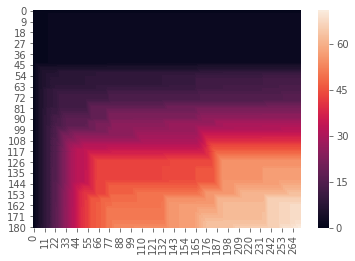

In [36]:
sns.heatmap(matrix)

# Clustering

In [9]:
import scipy.spatial.distance as ssd
# convert the redundant n*n square matrix form into a condensed nC2 array
distArray = ssd.squareform(normalized)

In [10]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(linkage='average', affinity='precomputed').fit(distances)
clustering

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=2, pooling_func='deprecated')

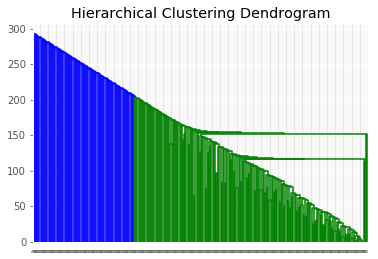

In [11]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(clustering, labels=clustering.labels_)
plt.show()

# Todo

1. Pick a way to measure similarity/distance between sequences
    * Longest prefix: if we care about beginning mostly
    * *Longest common subsequence*
    * Optimal matching with different scores for inserts, deletions, substitutions (what kind of scores make since in our context?)
* Cluster
    * Pick clustering algorithm to run on distance matrix
    * Visualize with tree
* Pick number of clusters (using silhouette or cross validation analysis)
* Analyze!
    * Visualize alignments
    * Frequency of actions
    * Frequency of actions over time bins
    * Entropy of “state” over time: entropy of first, second, third action...
    * Highest transitions between pairs of actions
    * Student attributes (incoming and outgoing)
